In [1]:
import datetime
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import requests
import re
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
font = {'fontname': 'Helvetica'}
import matplotlib as mpl

# import and load model architectures as well as decoder
from models.cueva import LSTM_FE
from models.llanes_jurado import LSTM_CNN
from utilities.preprocessors import correct_signals
from utilities.loaders import load_meta_data, load_model, load_lookup_array, charge_raw_data, _combine_data, save_lookup_array

from utilities.visualizers import (
    view_time_frame,
    view_wavelet_coeffs,
    analyze,
    data_split_metric_values,
    view_value_frequency,
    multi_class_heatmap,
    view_metric_values,
    view_classified_labels,
    view_label_freq,
    disp_cat_feat,
    plot_all_features,
    describe_col,
    ModelResults,
    view_all_splits_results)

from utilities.feature_extractors import (
    concur_extract_features_from_all,
    extract_features,
    extract_features_hybrid,
    extract_features_per_hour)

%load_ext autoreload
%autoreload 2

In [2]:
sample_models = {
    'cueva_second_phase-svm':{
        'train_results': [
            ('ahixac_expert1', {
                'train_acc': 0.9764,
                'train_prec': 0.9764,
                'train_rec': 0.9764,
                'train_f1': 0.9764,
                'train_roc_auc': 0.8764,
            }),
            ('akakip_expert1', {
                'train_acc': 0.9764,
                'train_prec': 0.9764,
                'train_rec': 0.9764,
                'train_f1': 0.9764,
                'train_roc_auc': 0.7764,
            }),
        ],
        'test_results': [
            ('pqbqpr_expert2', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.8764,
            }),
            ('oxused_expert2', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.6764,
            }),
            ('subject3', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.6764,
            }),
            ('subject4', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.6764,
            }),
            ('subject5', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.6764,
            }),
            ('subject6', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.6764,
            }),
            ('subject7', {
                'test_acc': 0.9764,
                'test_prec': 0.9764,
                'test_rec': 0.9764,
                'test_f1': 0.9764,
                'test_roc_auc': 0.6764,
            }),
        ]
    },
    'cueva-lstm-fe': {
        # 'model':
        # 'hyper_params':
    },
    'jurado-lstm-cnn': {
        # 'model':
        # 'hyper_params':
    },
    'taylor-svm': {
        # 'model':
        # 'selected_feats':
    },
    'taylor-lr': {
        # 'model':
        # 'selected_feats':
    },
    'taylor-rf': {
        # 'model':
        # 'selected_feats':
    },
    'hossain-gbt': {
        # 'model':
        # 'selected_feats':
        # 'scaler':
    },
    'hossain-svm': {
        # 'model':
        # 'selected_feats':
        # 'scaler':
    },
    'hossain-lr': {
        # 'model':
        # 'selected_feats':
        # 'scaler':
    }
}

In [3]:
models = load_meta_data('./results/all_models_results.json')
models

{'cueva_second_phase-svm': {'selected_feats': ['HOF_2',
   'HOF_5',
   'HOF_7',
   'HOF_9',
   'HOF_10',
   'HOF_12',
   'HOF_13',
   'HOF_17',
   'HOF_18',
   'HOF_19',
   'HOF_20',
   'HOF_21',
   'HOF_22',
   'HOF_26',
   'HOF_32',
   'raw_128hz_std',
   'raw_128hz_range',
   'raw_128hz_shannon_entropy',
   'raw_128hz_1d_shannon_entropy',
   'filt_128hz_min',
   'filt_128hz_1d_range',
   'filt_128hz_1d_max_abs',
   'ar_coeff_1_128hz',
   'ar_coeff_2_128hz',
   'raw_128hz_skewness',
   'raw_128hz_kurt',
   'third_16thofa_sec_max',
   'first_16thofa_sec_mean',
   'second_16thofa_sec_mean',
   'third_16thofa_sec_std',
   'first_16thofa_sec_median',
   'second_16thofa_sec_median',
   'third_16thofa_sec_range',
   'second_32thofa_sec_max',
   'first_32thofa_sec_mean',
   'second_32thofa_sec_mean',
   'first_32thofa_sec_std',
   'second_32thofa_sec_std',
   'first_32thofa_sec_median',
   'second_32thofa_sec_median',
   'first_32thofa_sec_range',
   'raw_16hz_min',
   'raw_16hz_range',
   

# Visualization
#### what I want is across each model see accuracy for all subjects in train and test set i.e. a figure will show taylor's svm accuracy across all train and test subjects
- have the x ticks be labeled as the subject names
- have the y ticks be labeled as the percentage value of the accuracy or roc  
- the title for the plot will be for instance `taylor svm train accuracy results.png`, and the general title would be `{selector_config} {estimator_name} {data_split} {metric} results.png`

![sample results chart.png](../../sample%20results%20chart.png)

In [4]:
models = models

In [5]:
data = [(subject_name, result['test_roc_auc']) for (subject_name, result) in models['cueva_second_phase-svm']['test_results']]
data

[('ajeric_expert2', 0.871081395582632),
 ('ukudab_expert2', 0.8195077099420561),
 ('afegip_expert1', 0.7702608759527361),
 ('pqbqpr_expert2', 0.7806556338329018),
 ('uhepah_expert1', 0.901017383204489),
 ('otafeh_expert1', 0.8500711468567329),
 ('inefoh_expert1', 0.879866065700882),
 ('ekamis_expert2', 0.8313647519330503),
 ('oxused_expert2', 0.8726800341147299),
 ('iguted_expert1', 0.8473601940282919)]

In [6]:
x_ticks, y_ticks = list(zip(*data))
x_ticks, y_ticks

(('ajeric_expert2',
  'ukudab_expert2',
  'afegip_expert1',
  'pqbqpr_expert2',
  'uhepah_expert1',
  'otafeh_expert1',
  'inefoh_expert1',
  'ekamis_expert2',
  'oxused_expert2',
  'iguted_expert1'),
 (0.871081395582632,
  0.8195077099420561,
  0.7702608759527361,
  0.7806556338329018,
  0.901017383204489,
  0.8500711468567329,
  0.879866065700882,
  0.8313647519330503,
  0.8726800341147299,
  0.8473601940282919))

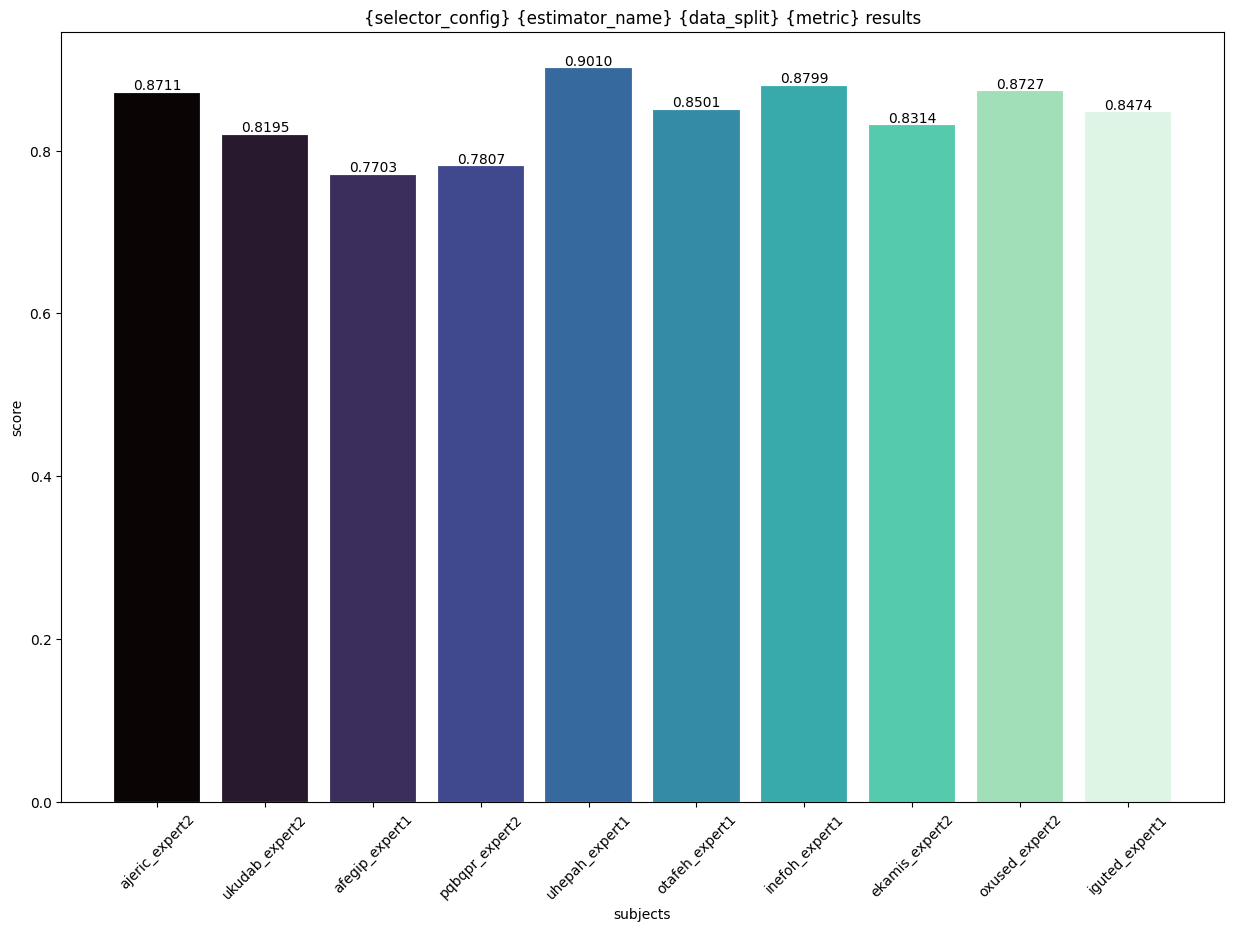

In [7]:
cmap = mpl.colormaps['mako']
fig = plt.figure(figsize=(15, 10))
axis = fig.add_subplot()

bar = axis.bar(x_ticks, y_ticks, color=cmap(np.linspace(0, 1, len(data))), edgecolor='white', linewidth=0.125)
axis.bar_label(bar, fmt='{:.4f}')
axis.set_xlabel('subjects', )
axis.set_ylabel('score', )
axis.tick_params(axis='x', labelrotation=45.0)
axis.set_title('{selector_config} {estimator_name} {data_split} {metric} results')
plt.show()

In [8]:
def view_subject_results(data, selector_config: str, estimator_name: str, data_split: str="train", metric: str="acc", colormap: str="plasma", save_img: bool=True, style: str='default'):
    """
    suitable for all discrete input

    plots either a horizontal bar graph to display frequency of words top 'limit' 
    words e.g. top 20 or a pie chart to display the percentages of the top 'limit' 
    words e.g. top 20, specified by the argument kind which can be either
    strings barh or pie

    main args:
        data - list of tuples representing the subject and the subjects respective score
        selector_config - 
        estimator_name - 
        data_split - 
        metric - 
        colormap - 
        save_img - 
        style - 
    """

    # compose title based on selector_config, estimator_name, data_split, and metric args
    title = f'{selector_config} {estimator_name} {data_split} {metric} results'

    # extract x and y values from data
    x_ticks, y_ticks = list(zip(*data))

    styles = {
        'dark': 'dark_background',
        'solarized': 'Solarized_Light2',
        '538': 'fivethirtyeight',
        'ggplot': 'ggplot',
    }

    plt.style.use(styles.get(style, 'default'))

    # define figure
    cmap = mpl.colormaps[colormap]
    fig = plt.figure(figsize=(15, 10))
    axis = fig.add_subplot()

    # plot bar graph
    bar = axis.bar(x_ticks, y_ticks, color=cmap(np.linspace(0, 1, len(data))), edgecolor='white', linewidth=0.125)
    axis.bar_label(bar, fmt='{:.4f}')
    axis.set_xlabel('subjects', )
    axis.set_ylabel(f'{metric} score', )
    axis.tick_params(axis='x', labelrotation=45.0)
    axis.set_title(title)
    if save_img:
        plt.savefig(f'./figures & images/{title}.png')
    plt.show()        

In [9]:
# model_names = ['cueva_second_phase-svm', 'taylor-lr', 'taylor-rf', 'taylor-svm', 'hossain-lr', 'hossain-gbt', 'hossain-svm', 'jurado-lstm-cnn']
model_names = ['cueva_second_phase-svm', 'taylor-lr', 'taylor-rf', 'taylor-svm', 'hossain-lr', 'hossain-gbt', 'jurado-lstm-cnn']
data_splits = ["train", "test"]
metrics = ["acc", "prec", "rec", "f1", "roc_auc"]
colormaps = ['mako', 'GnBu', 'plasma', 'magma', 'twilight', 'YlOrBr']

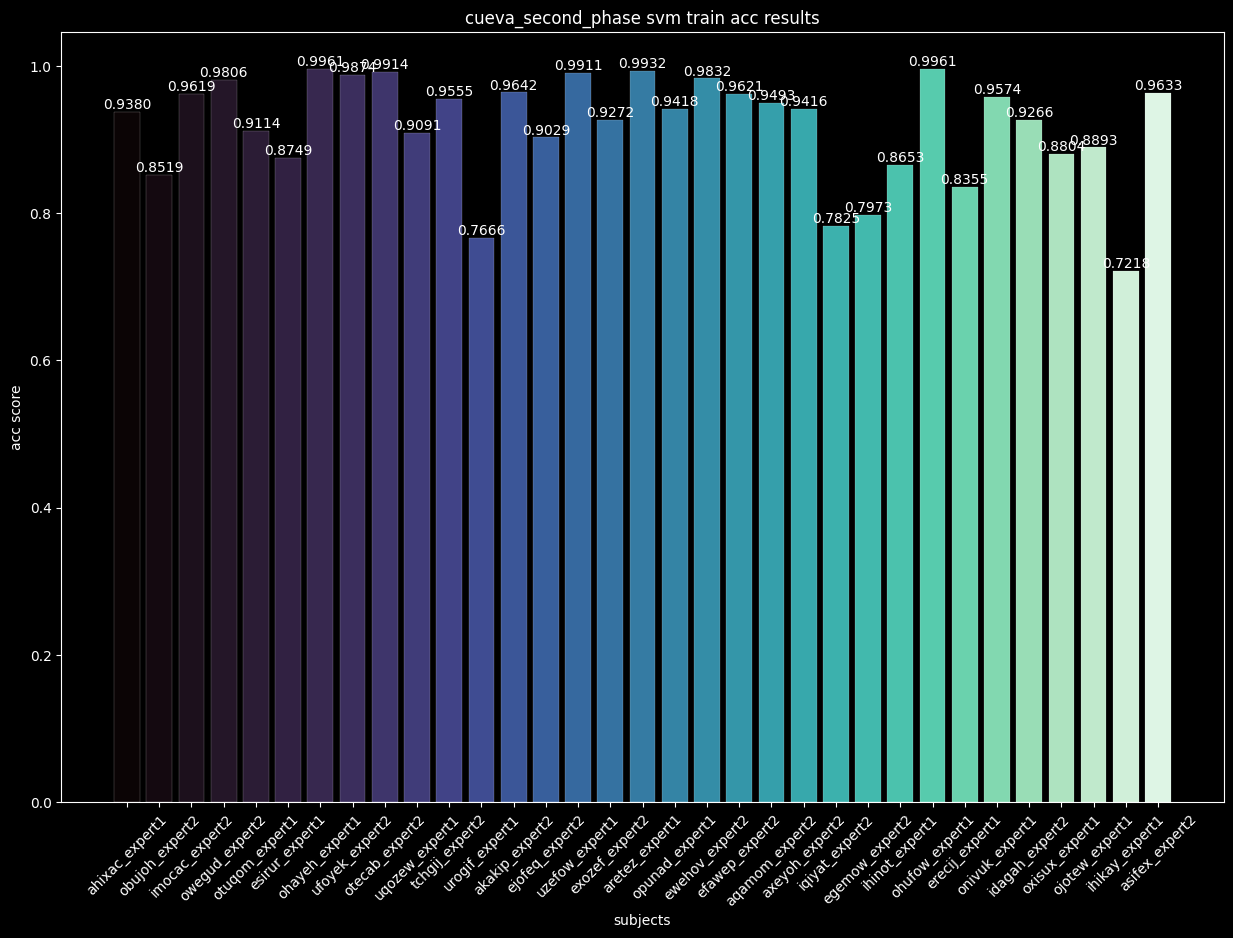

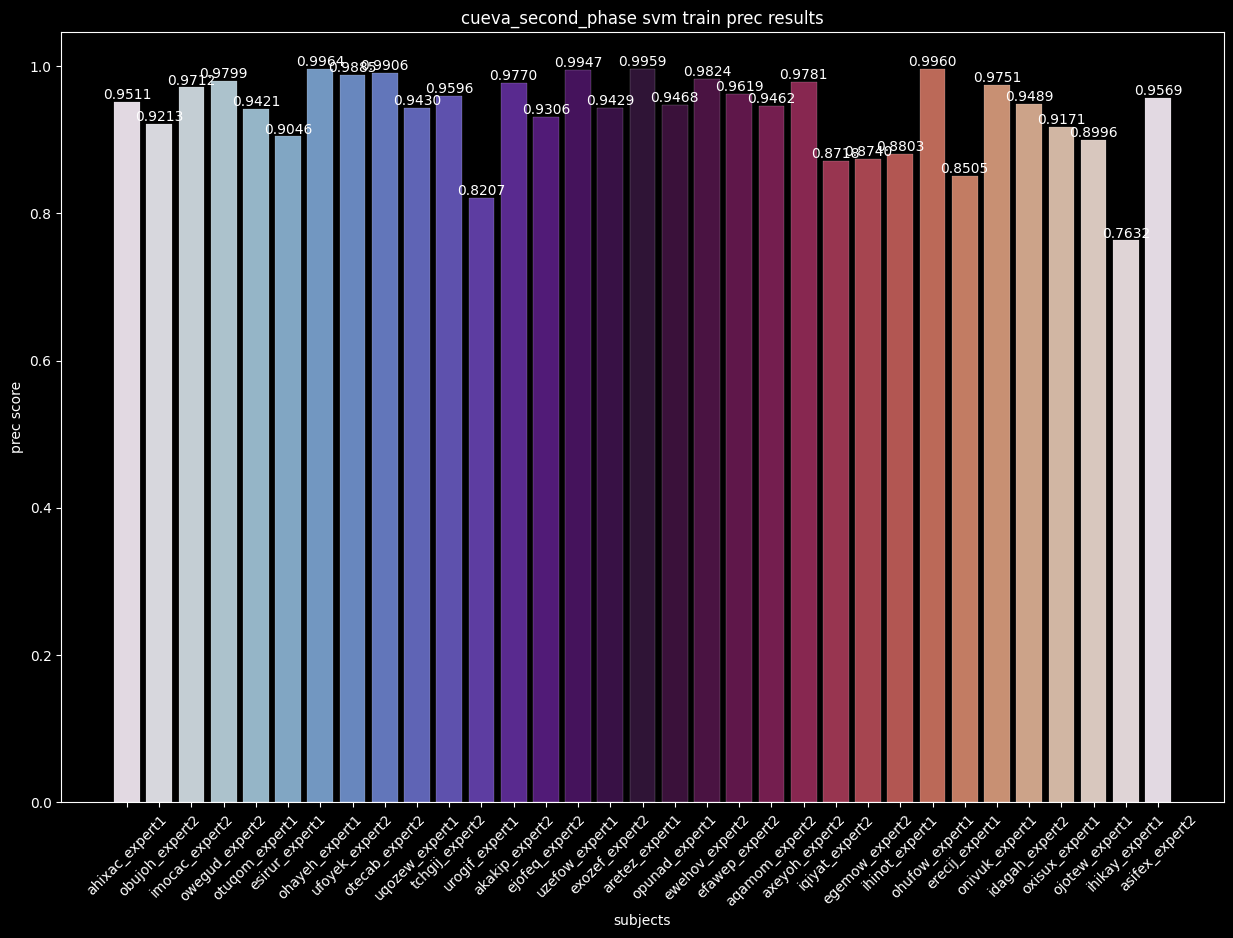

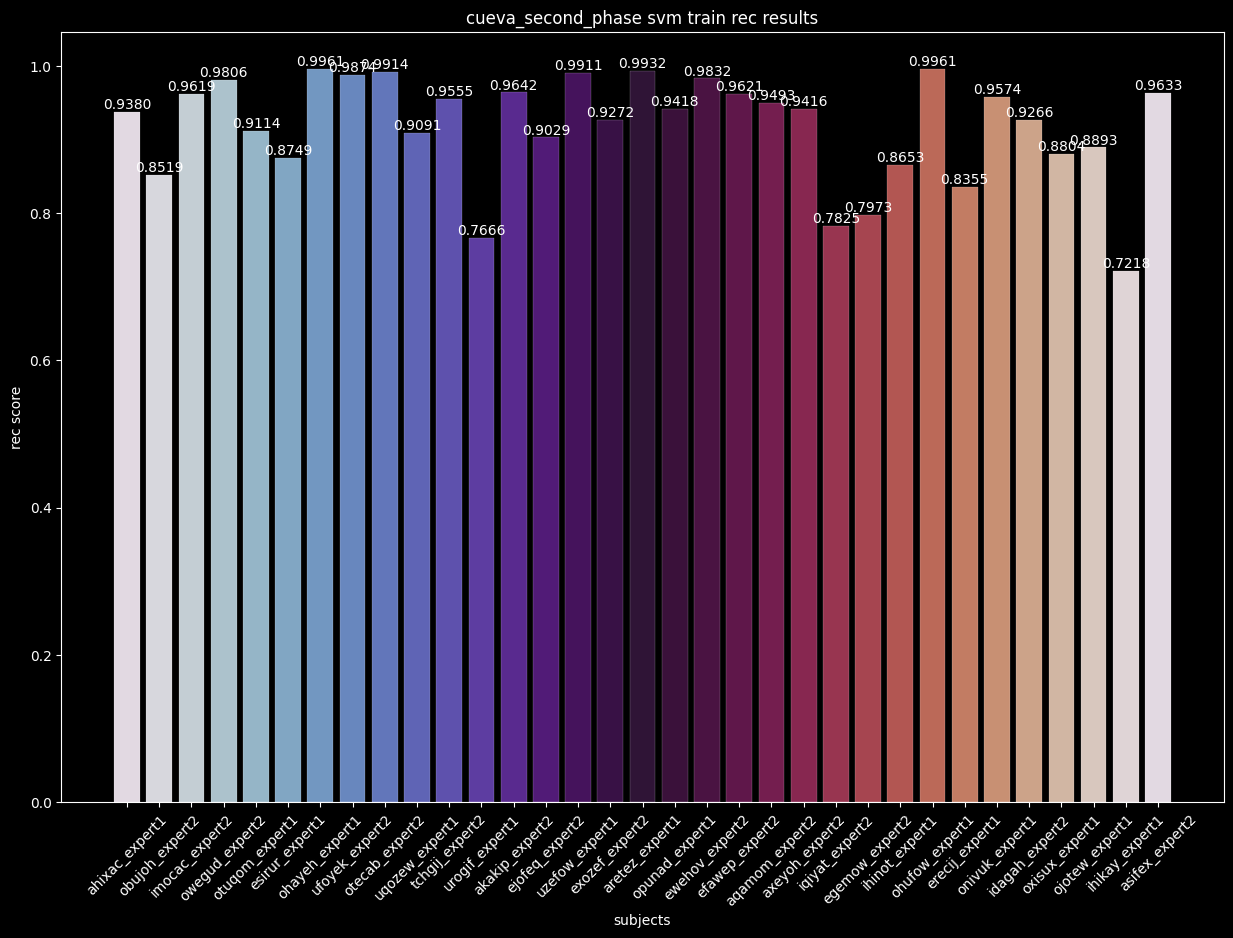

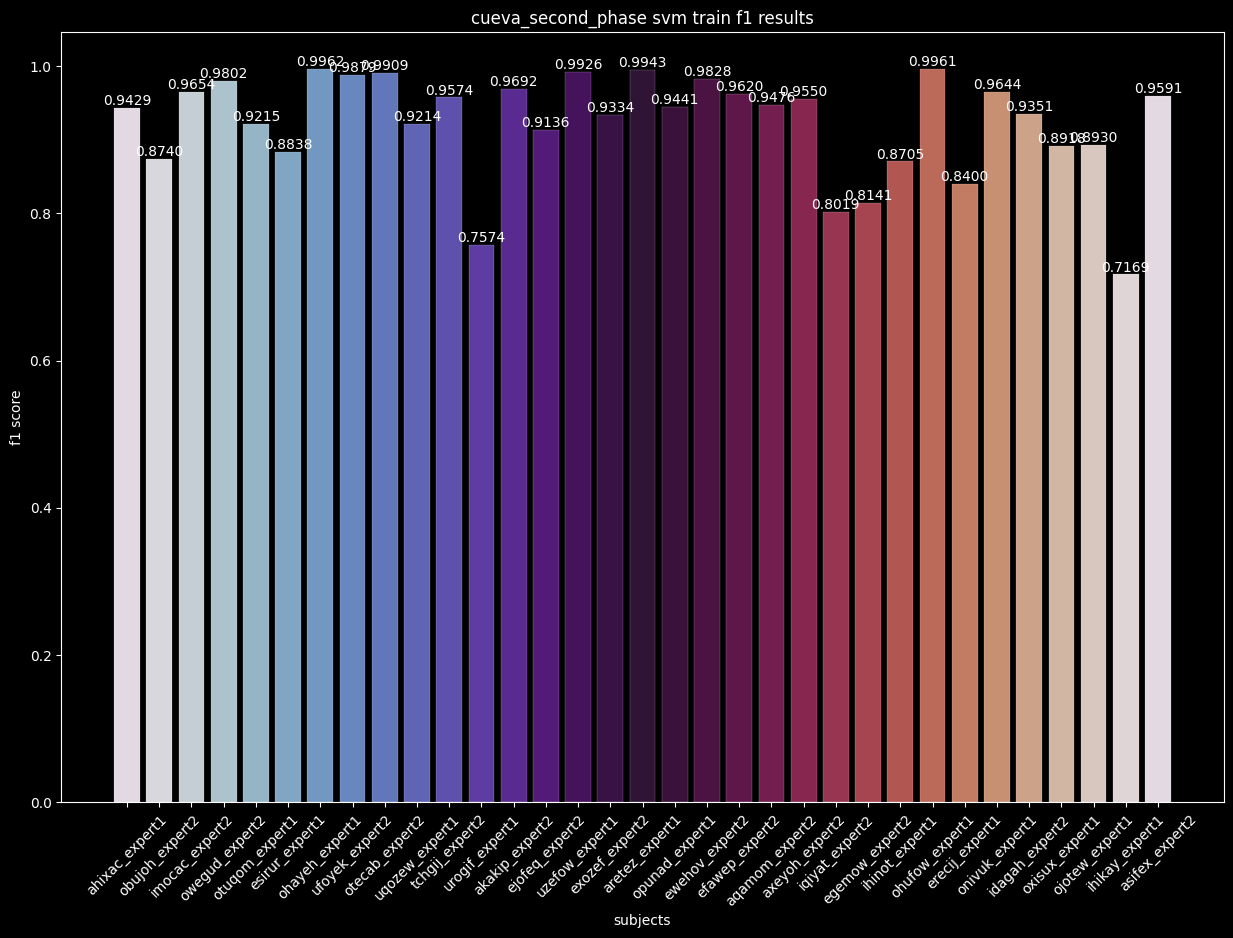

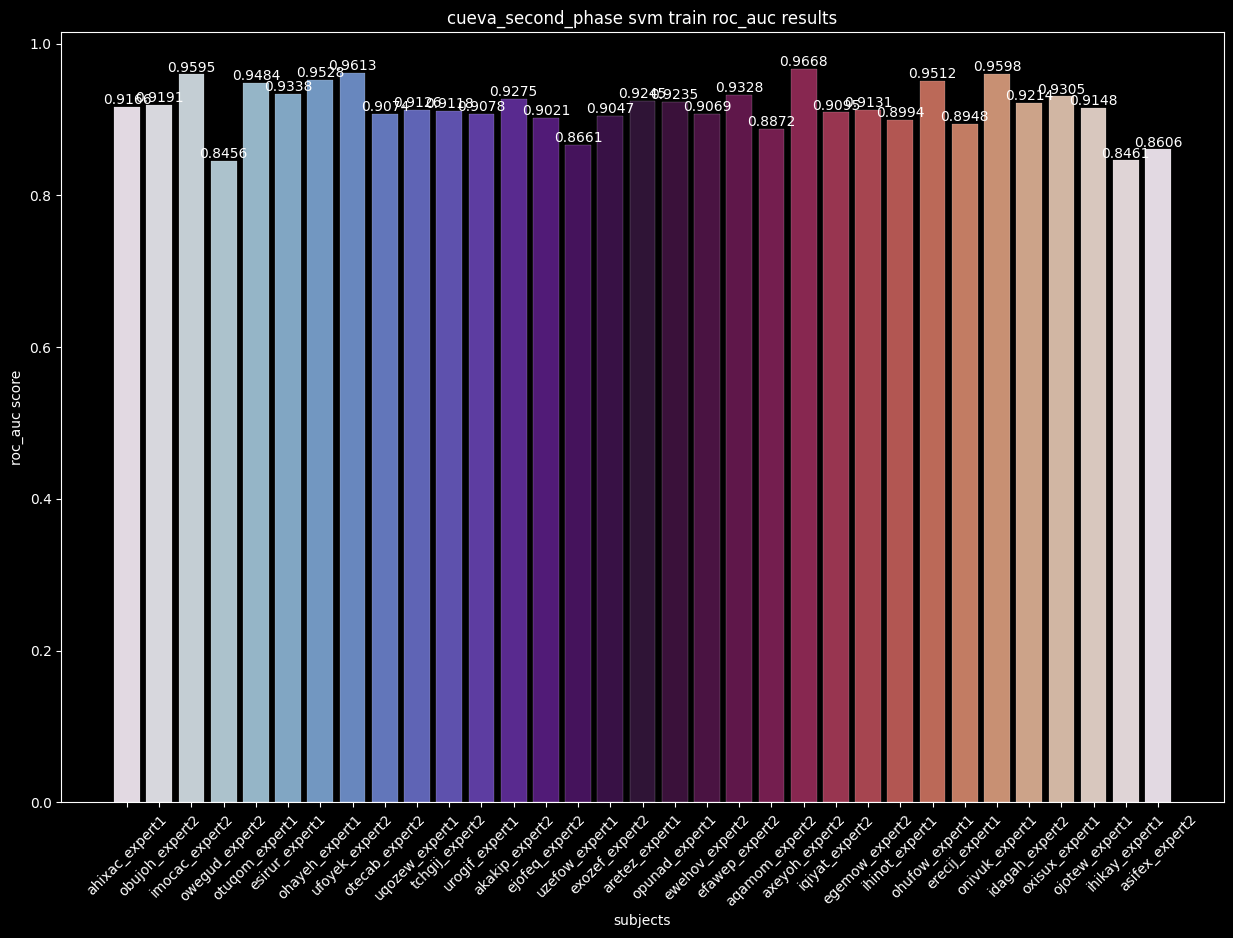

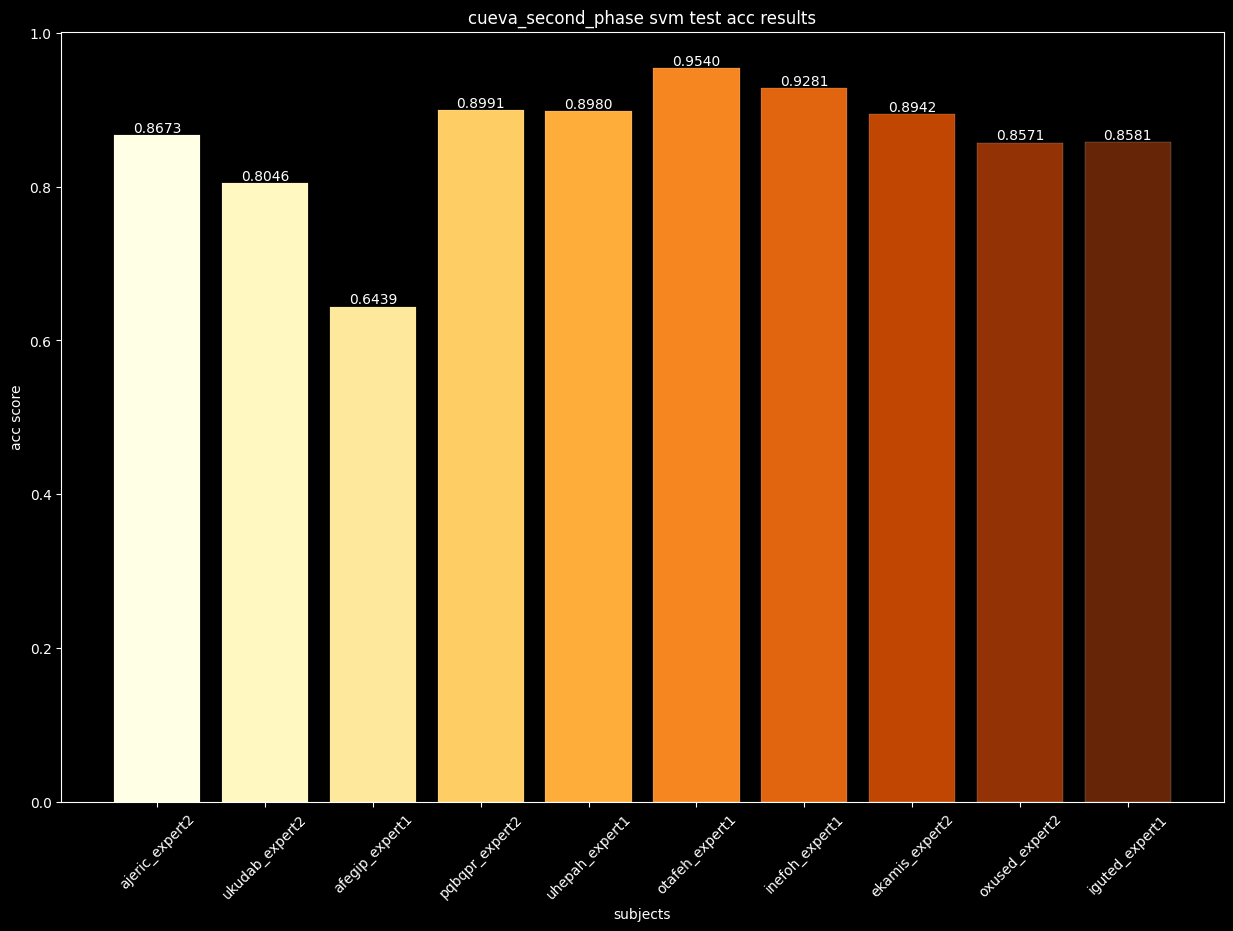

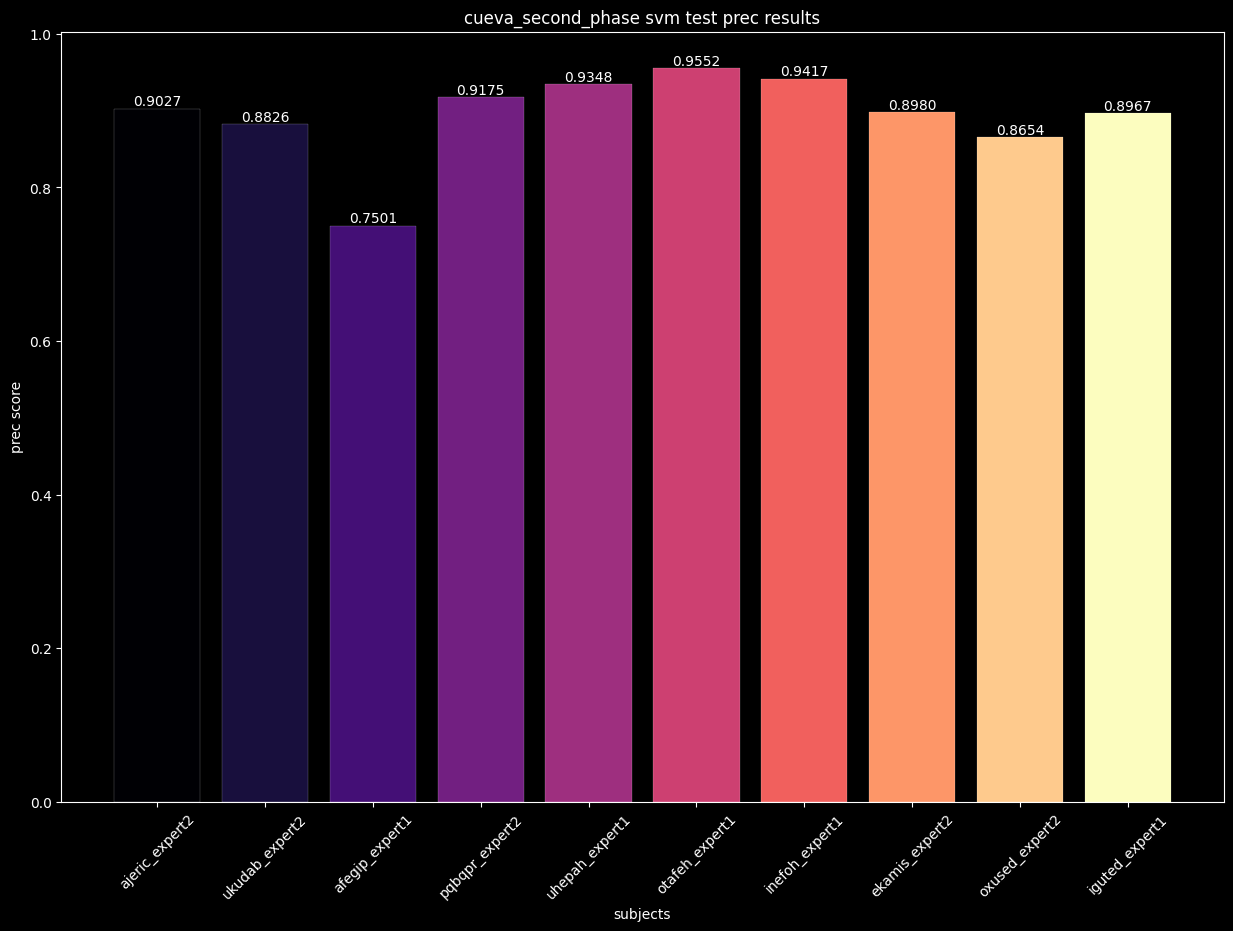

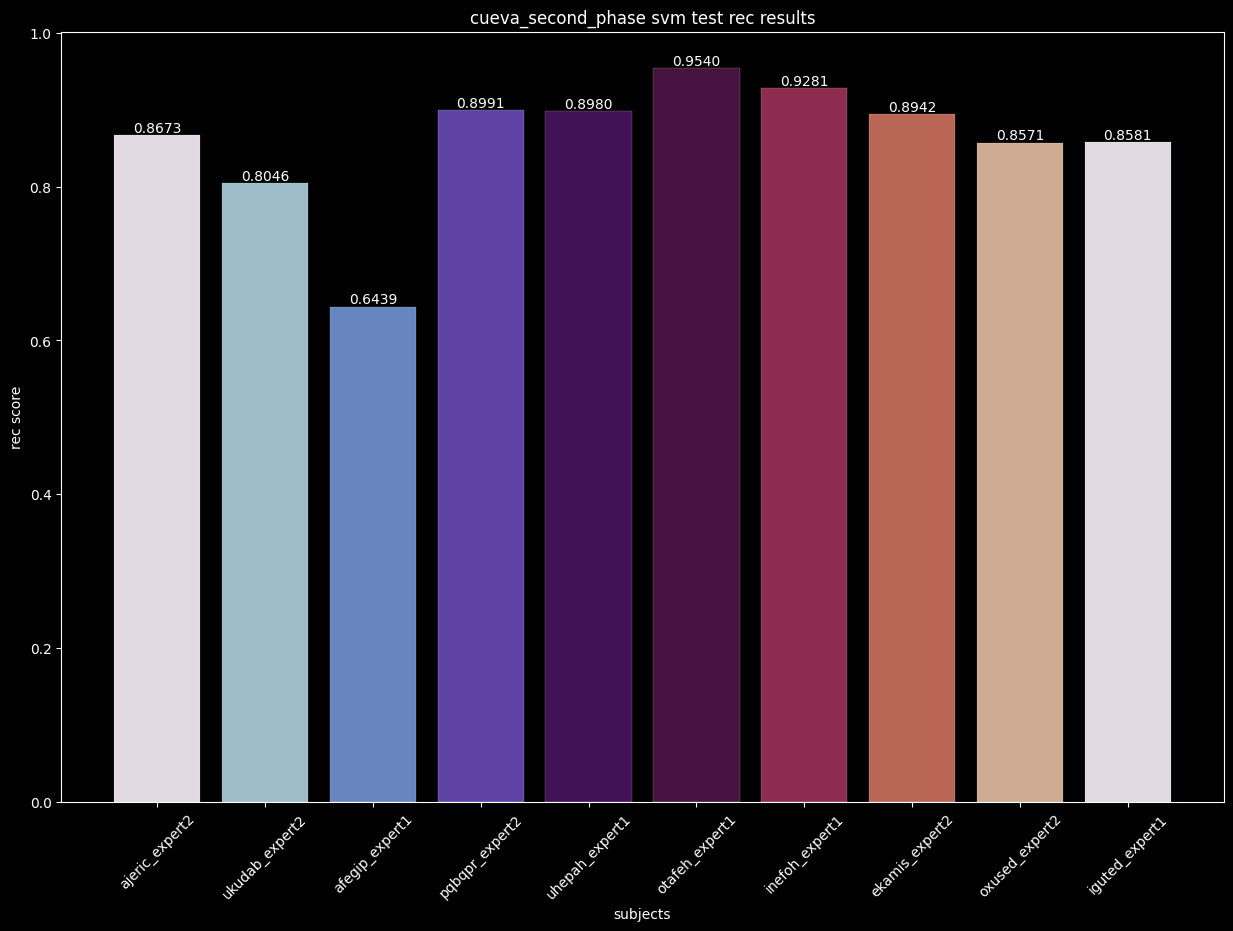

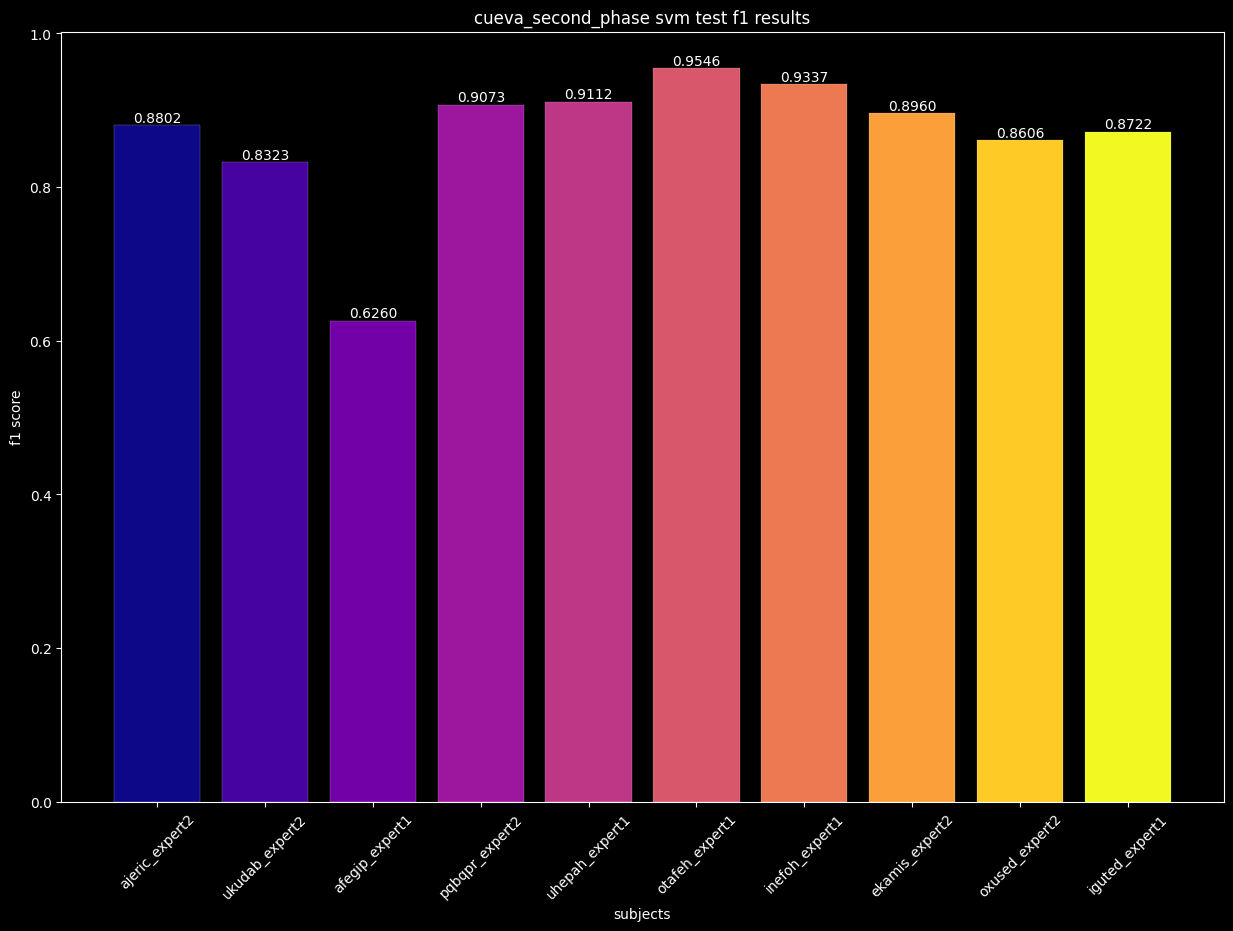

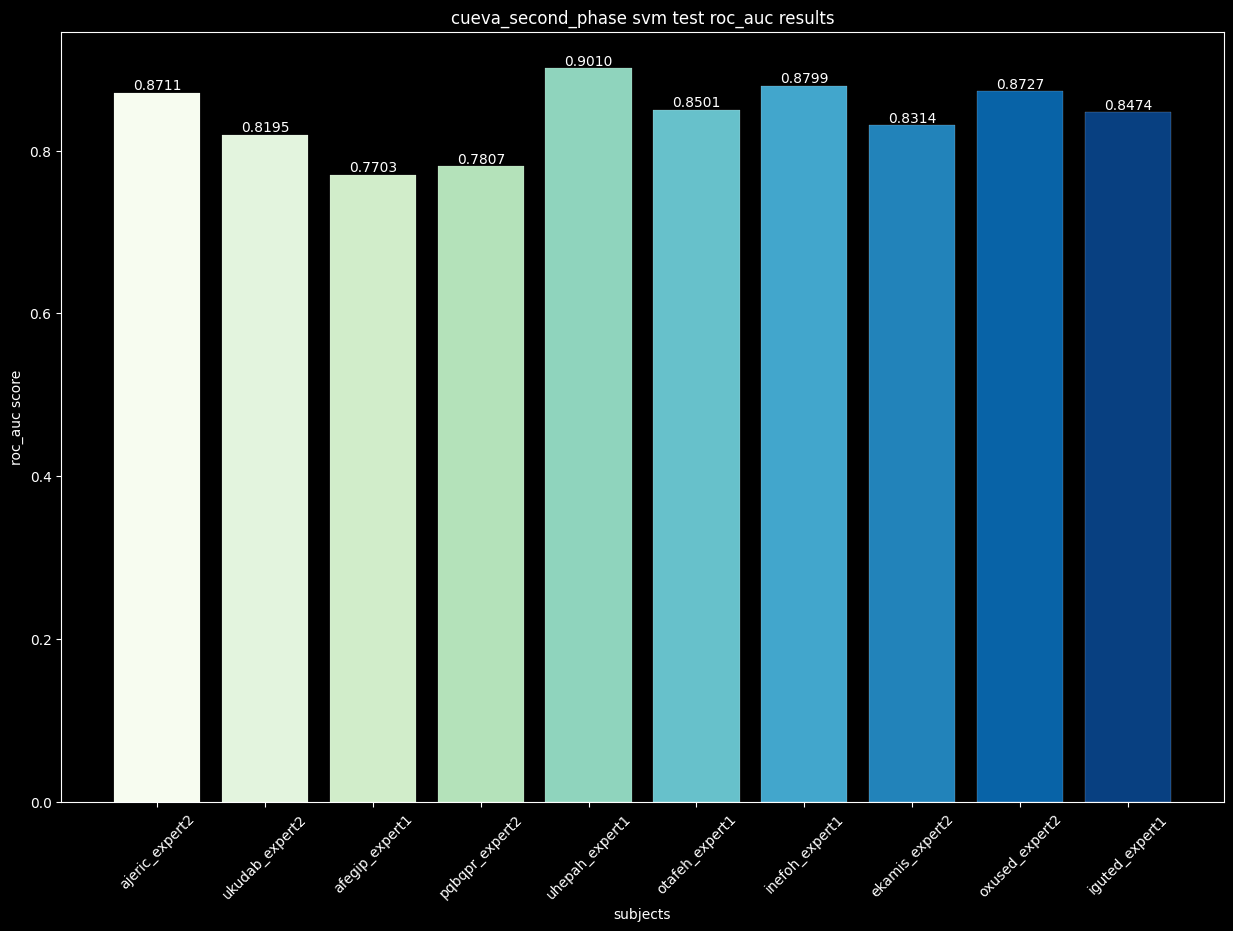

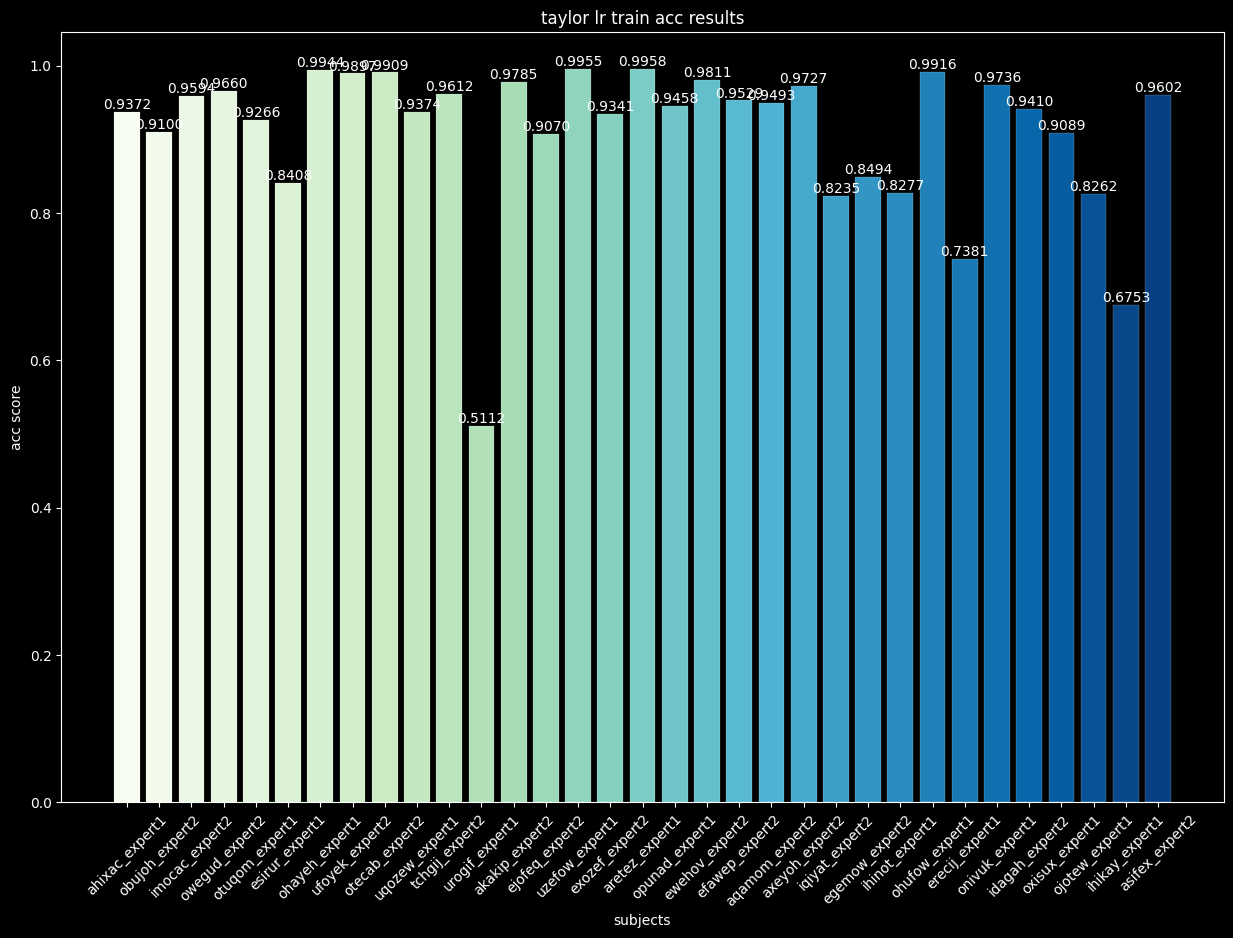

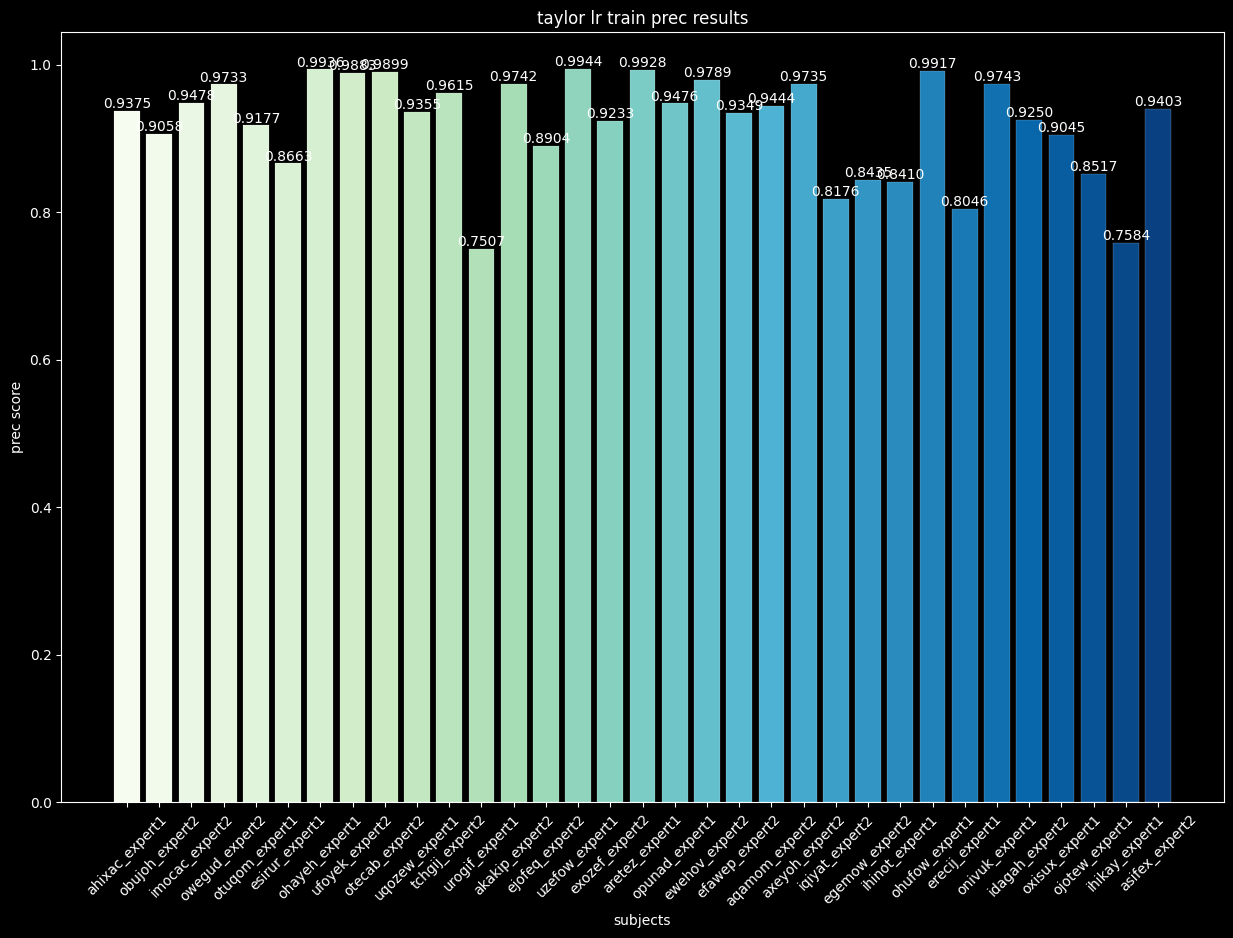

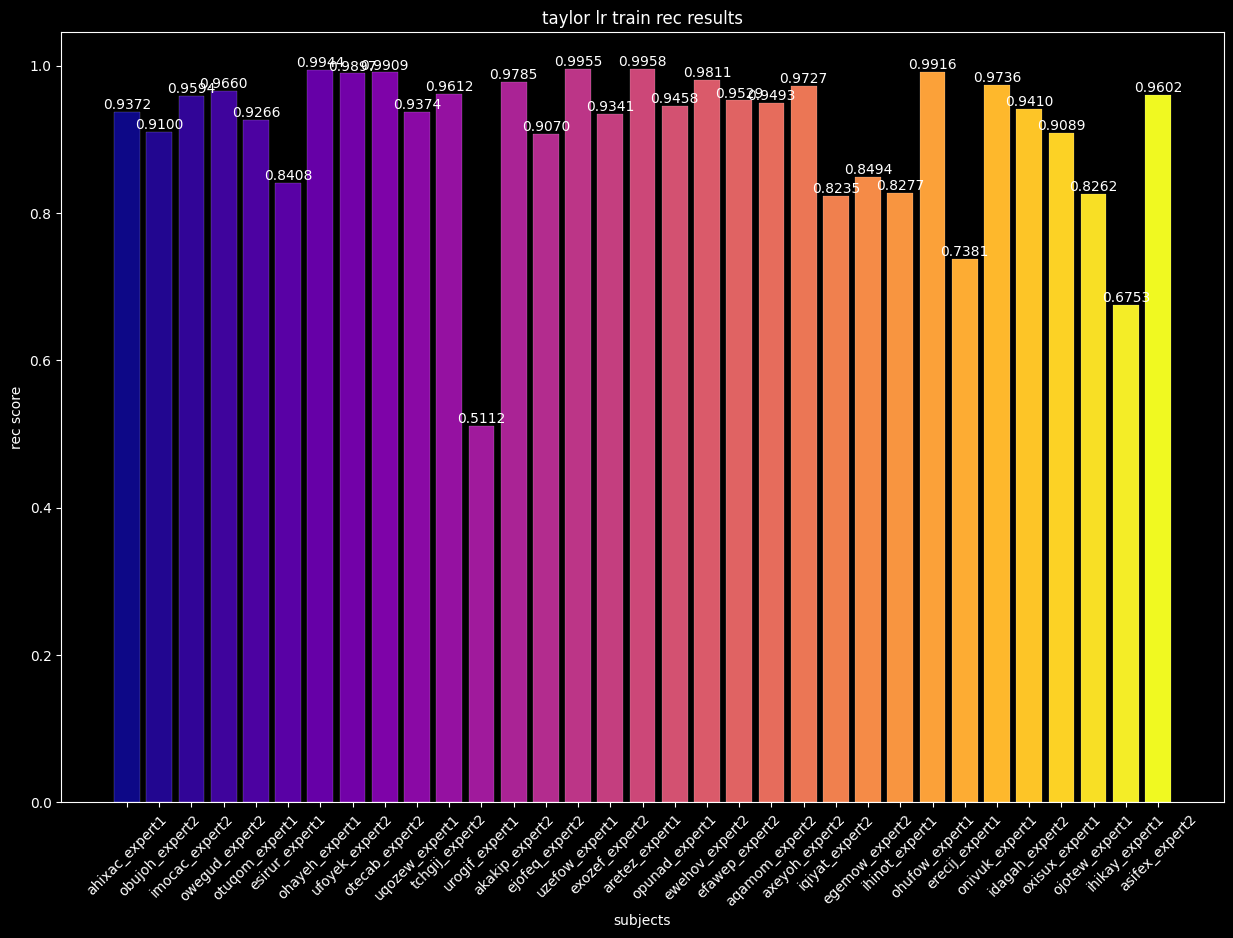

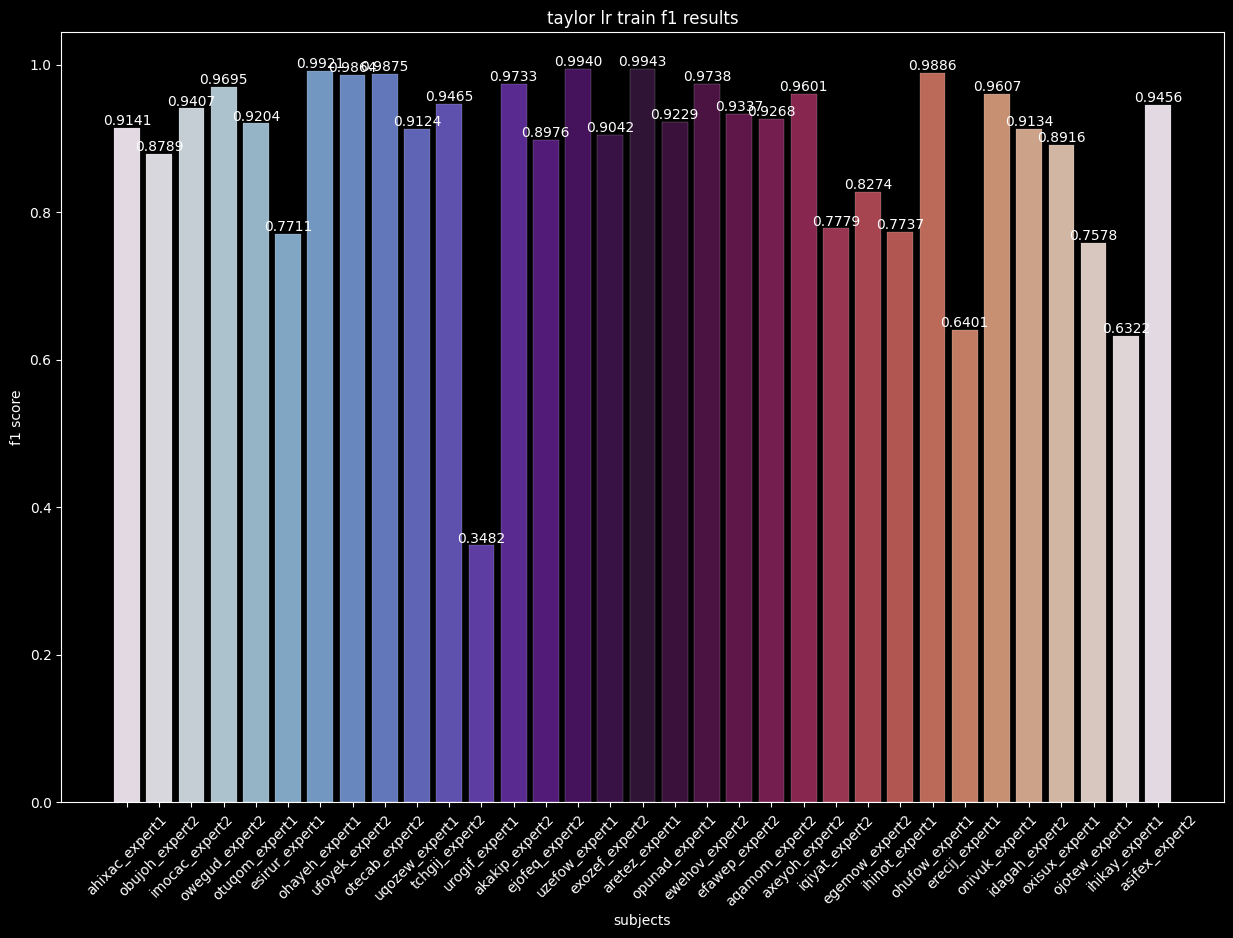

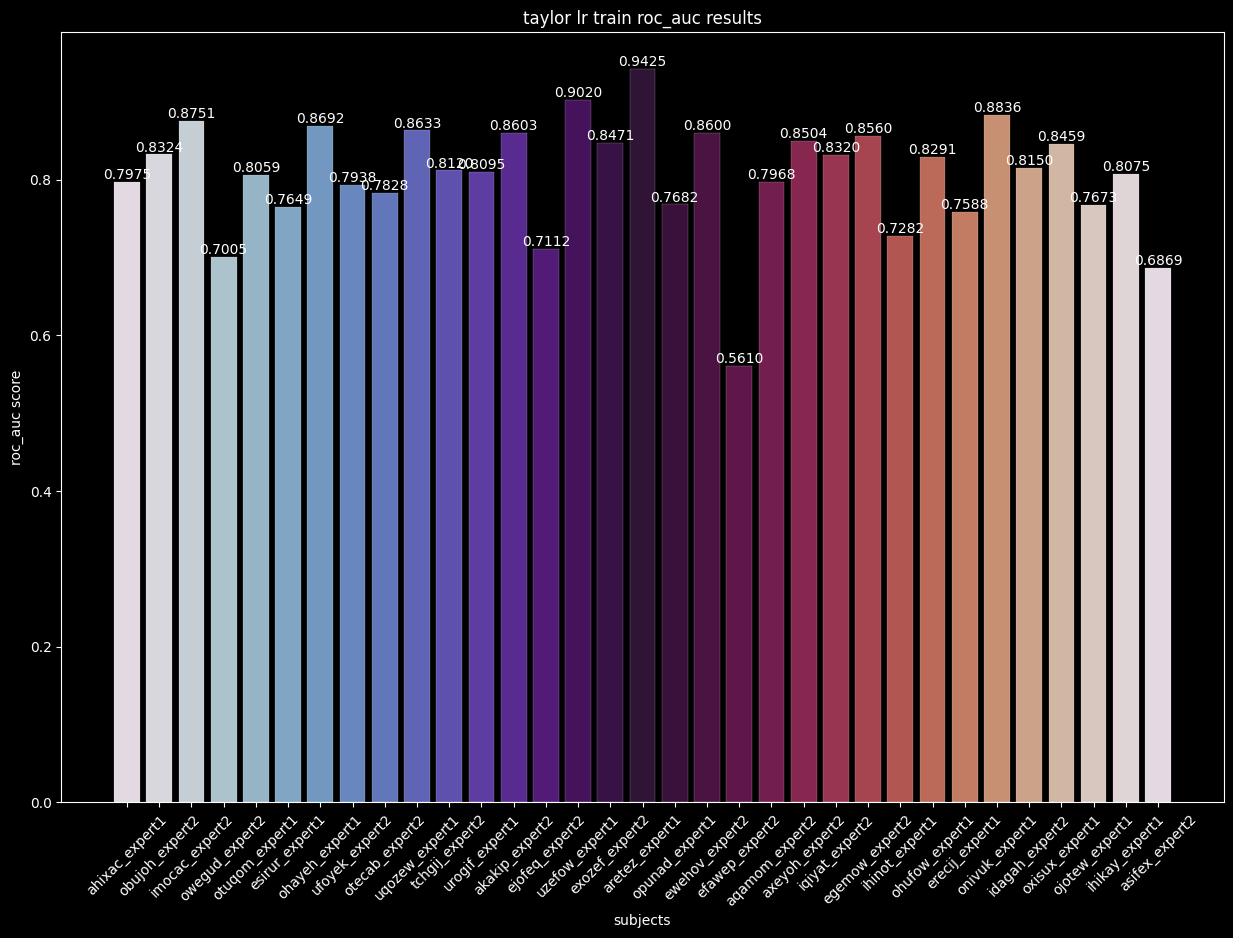

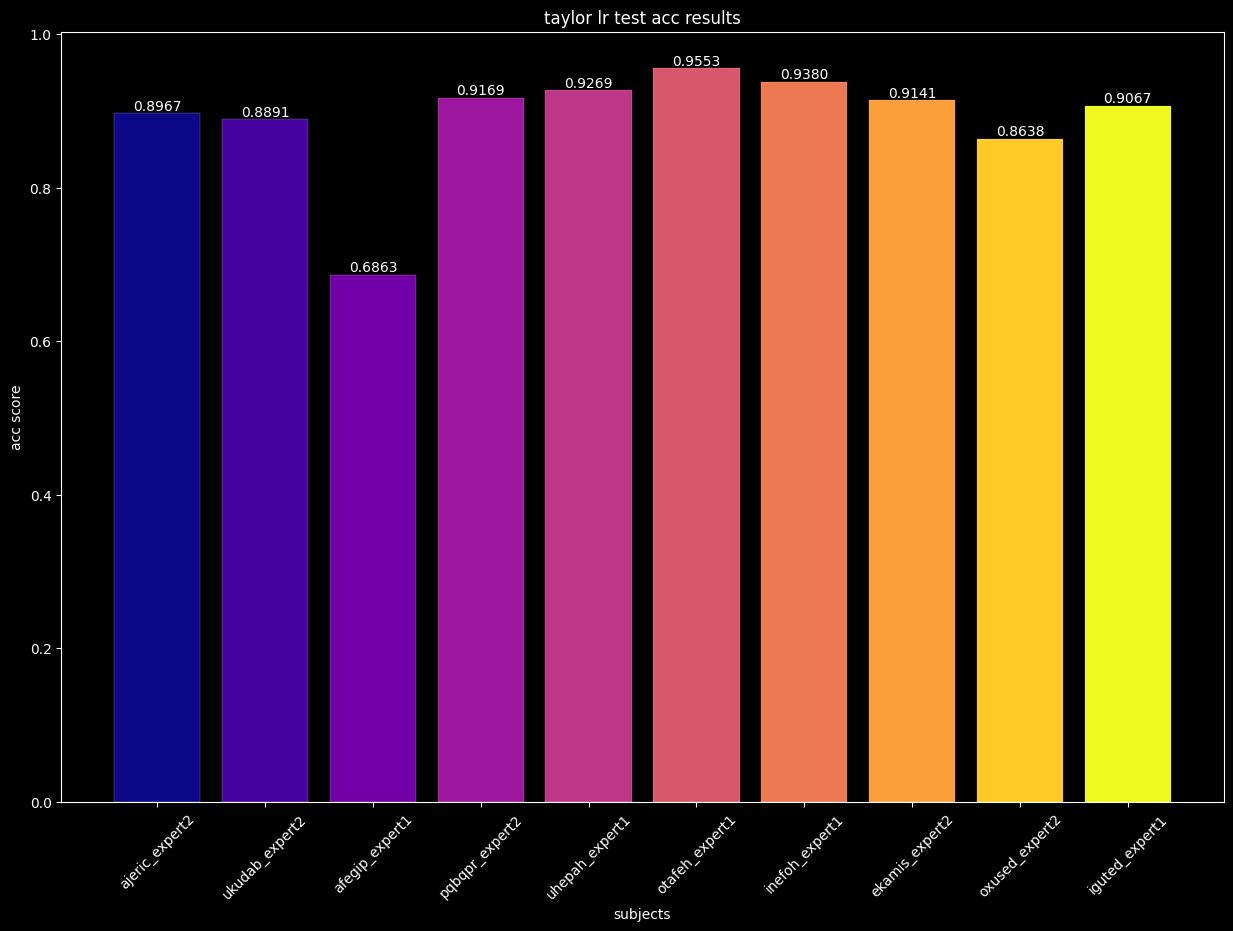

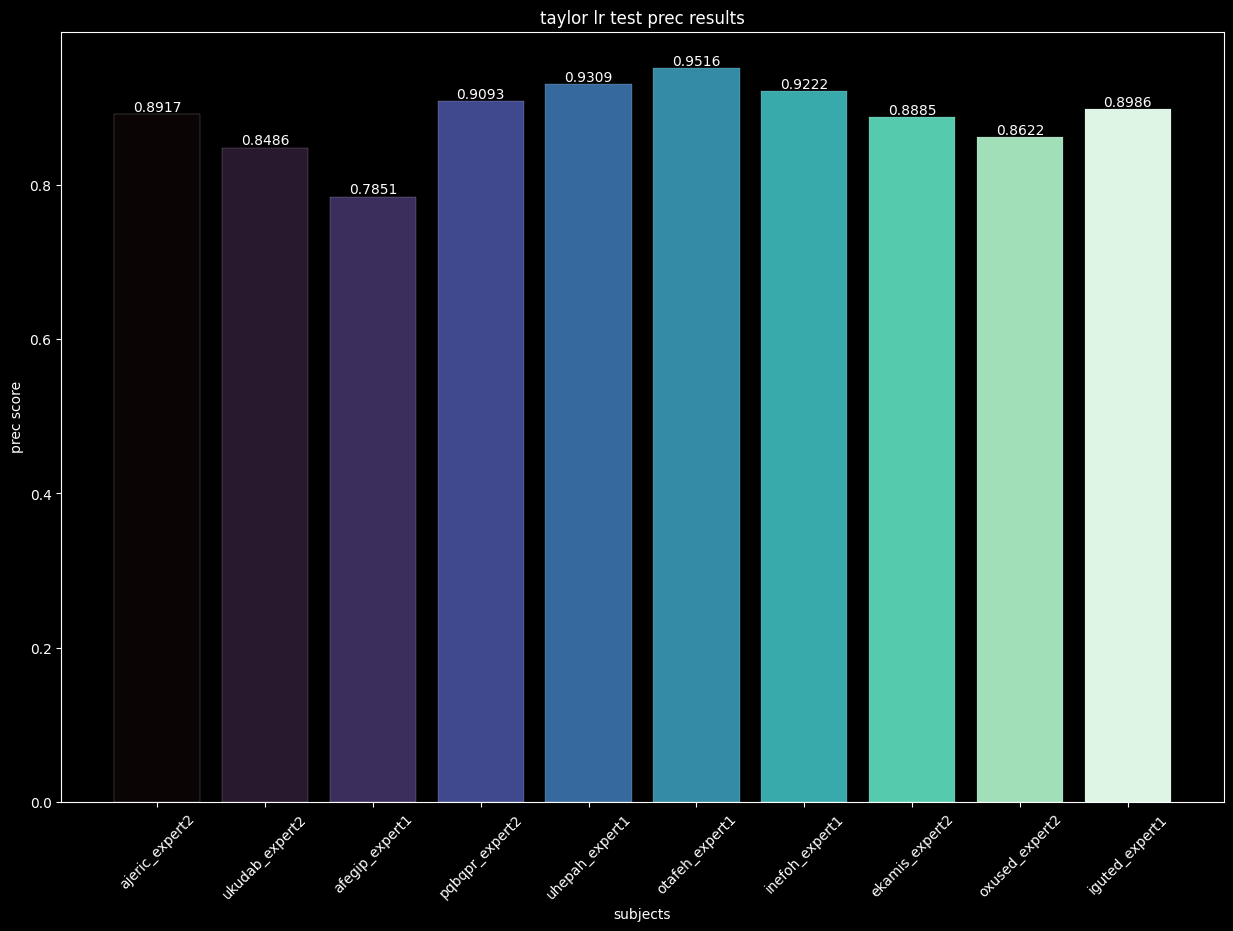

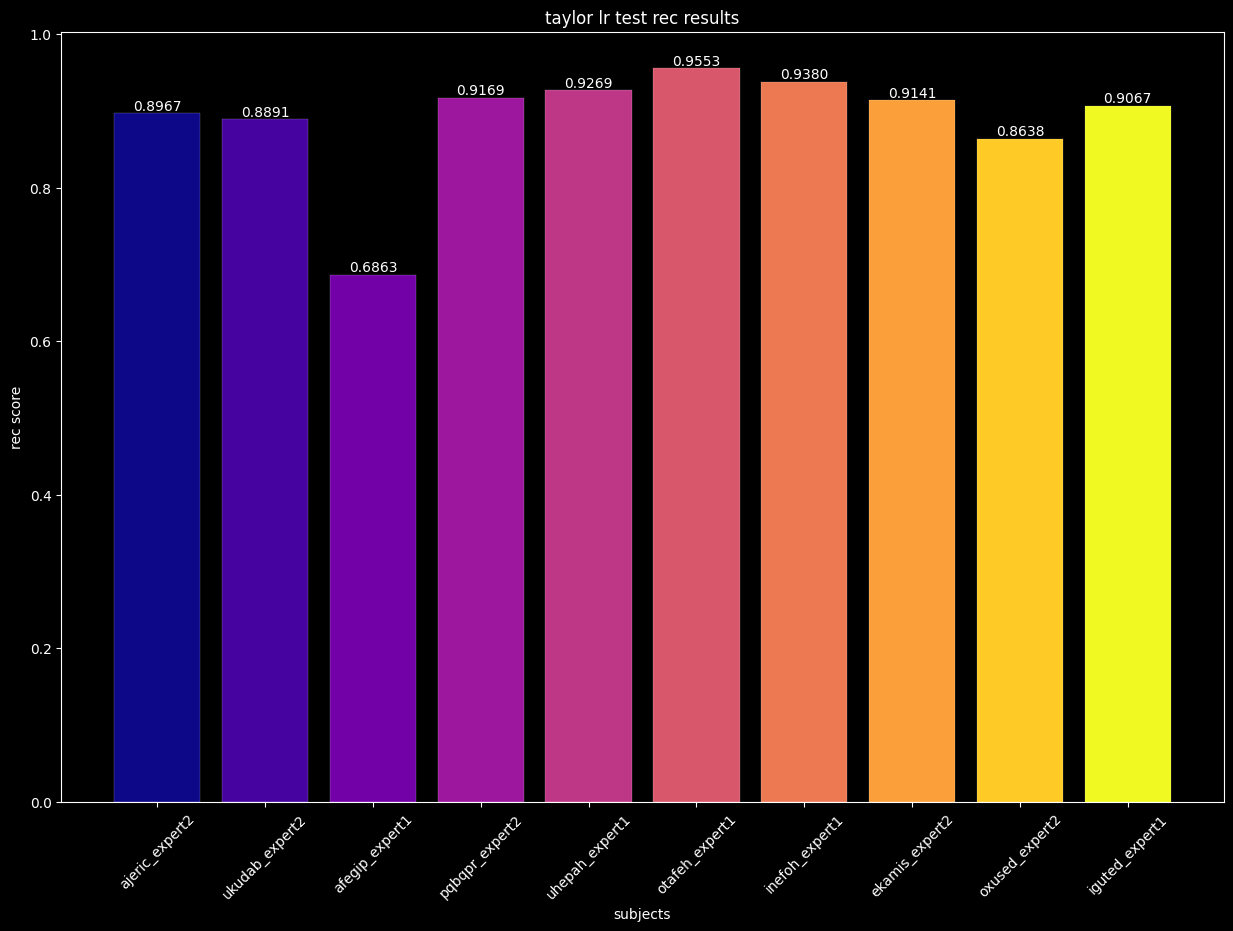

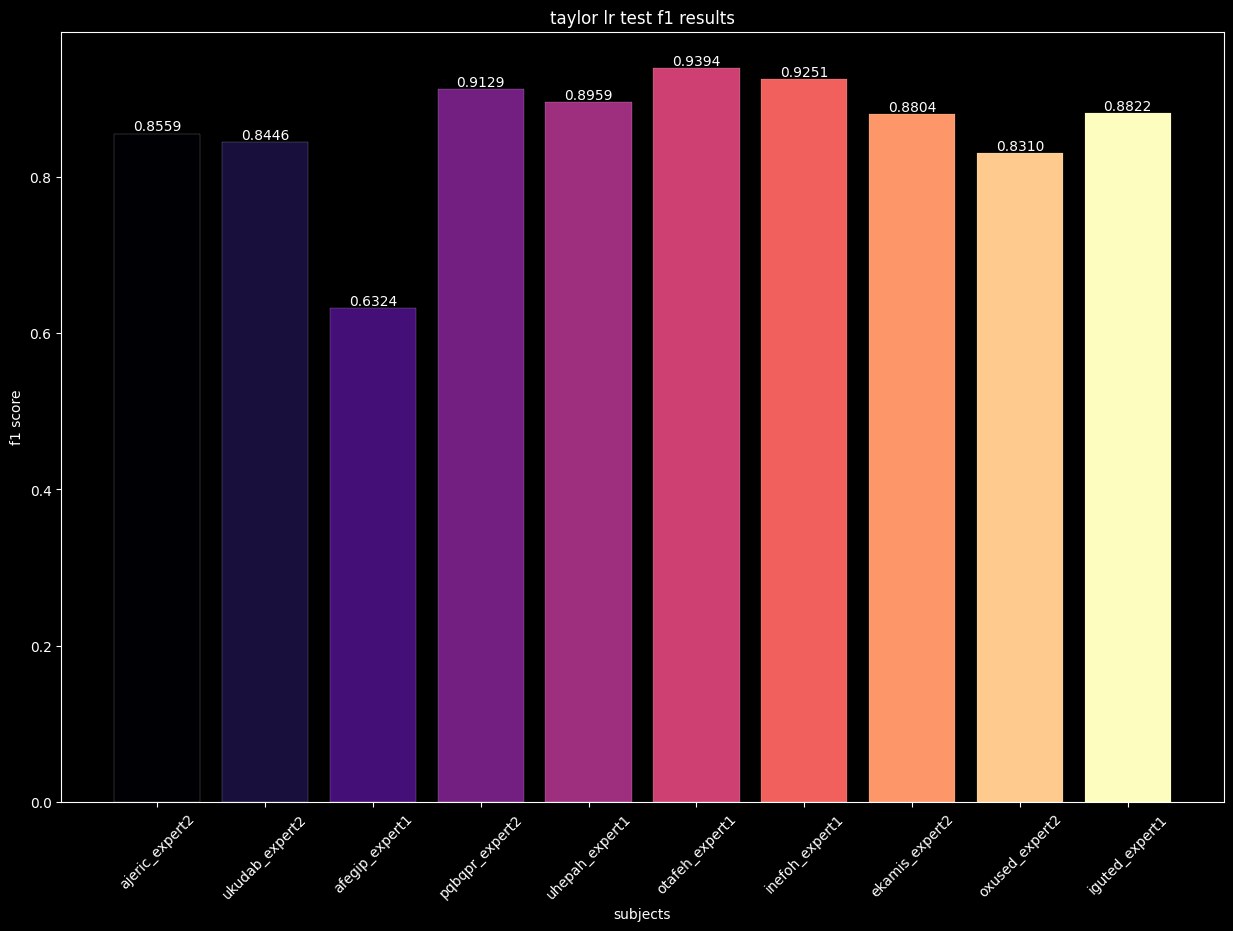

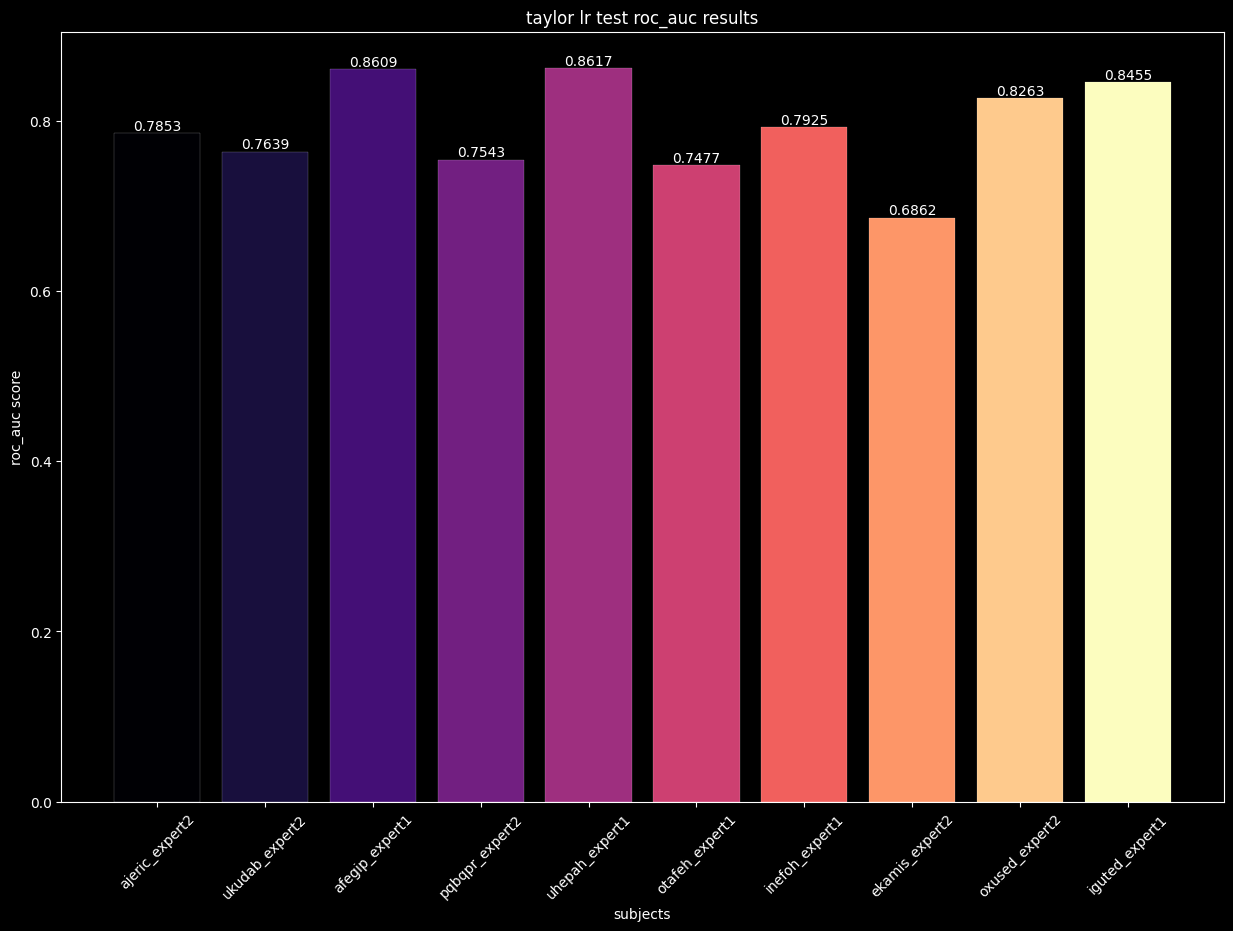

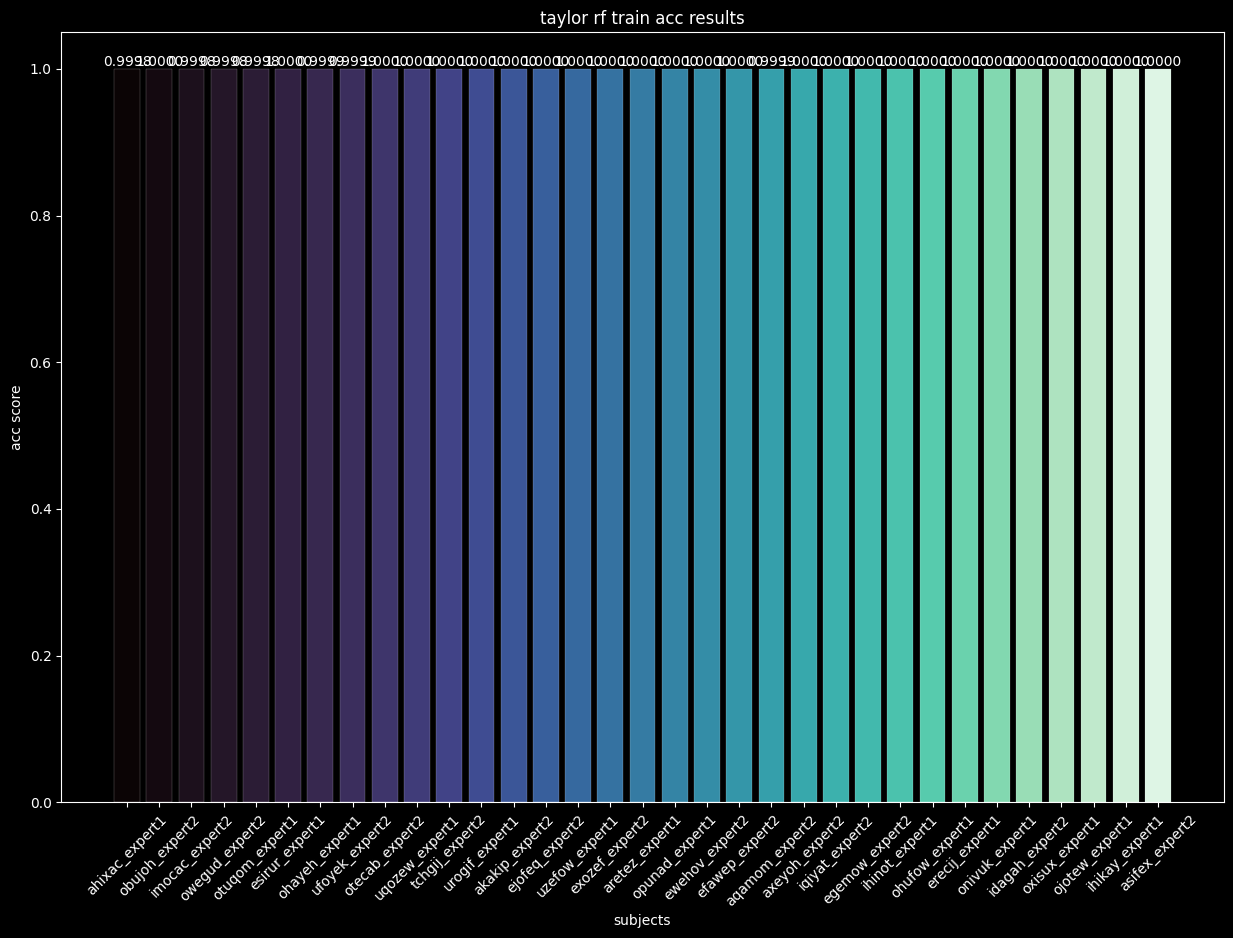

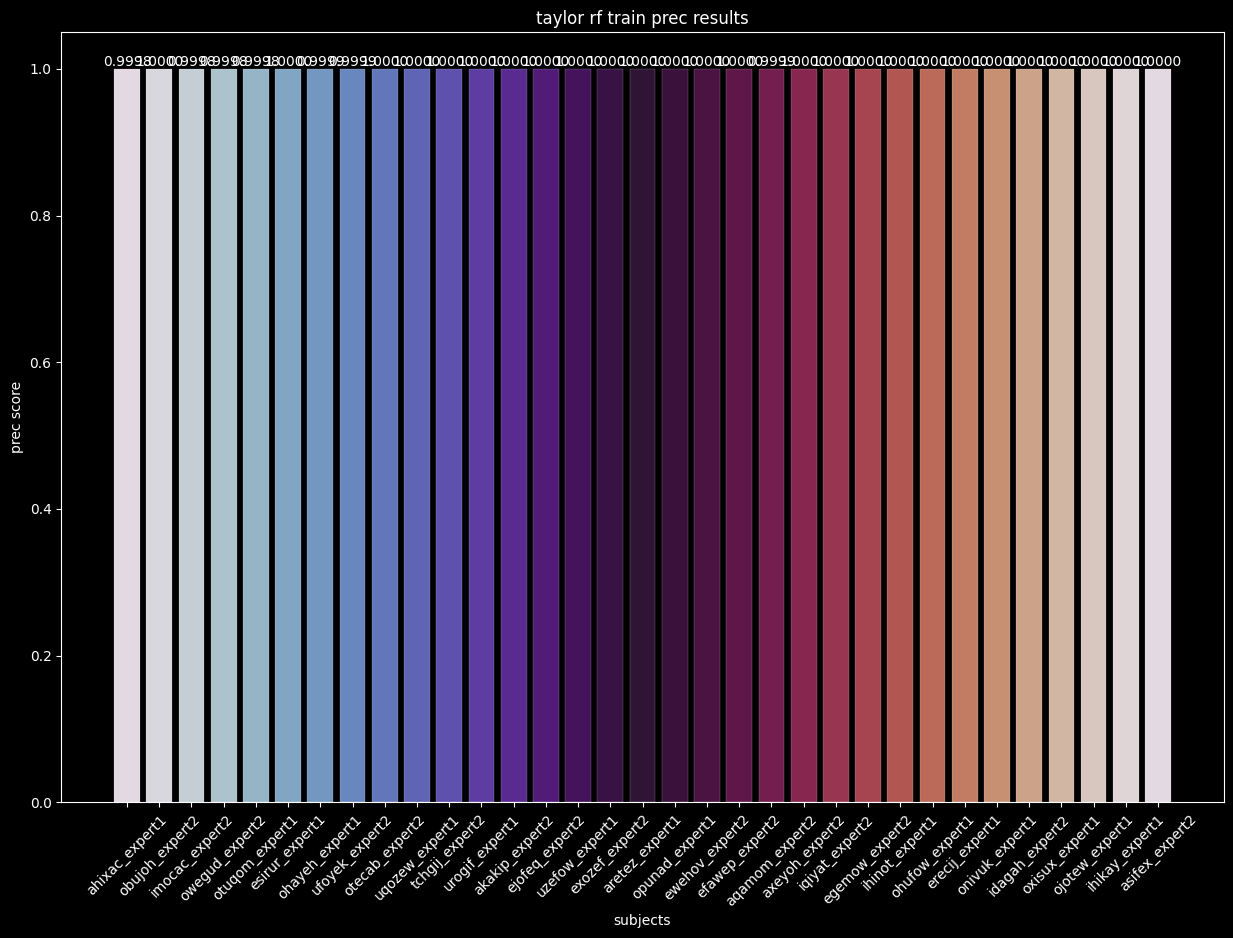

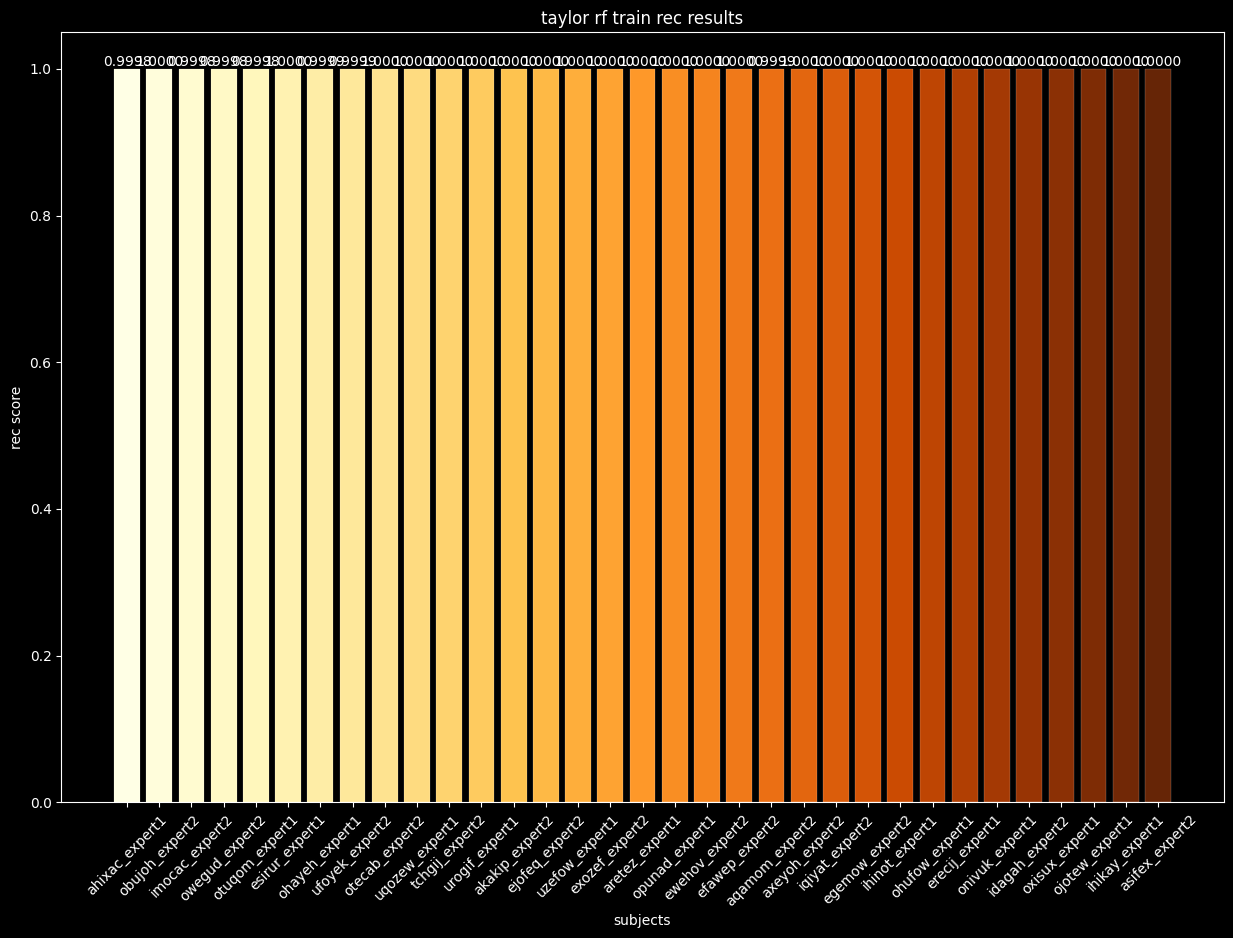

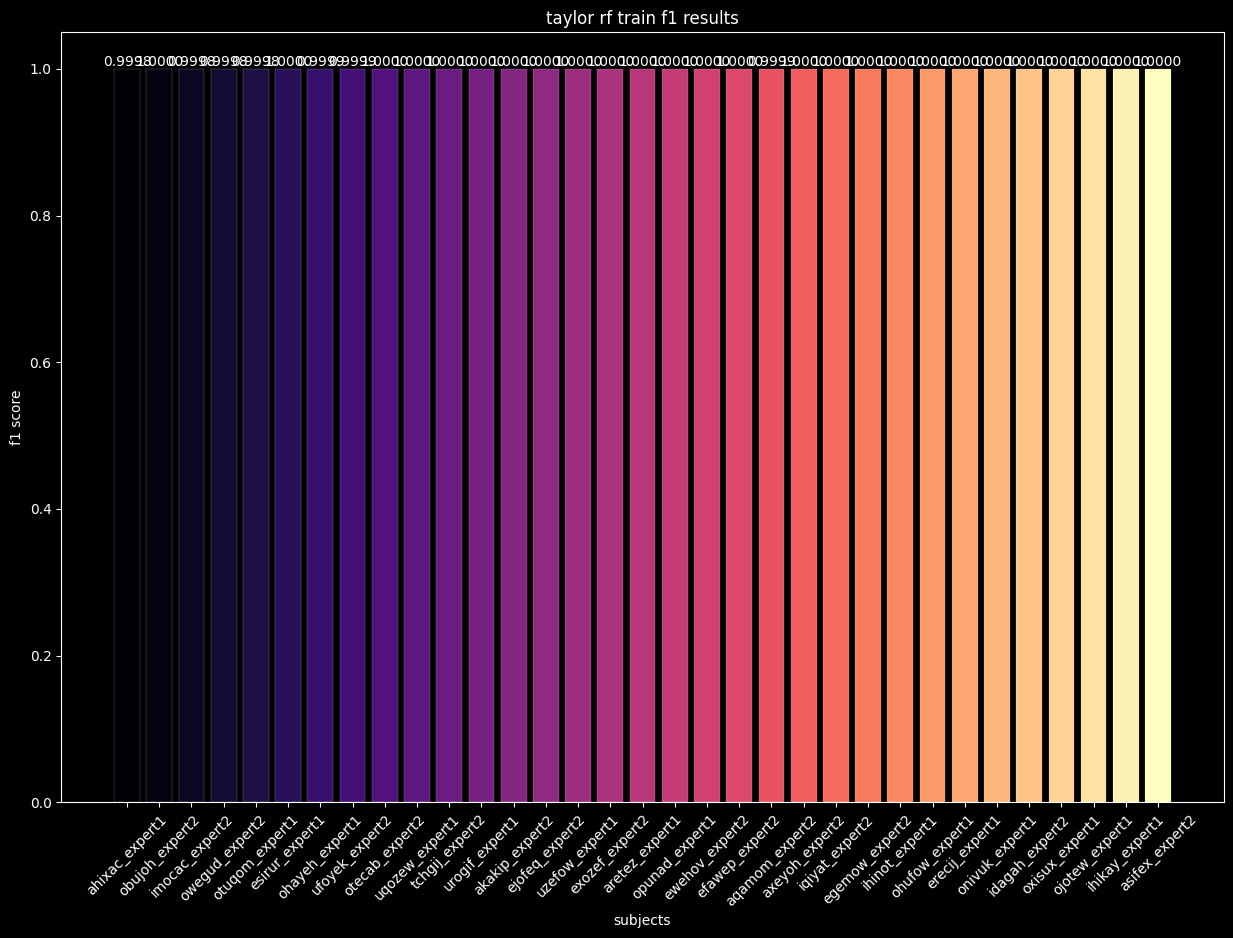

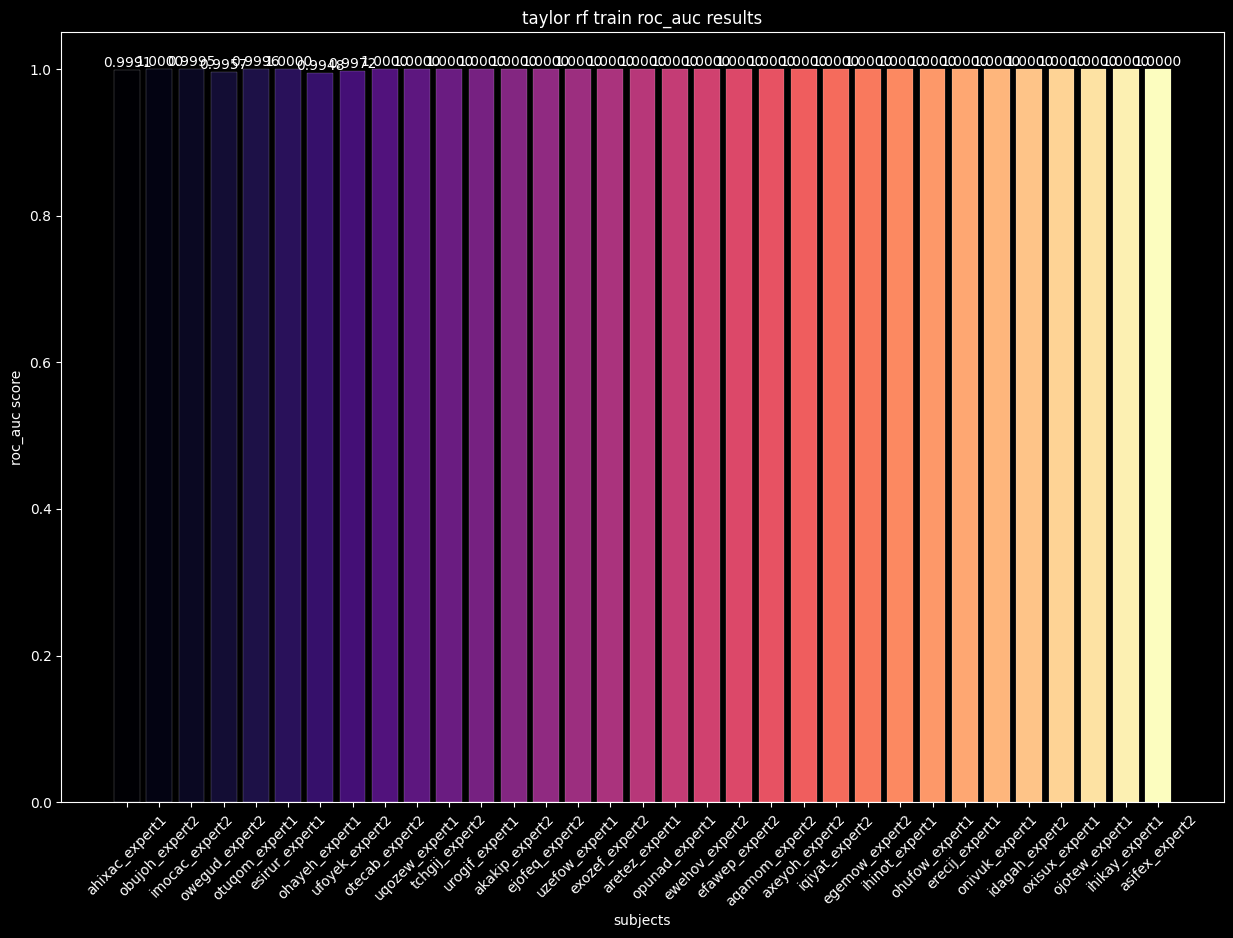

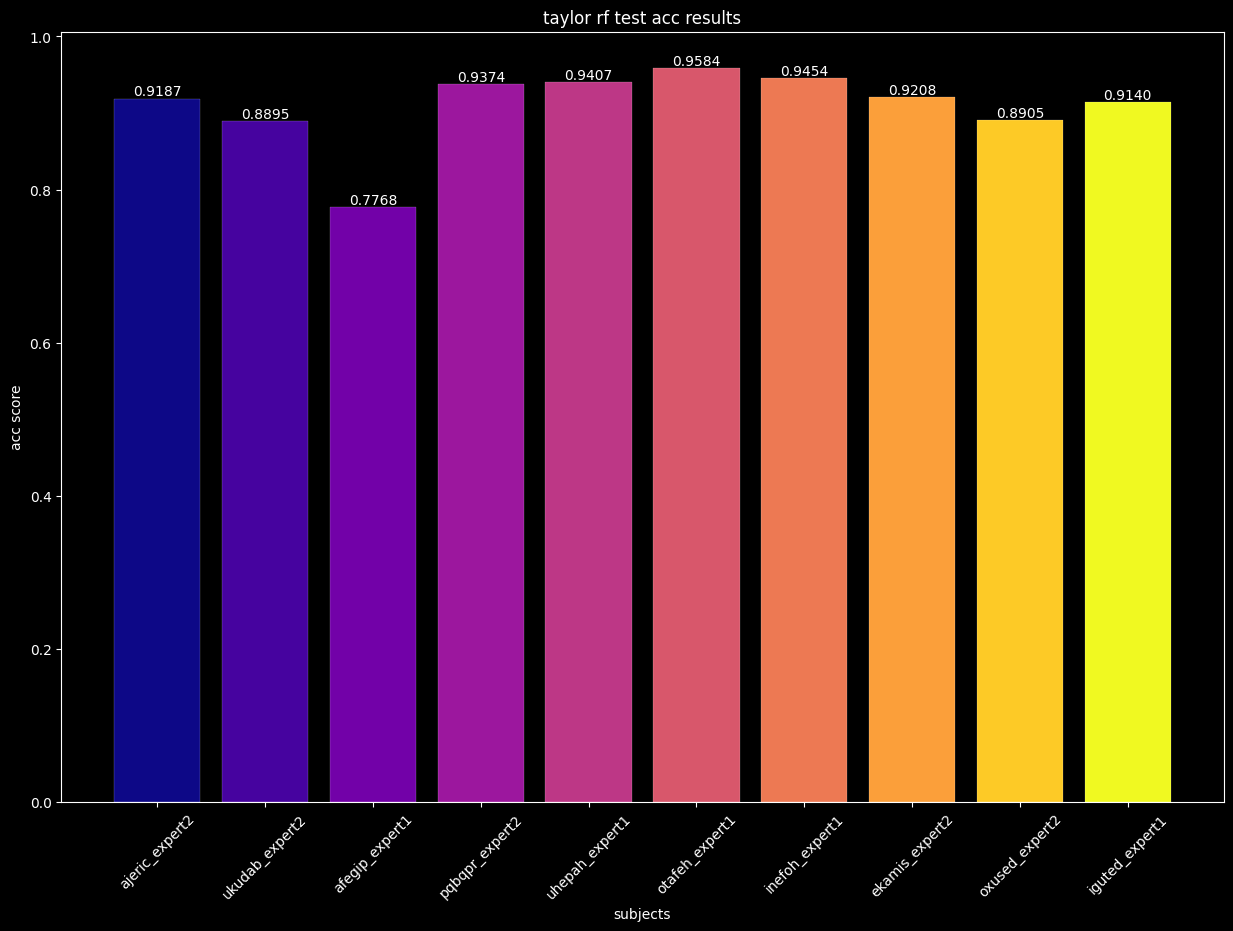

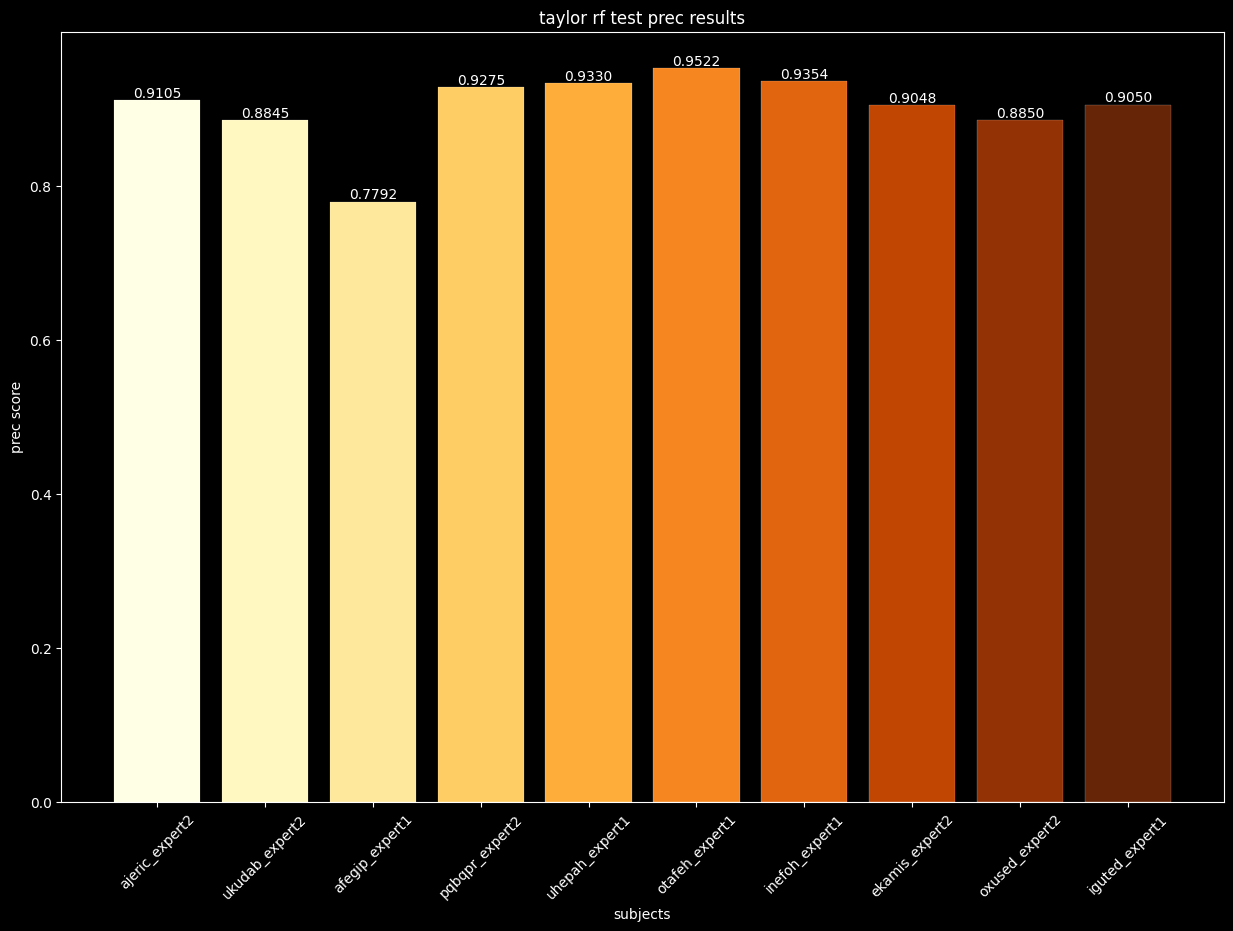

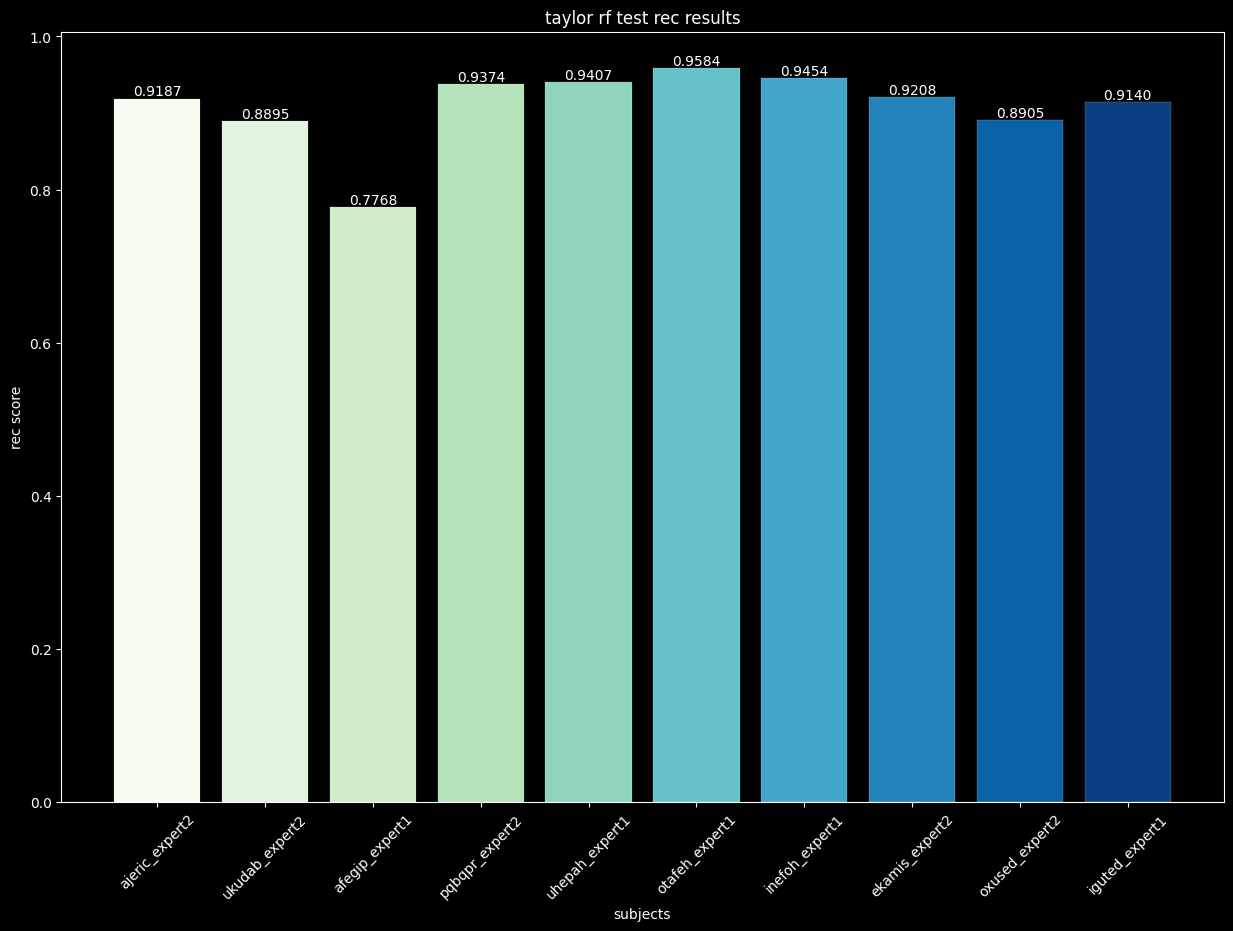

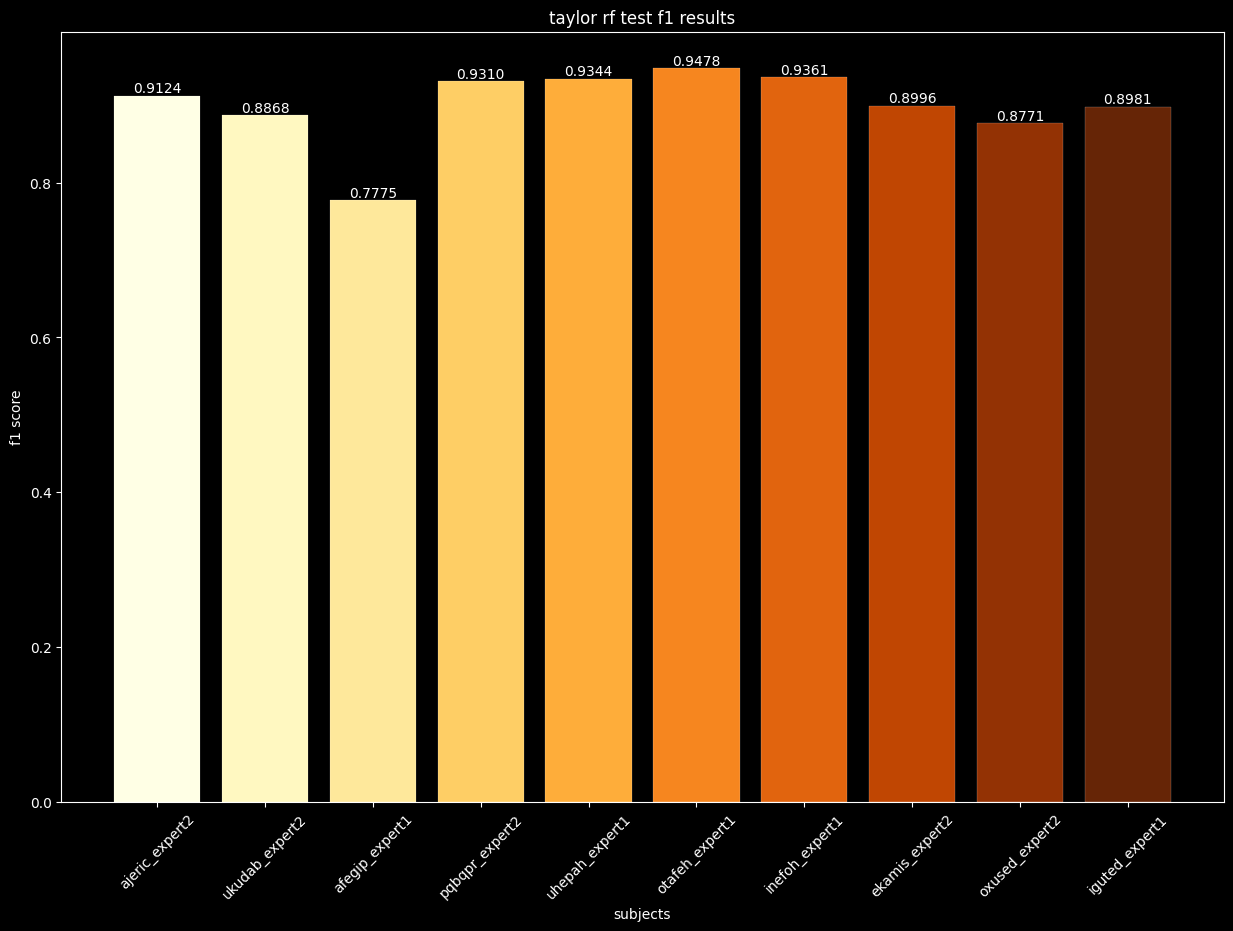

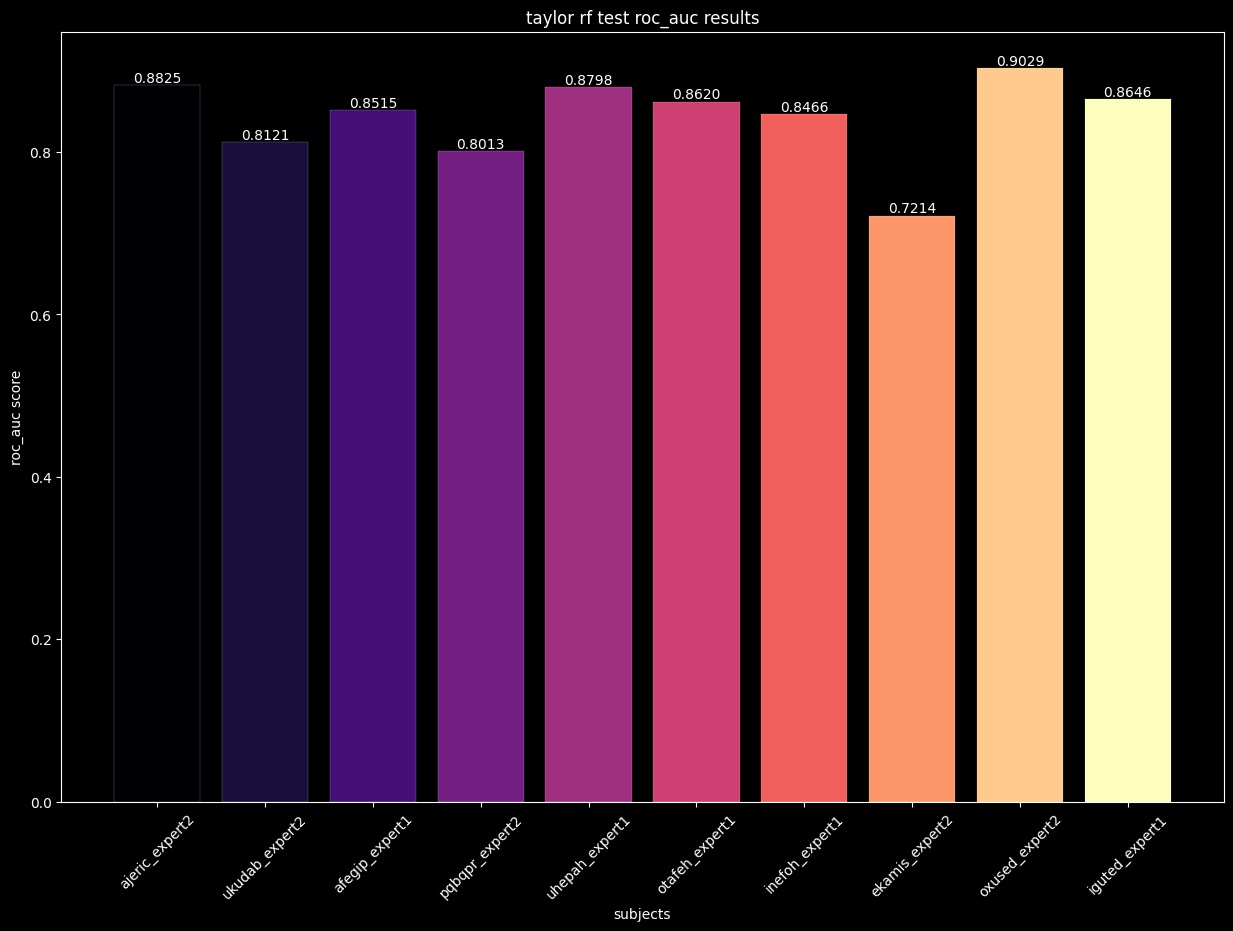

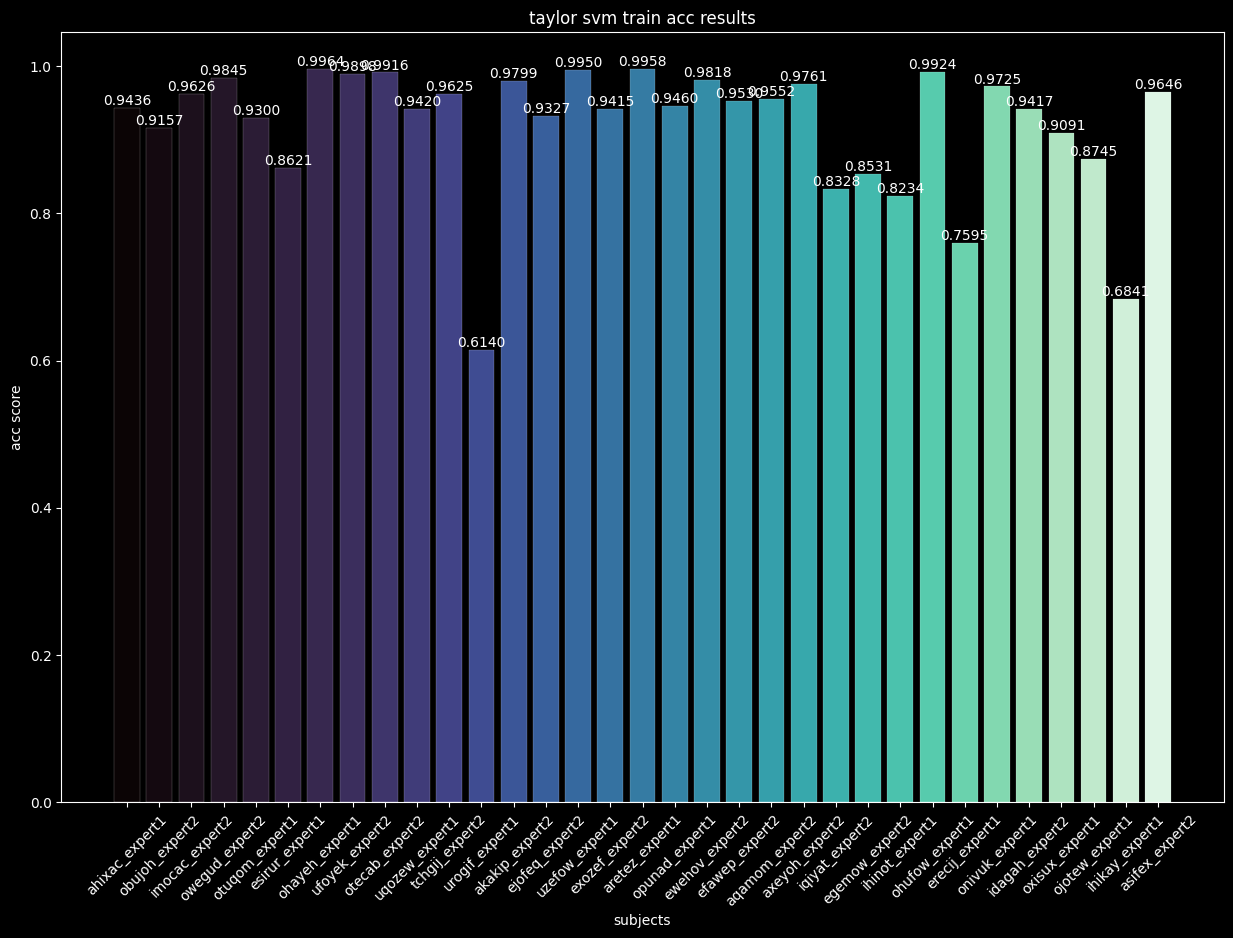

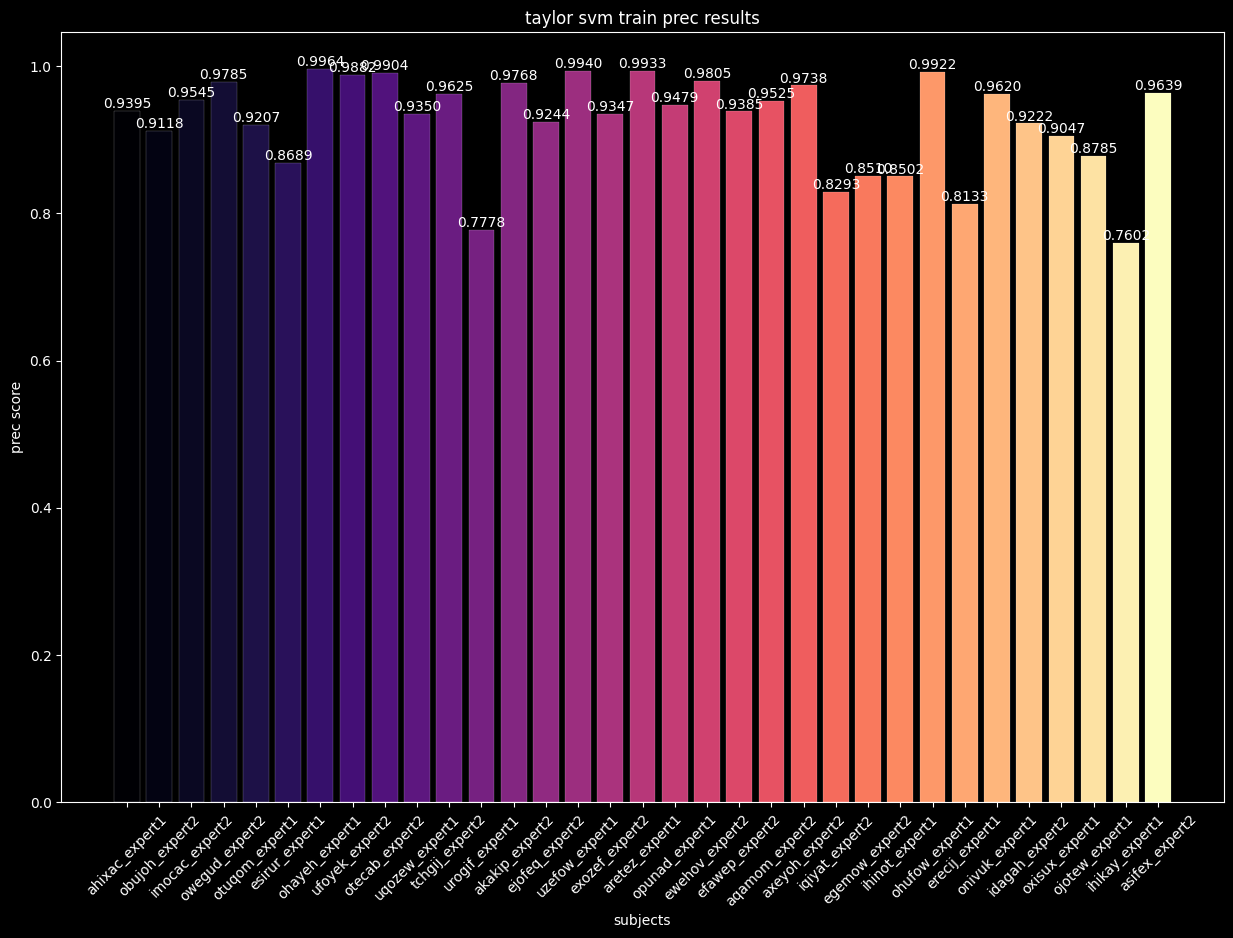

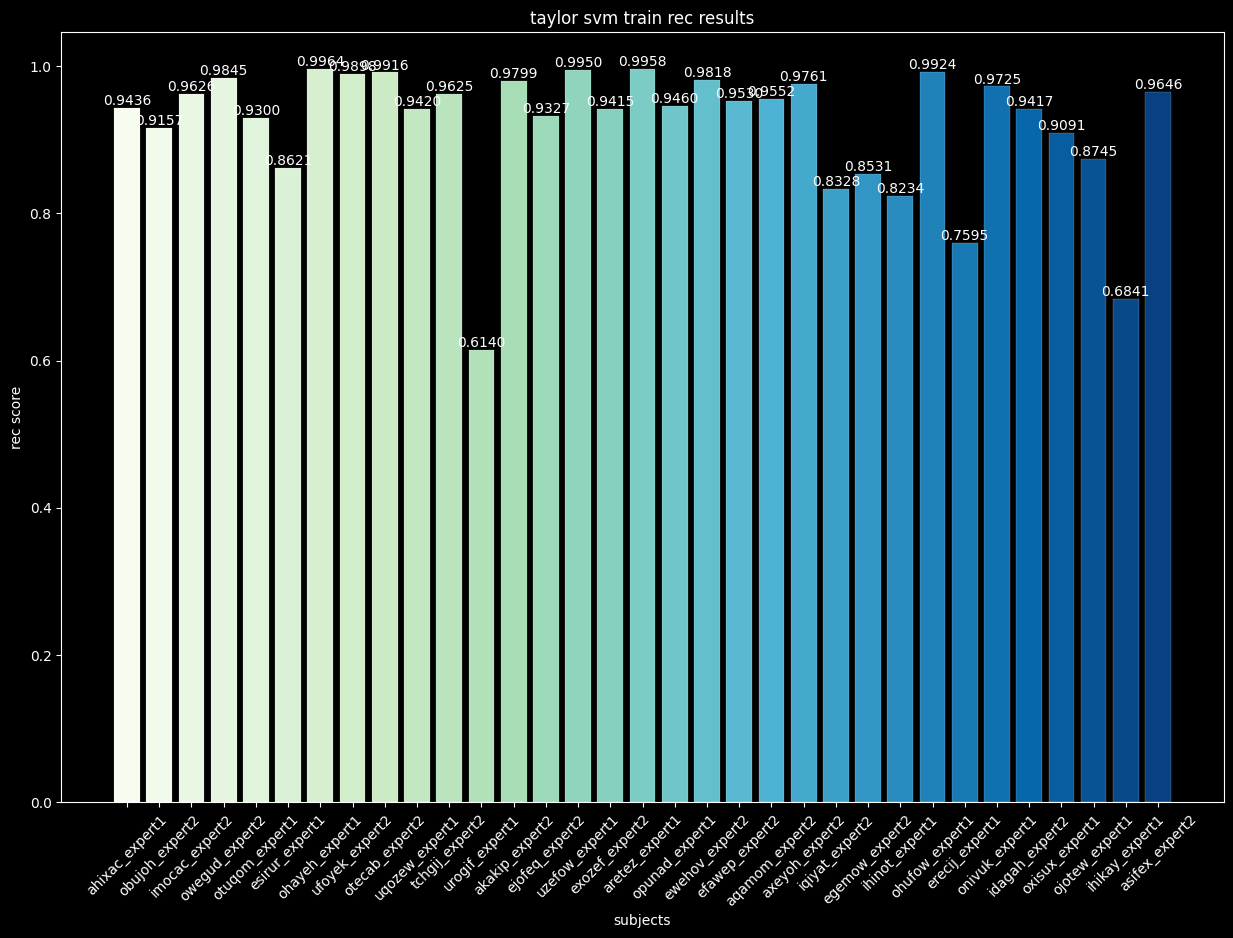

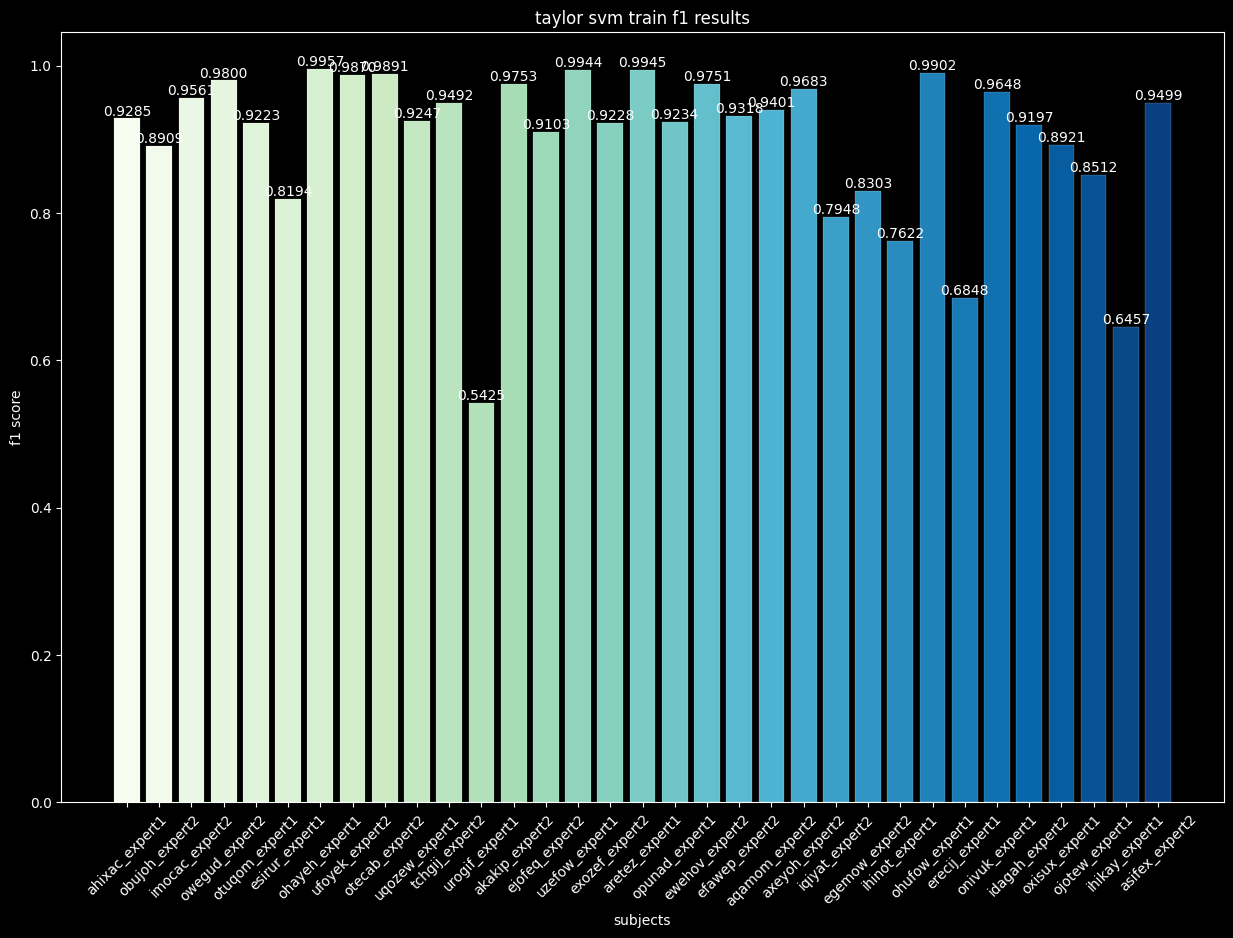

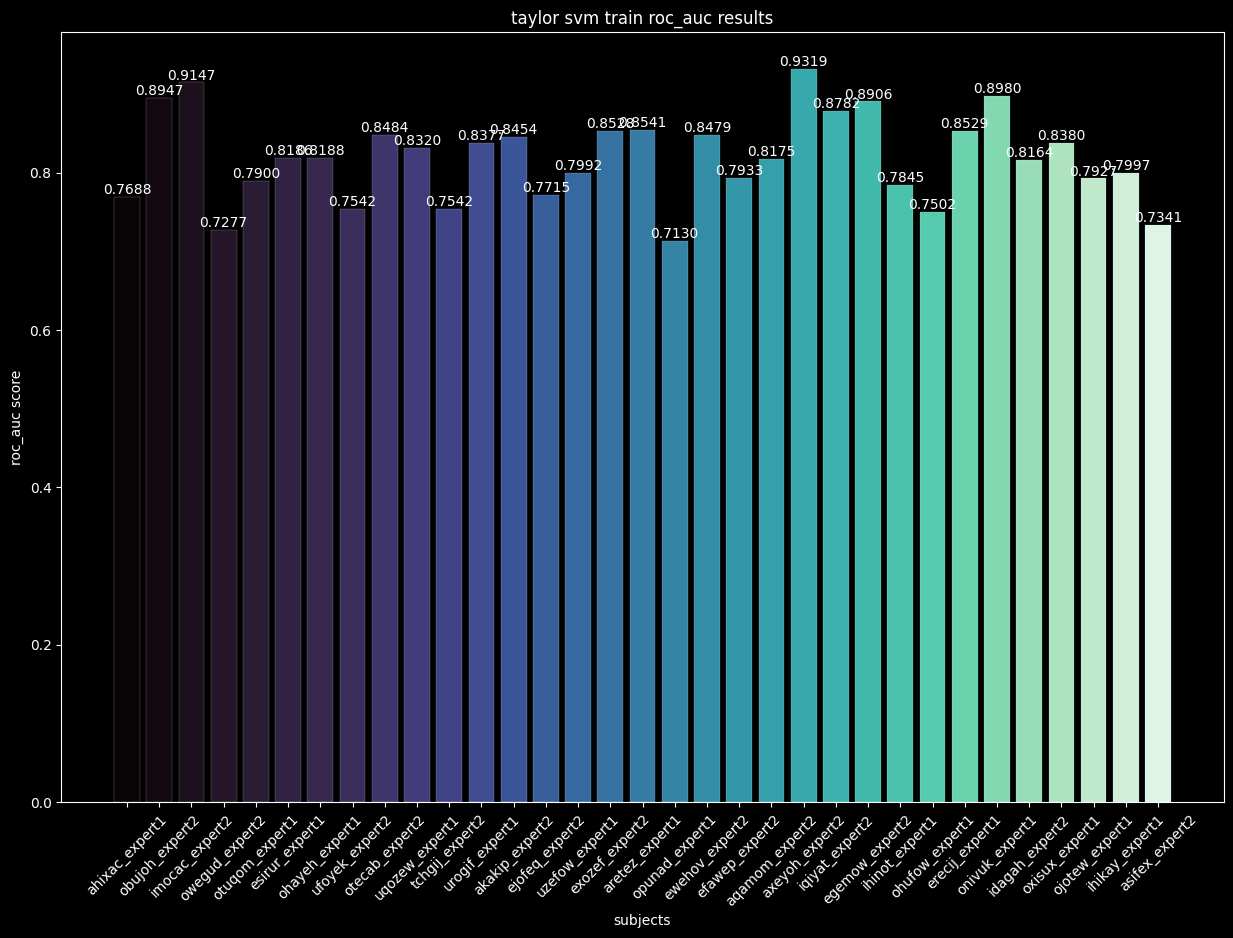

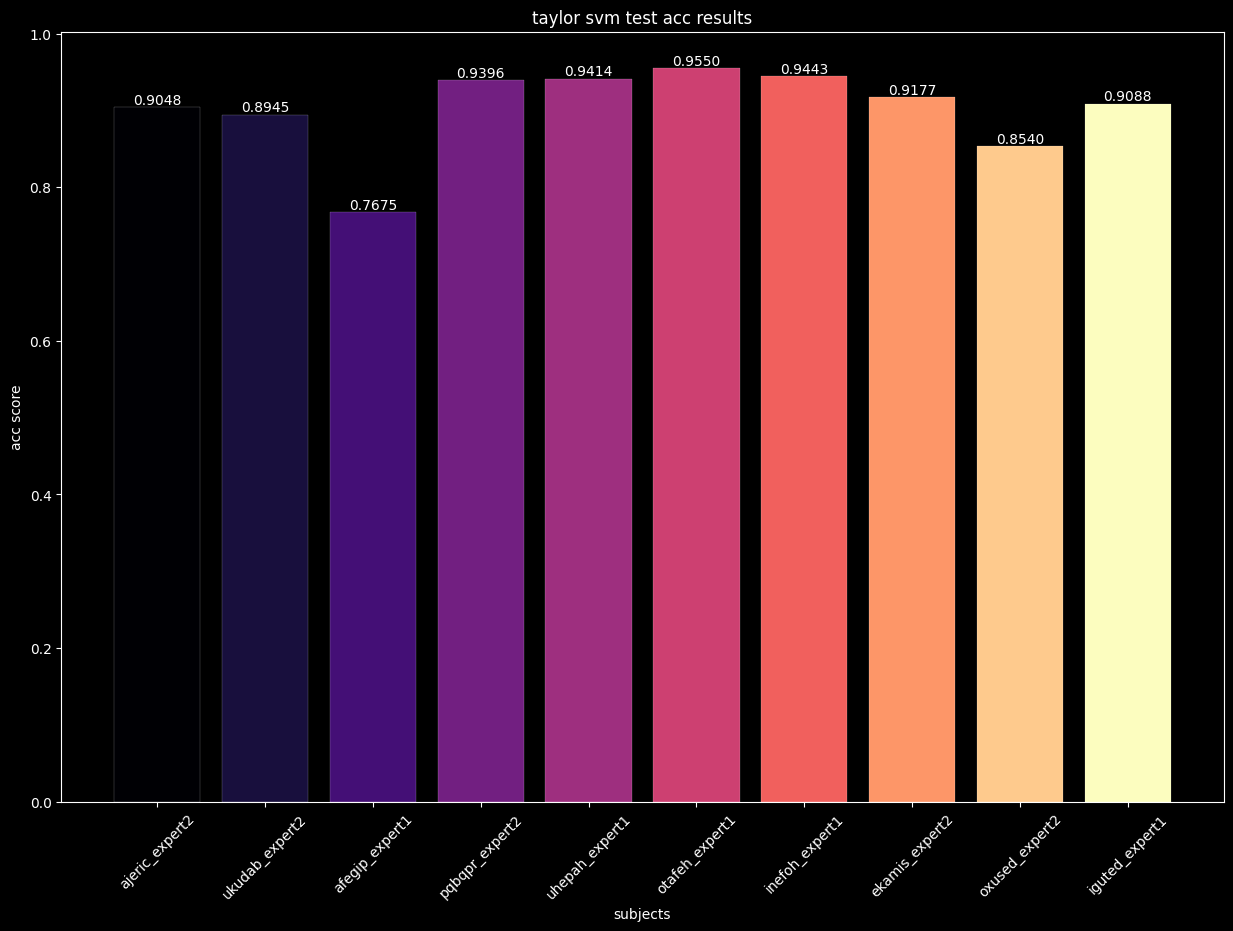

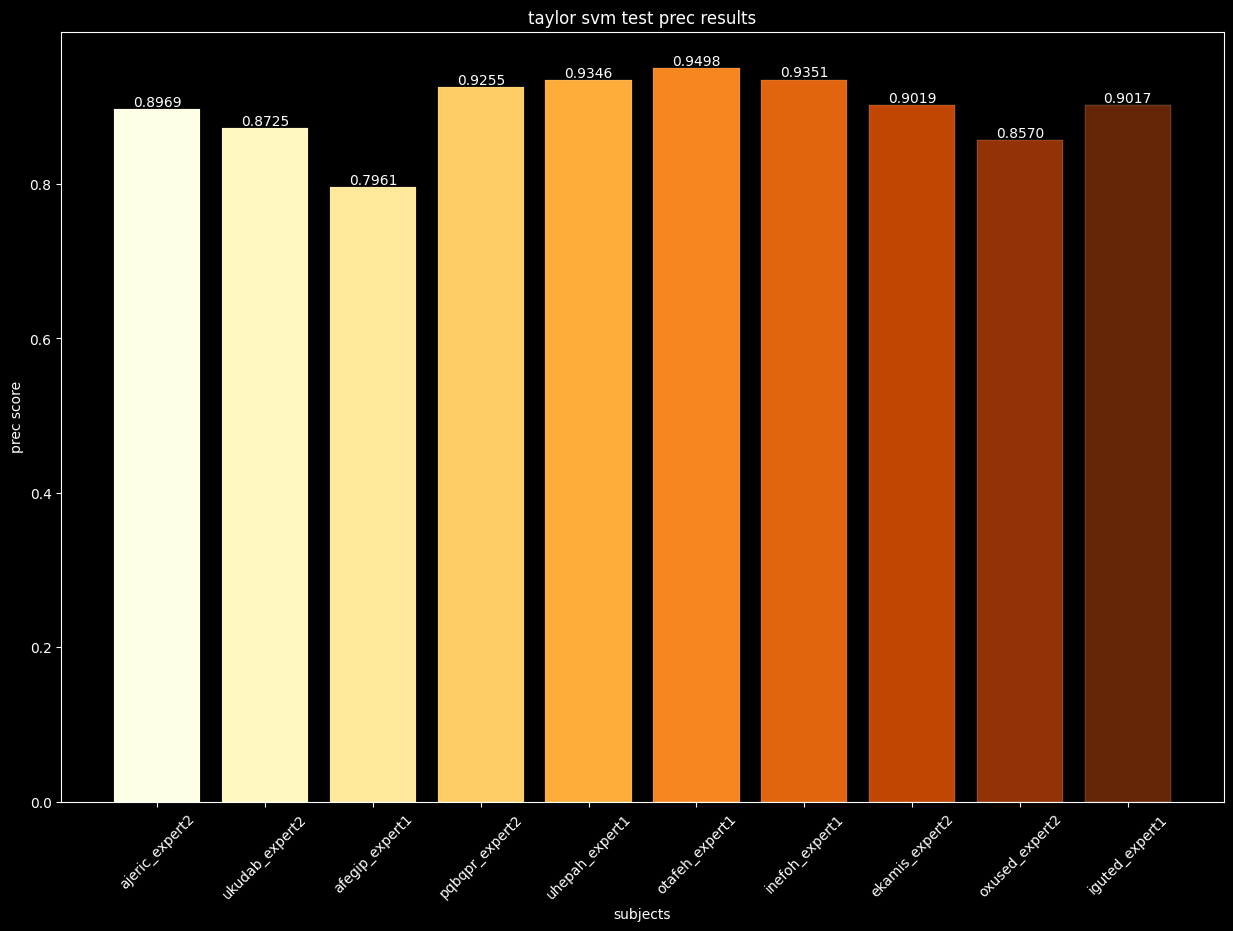

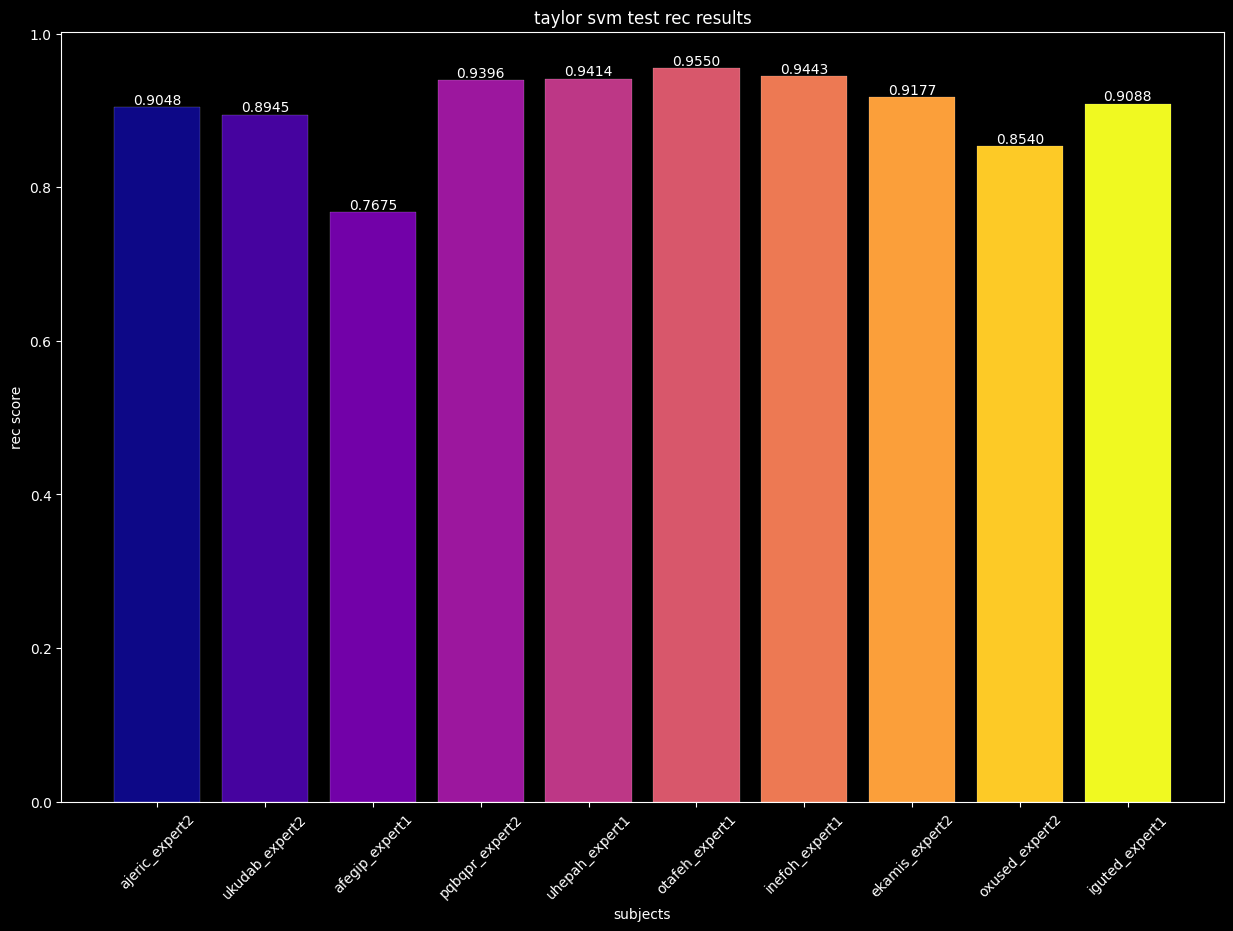

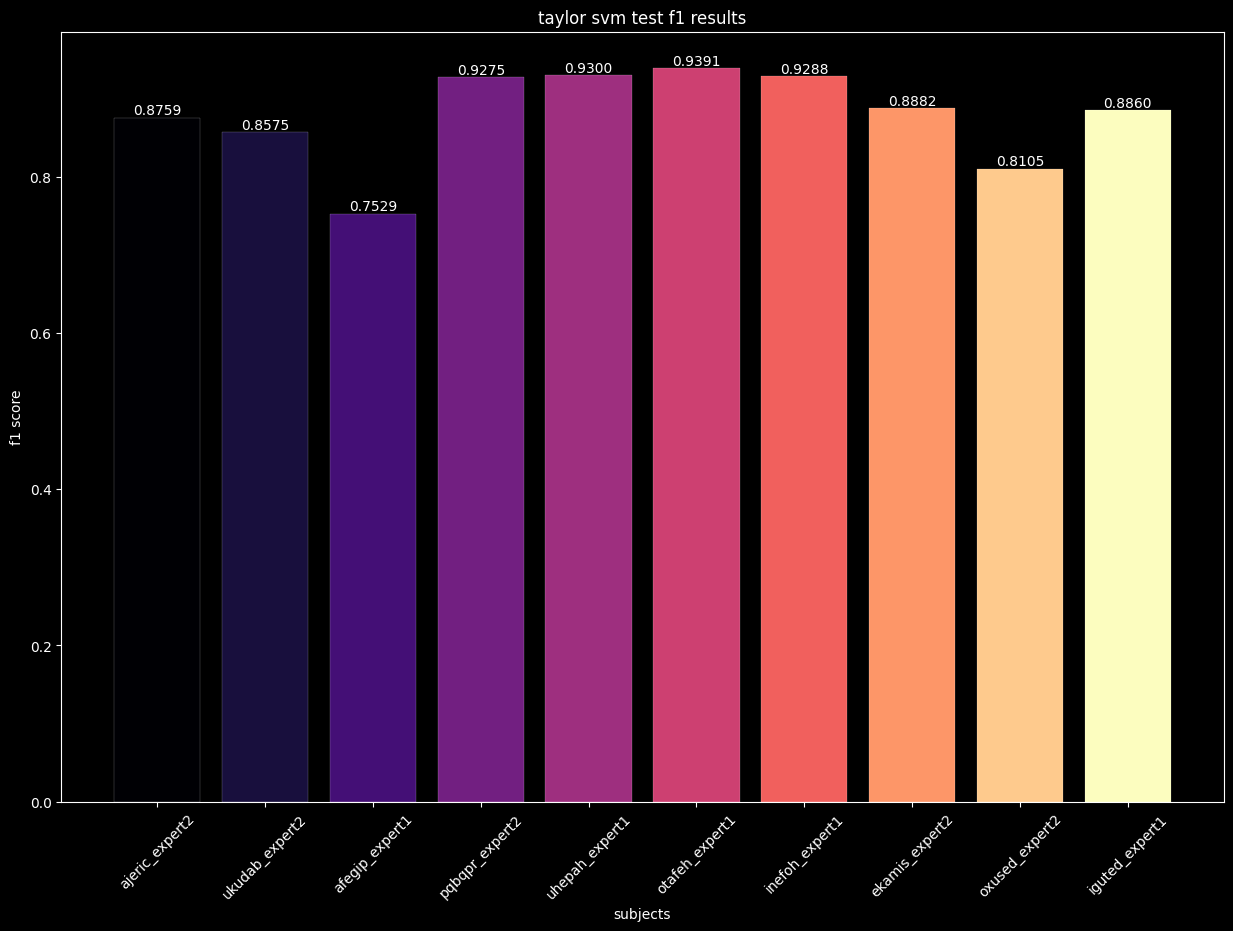

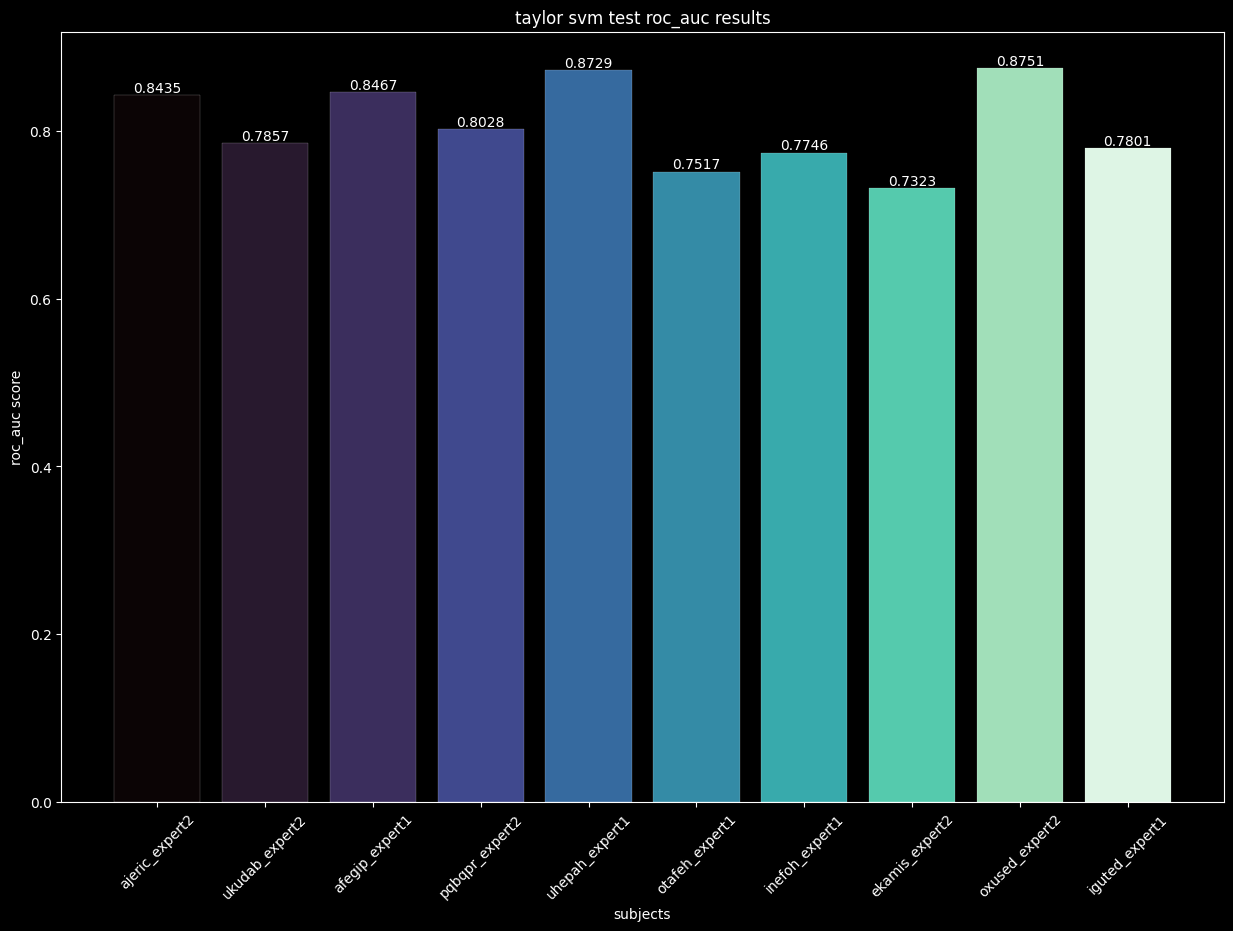

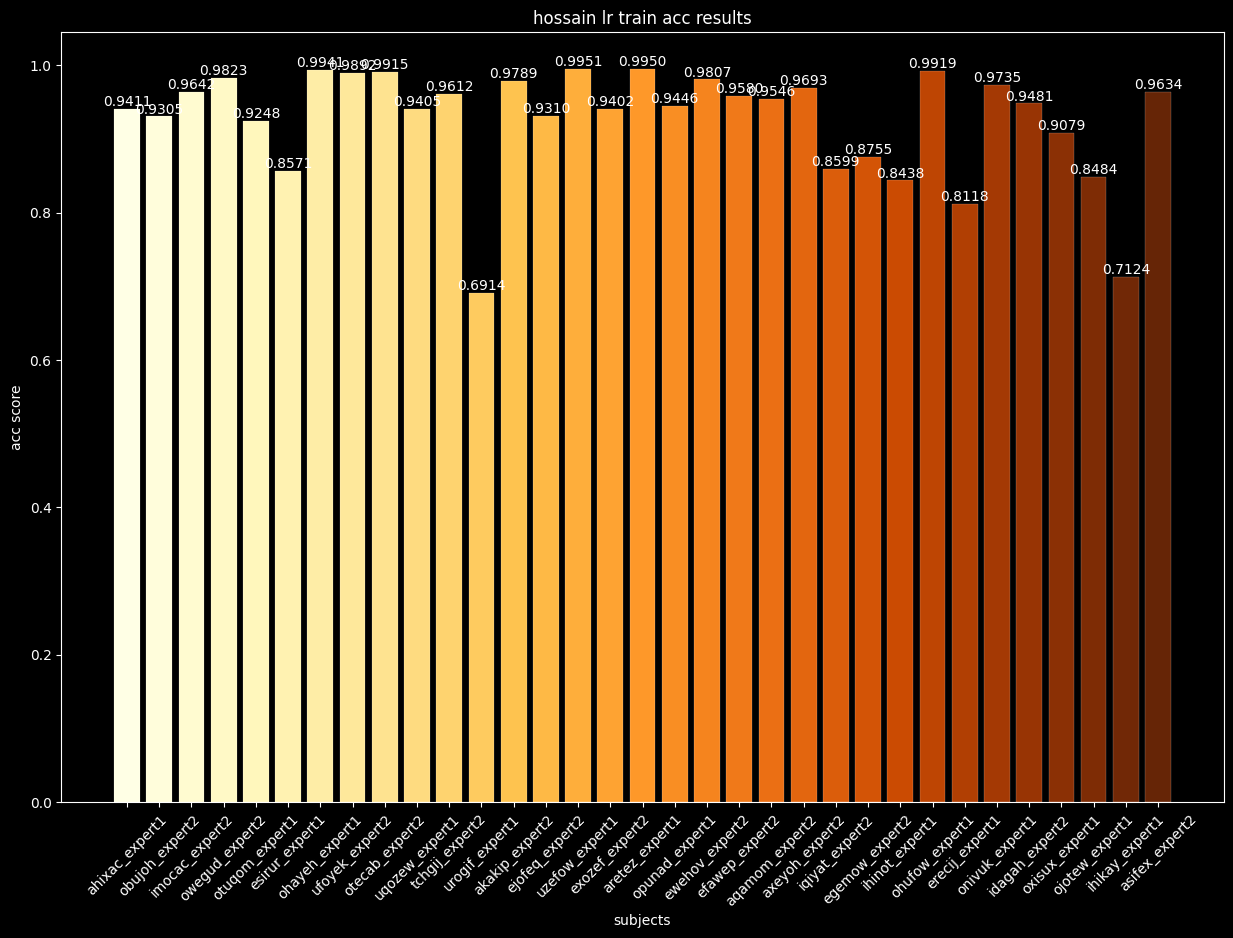

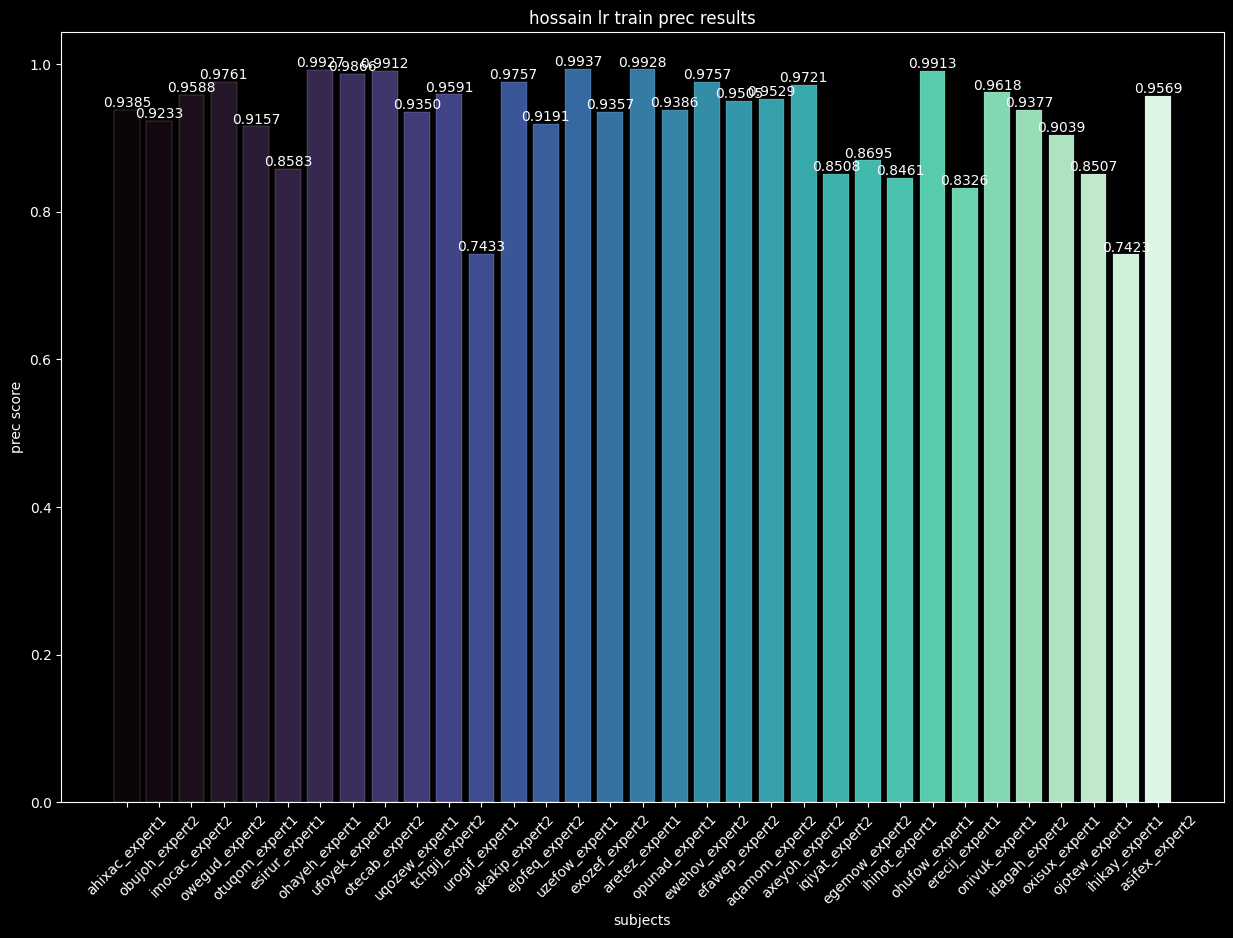

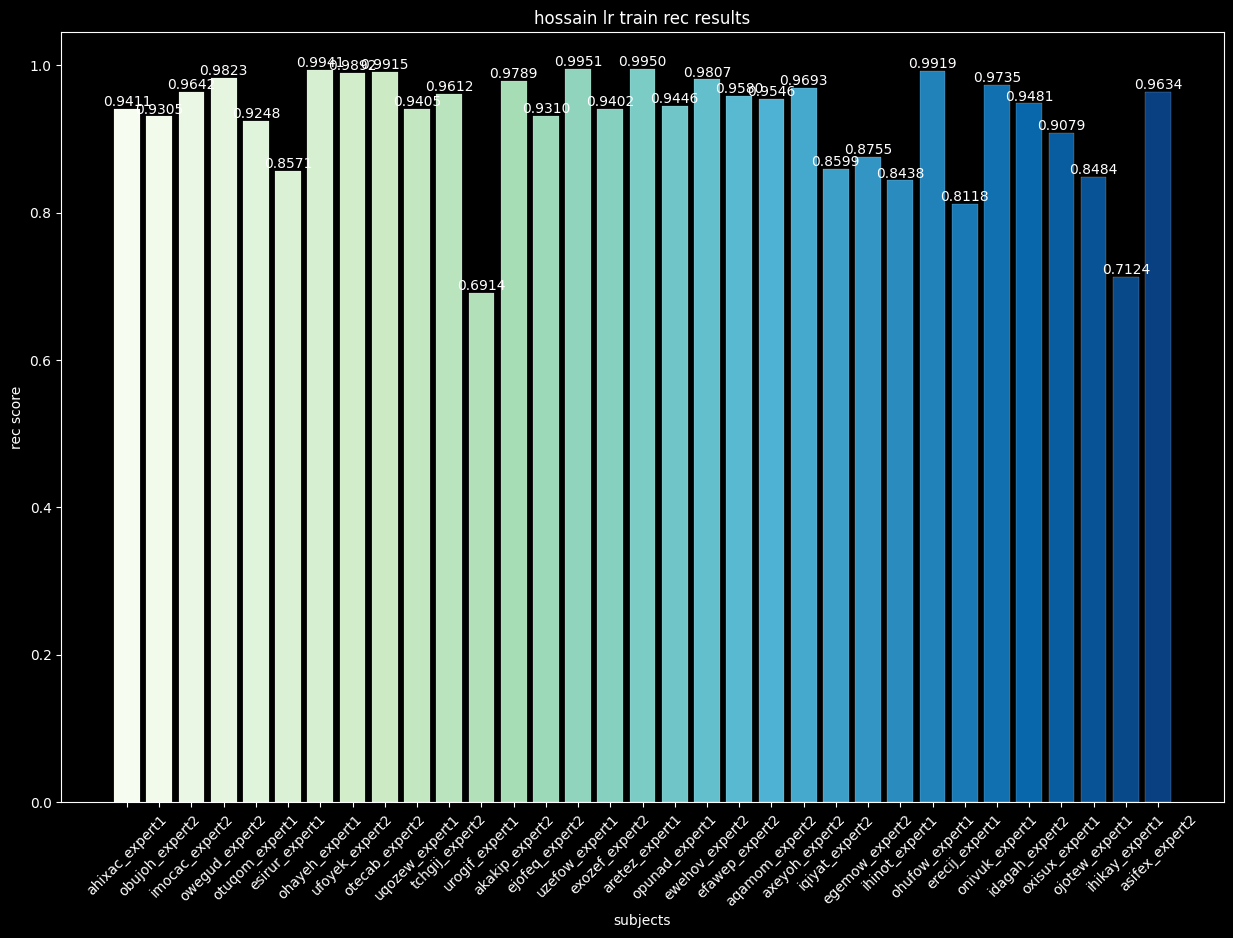

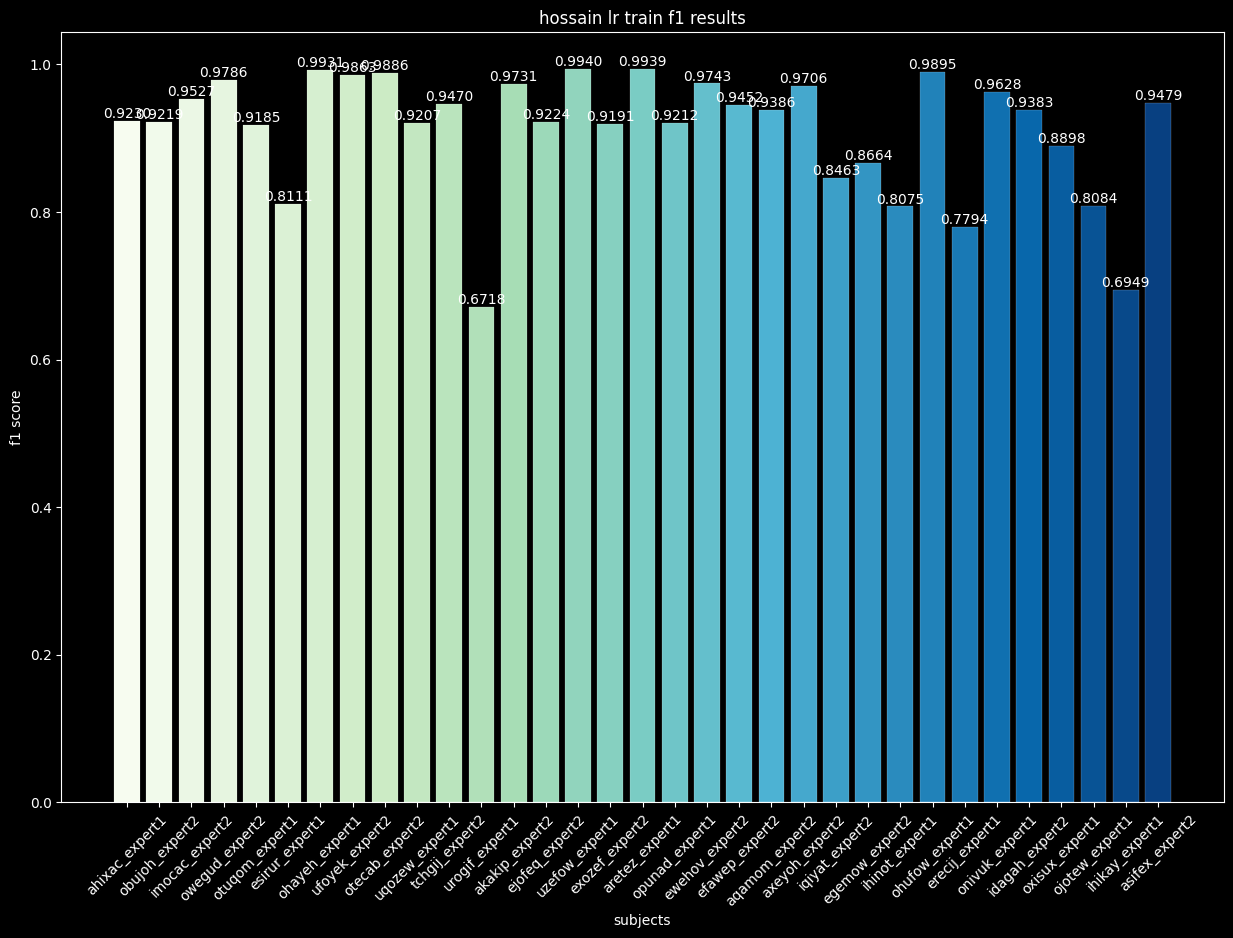

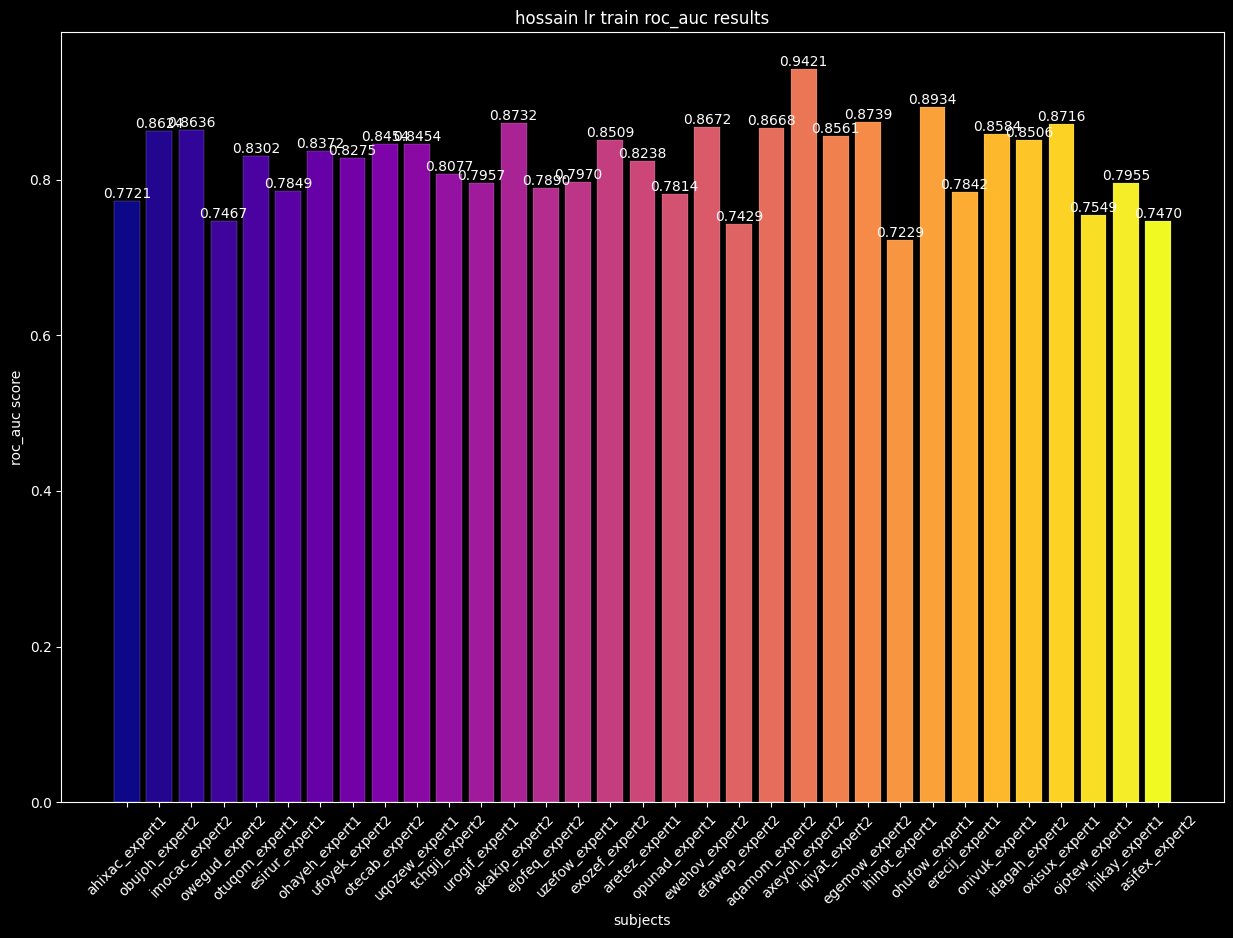

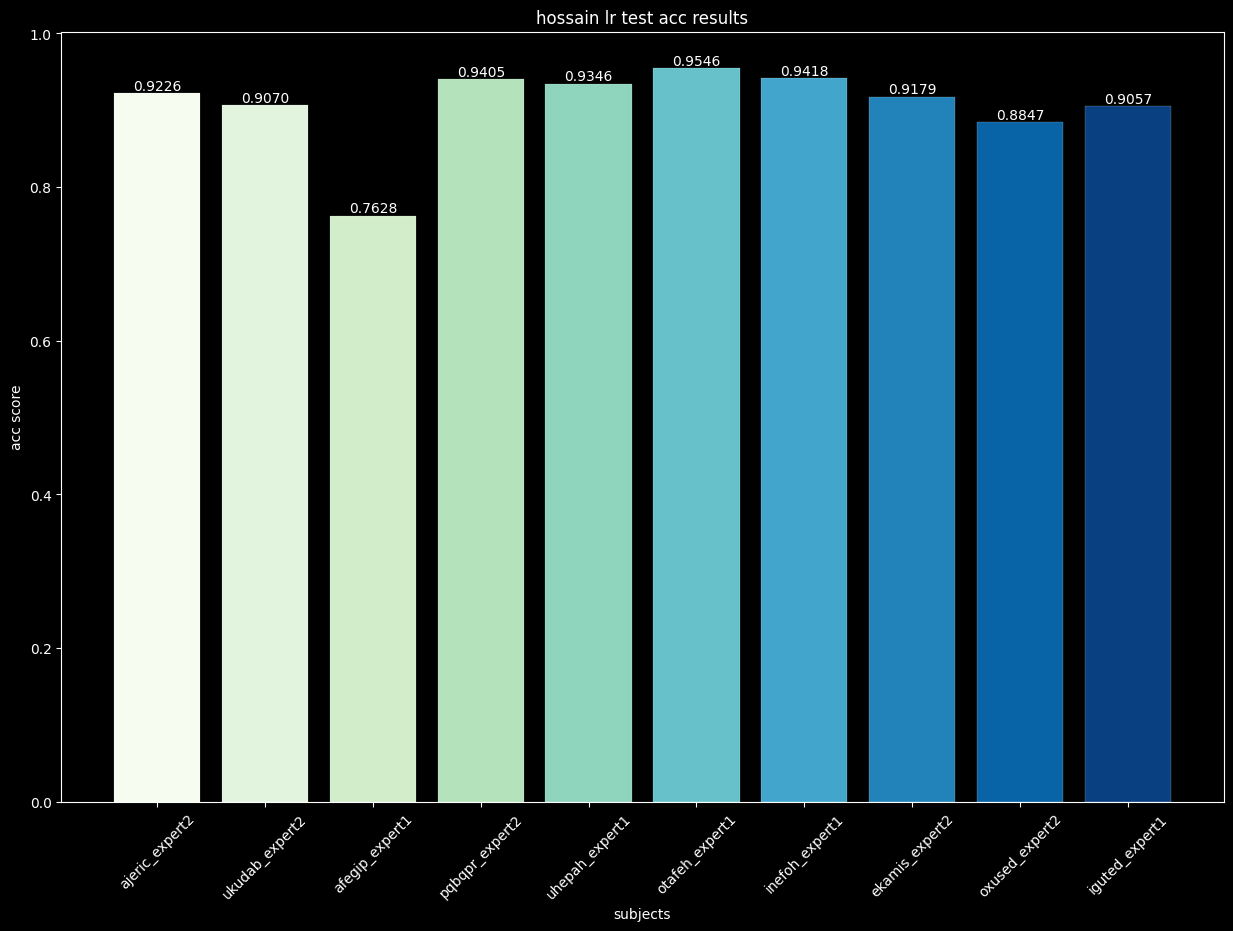

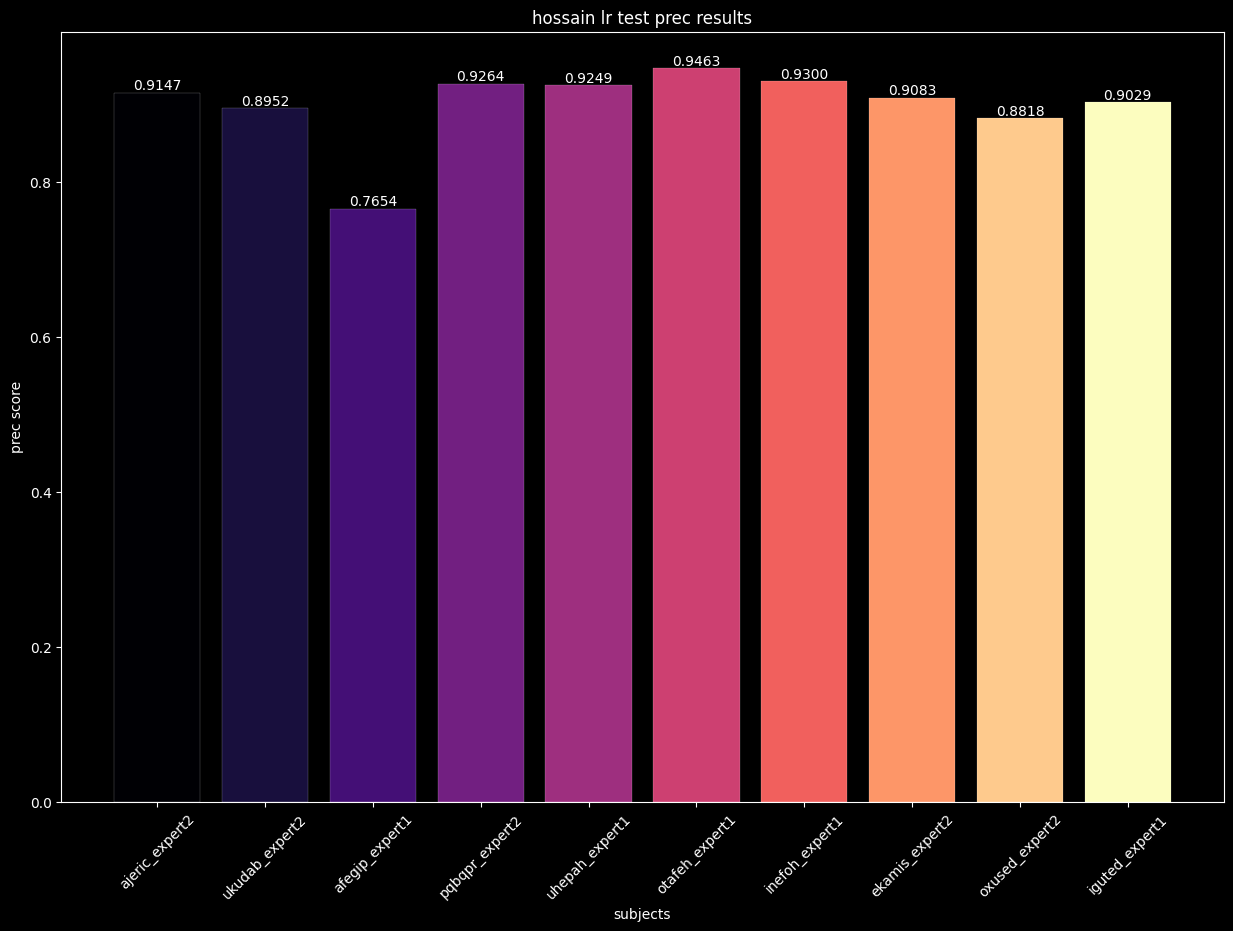

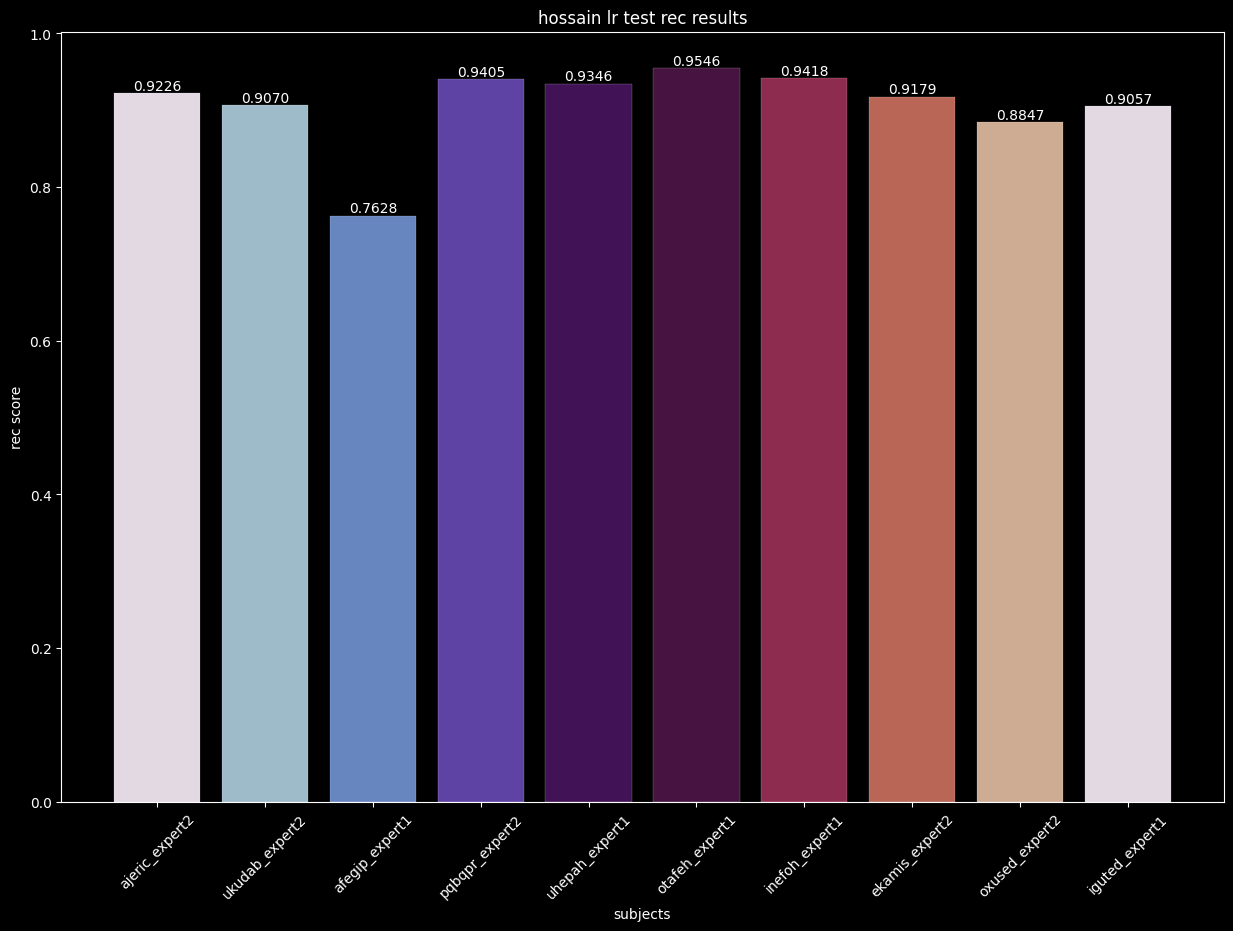

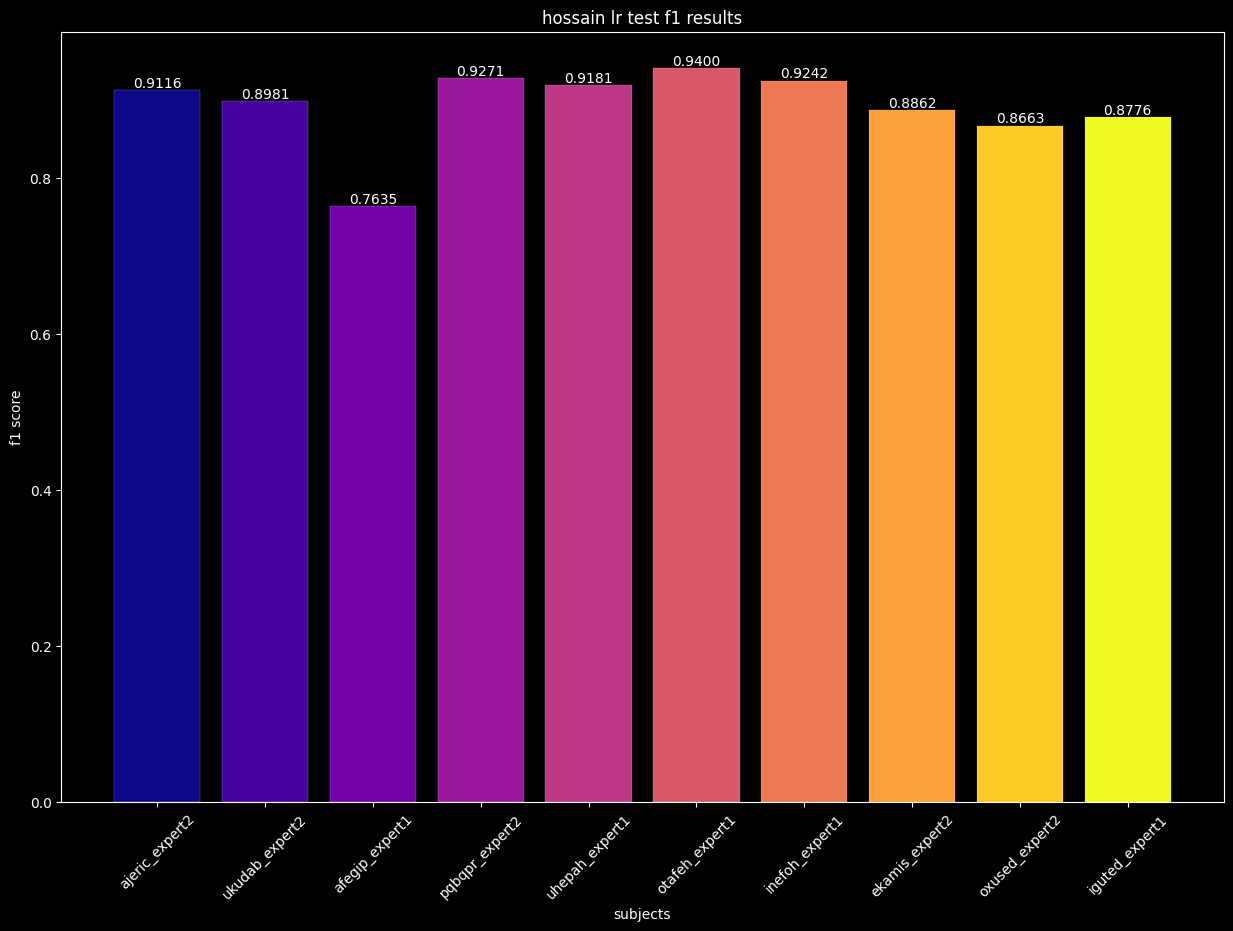

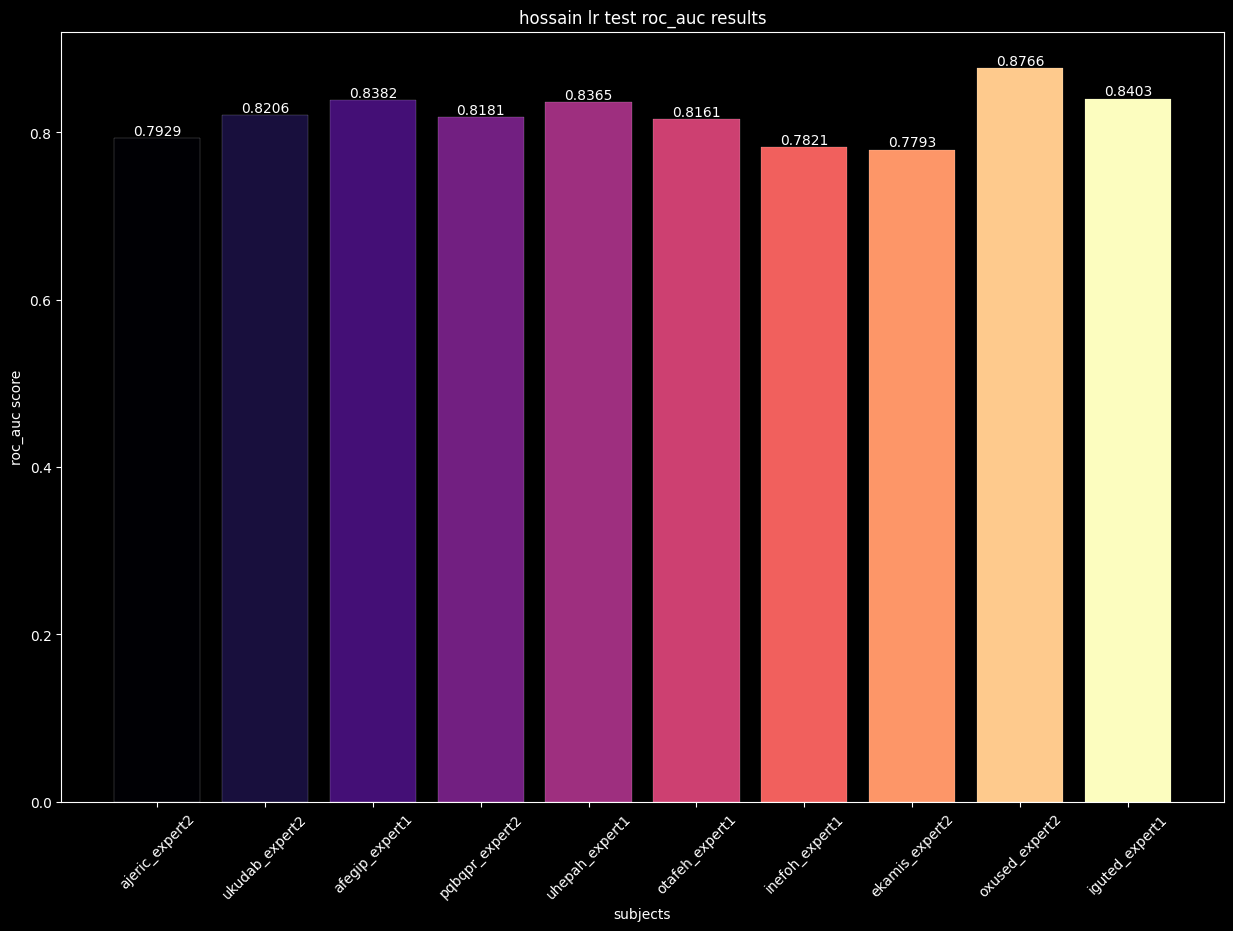

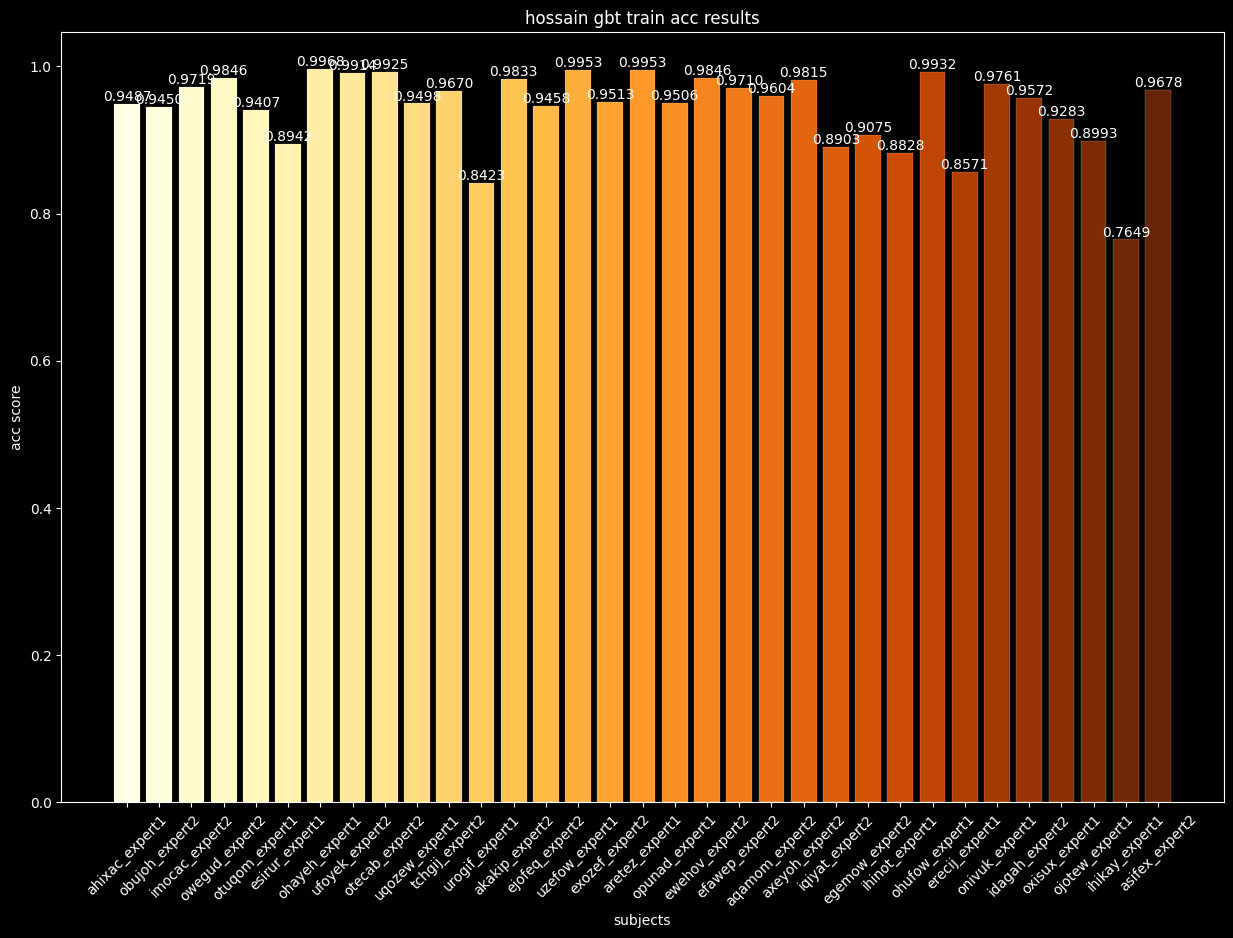

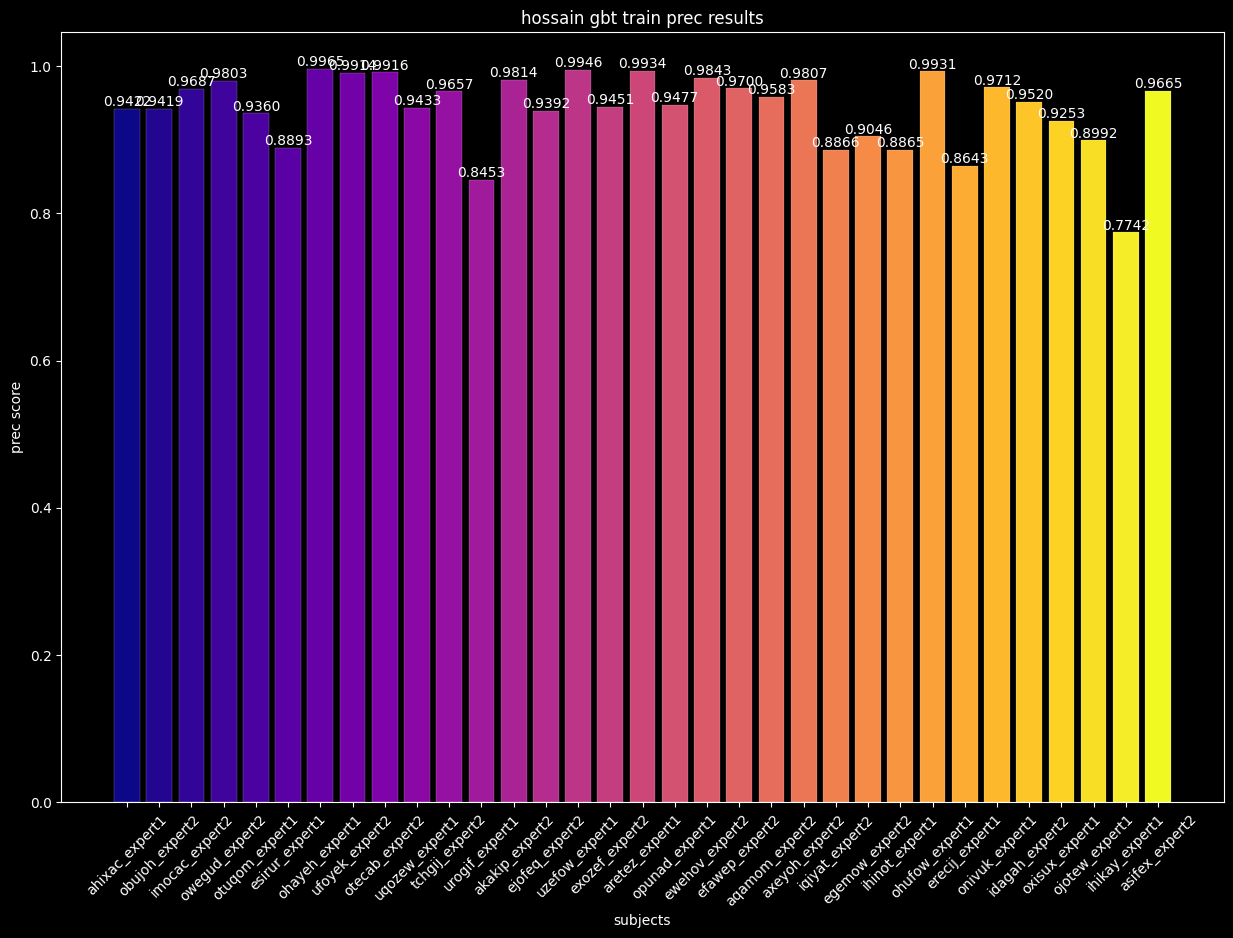

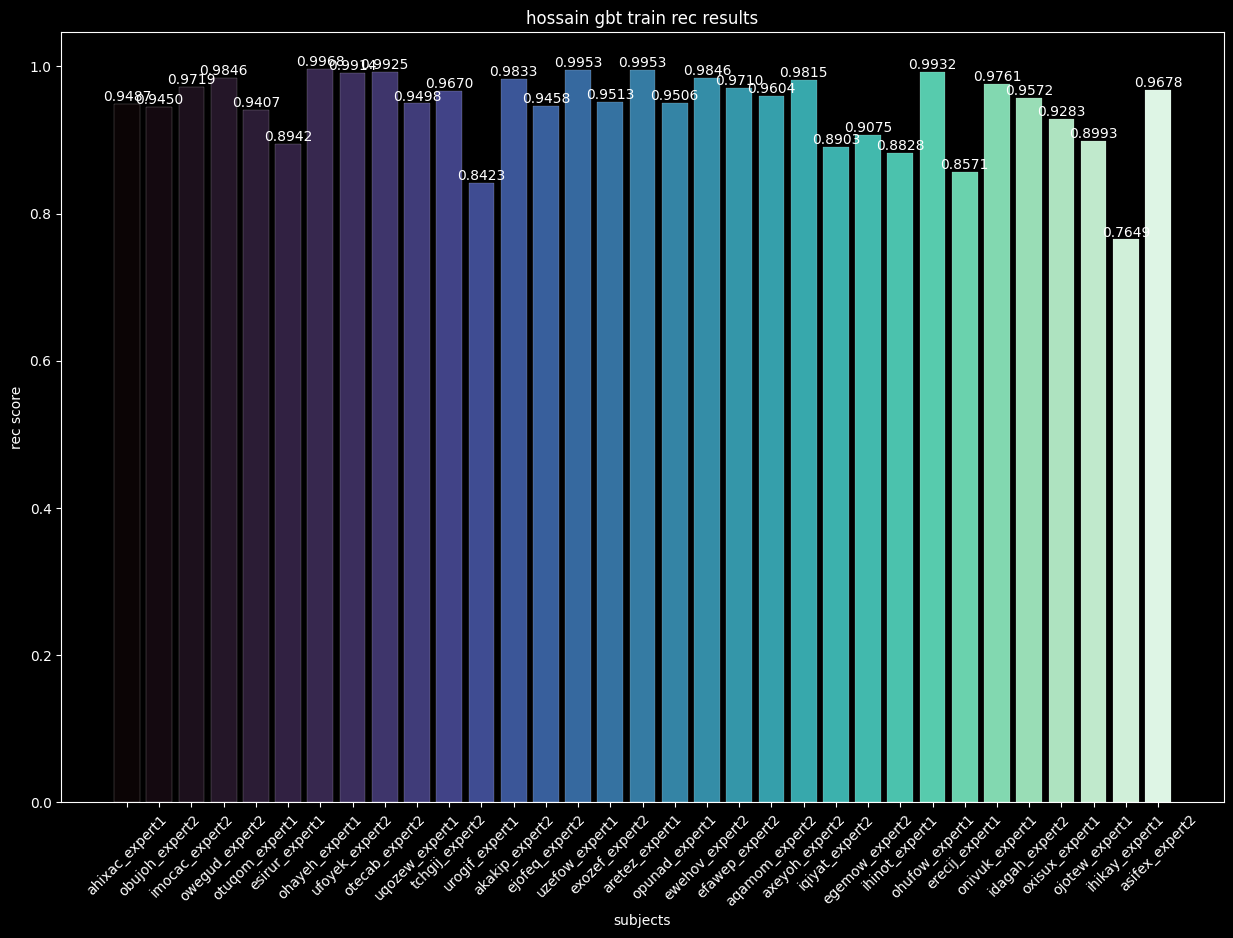

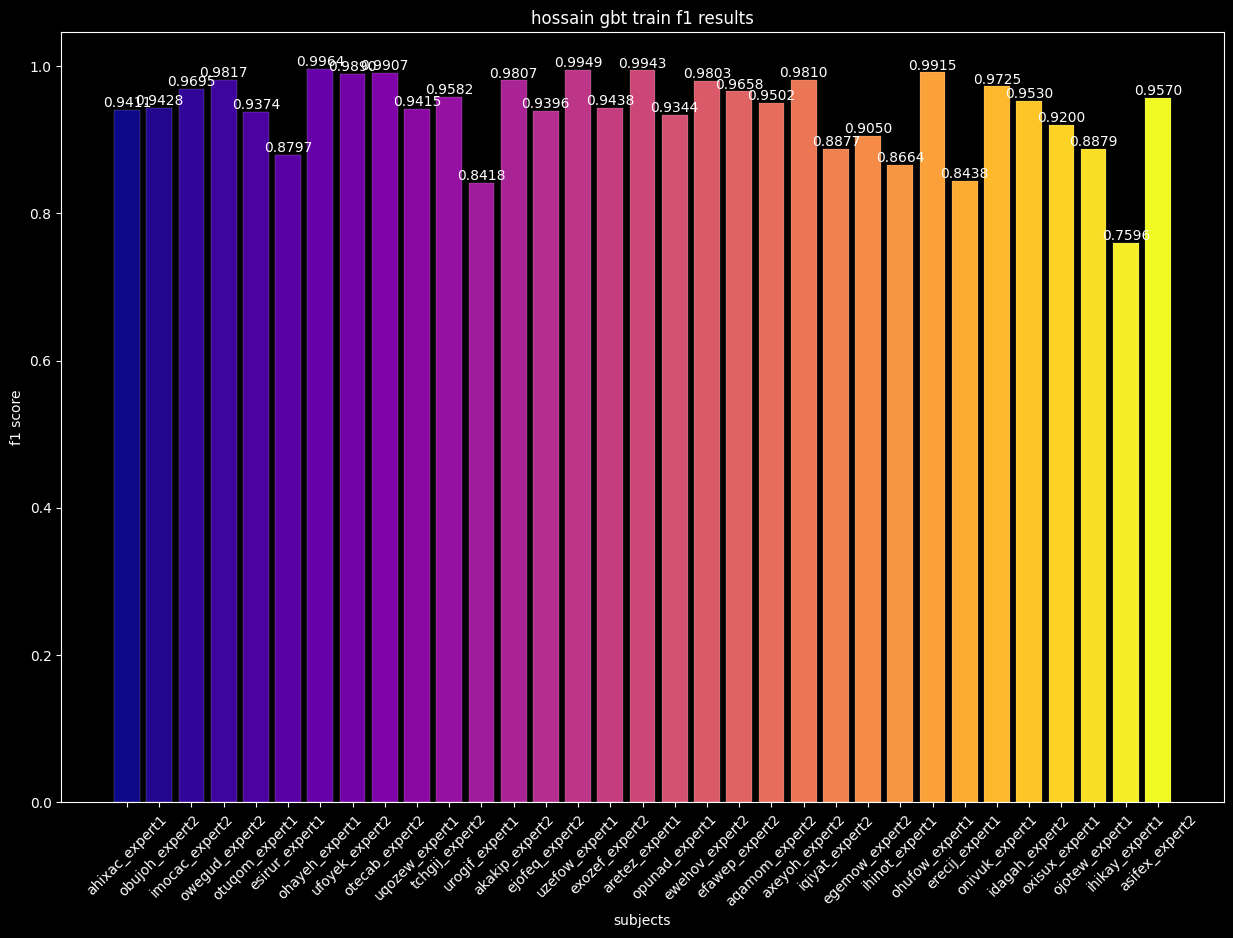

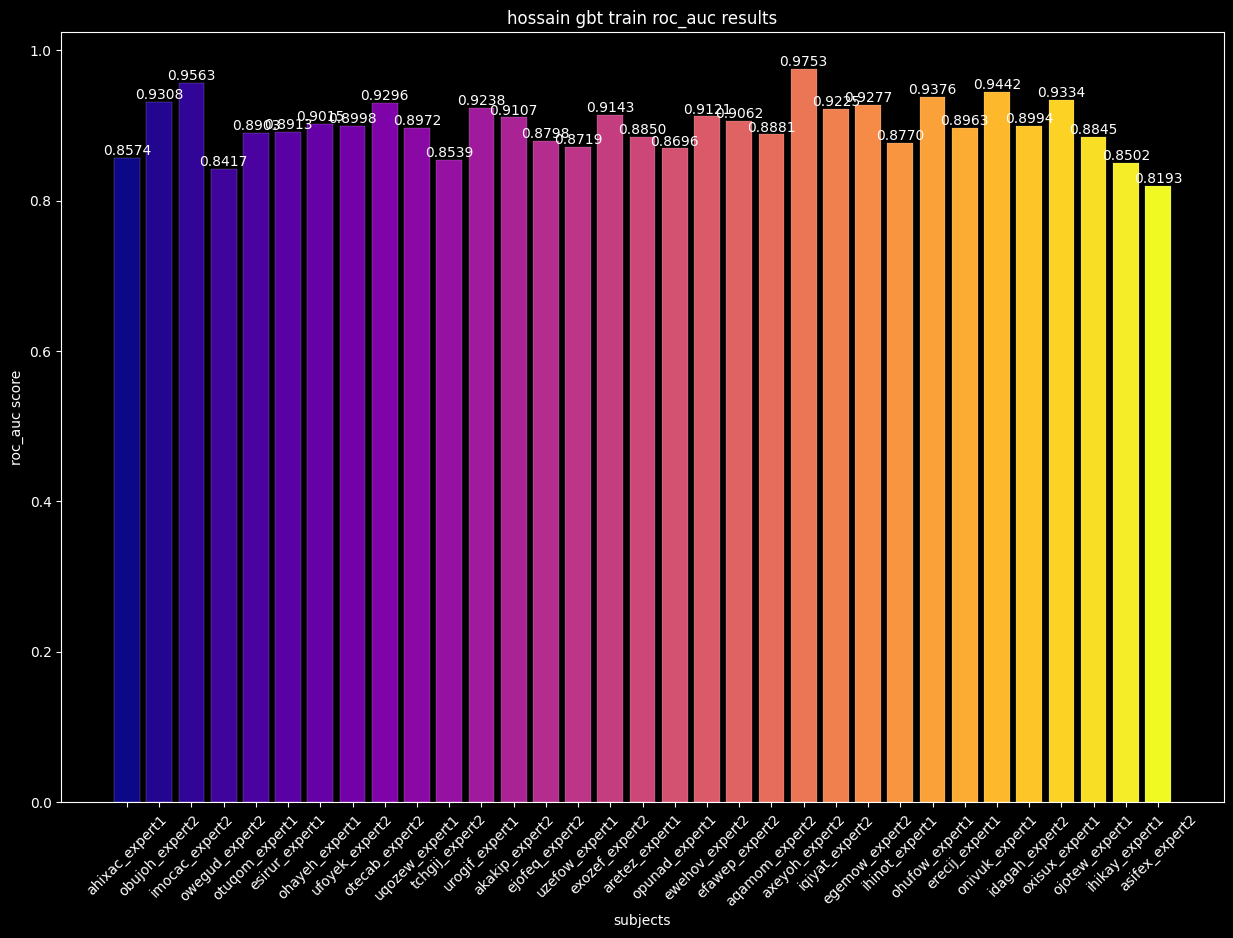

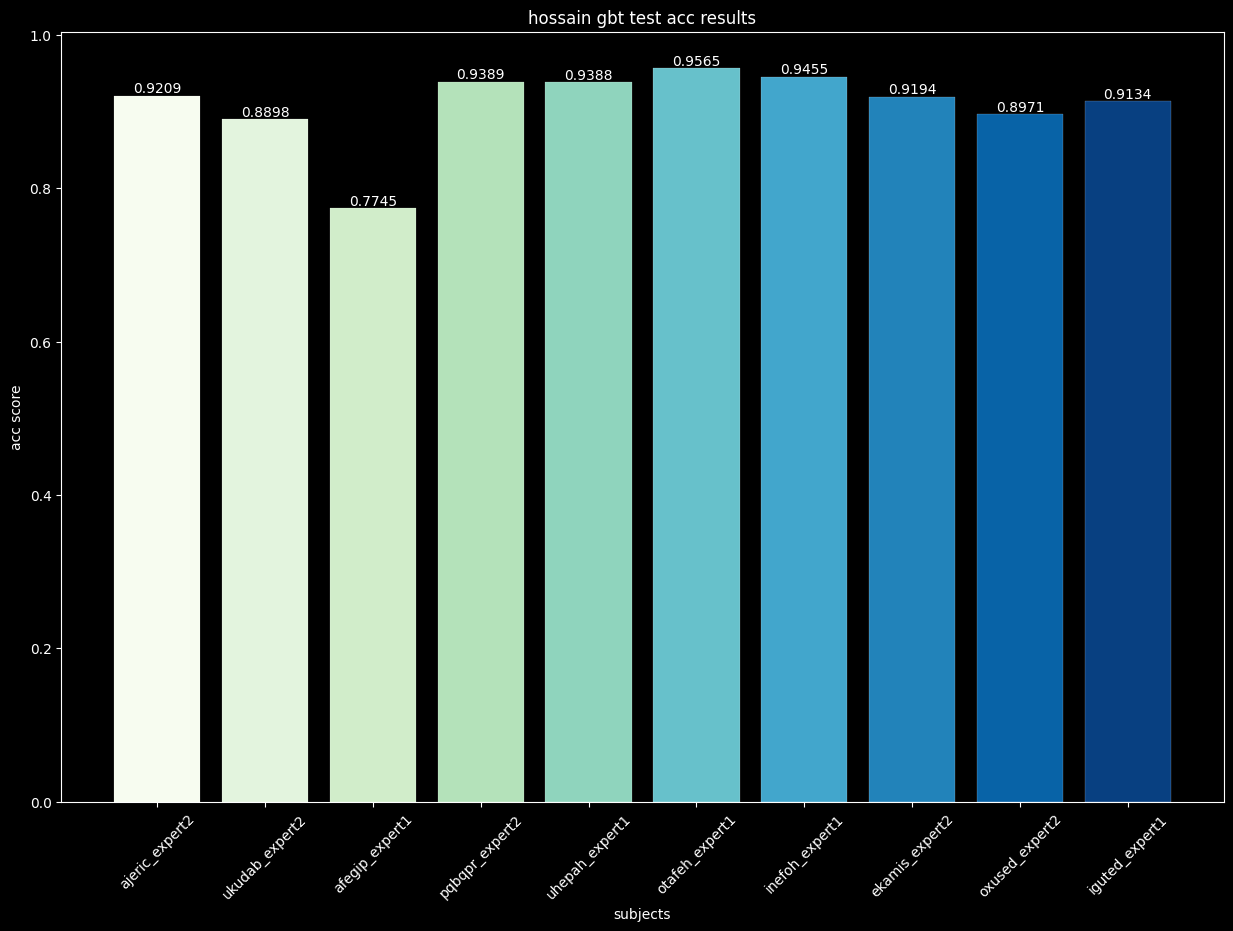

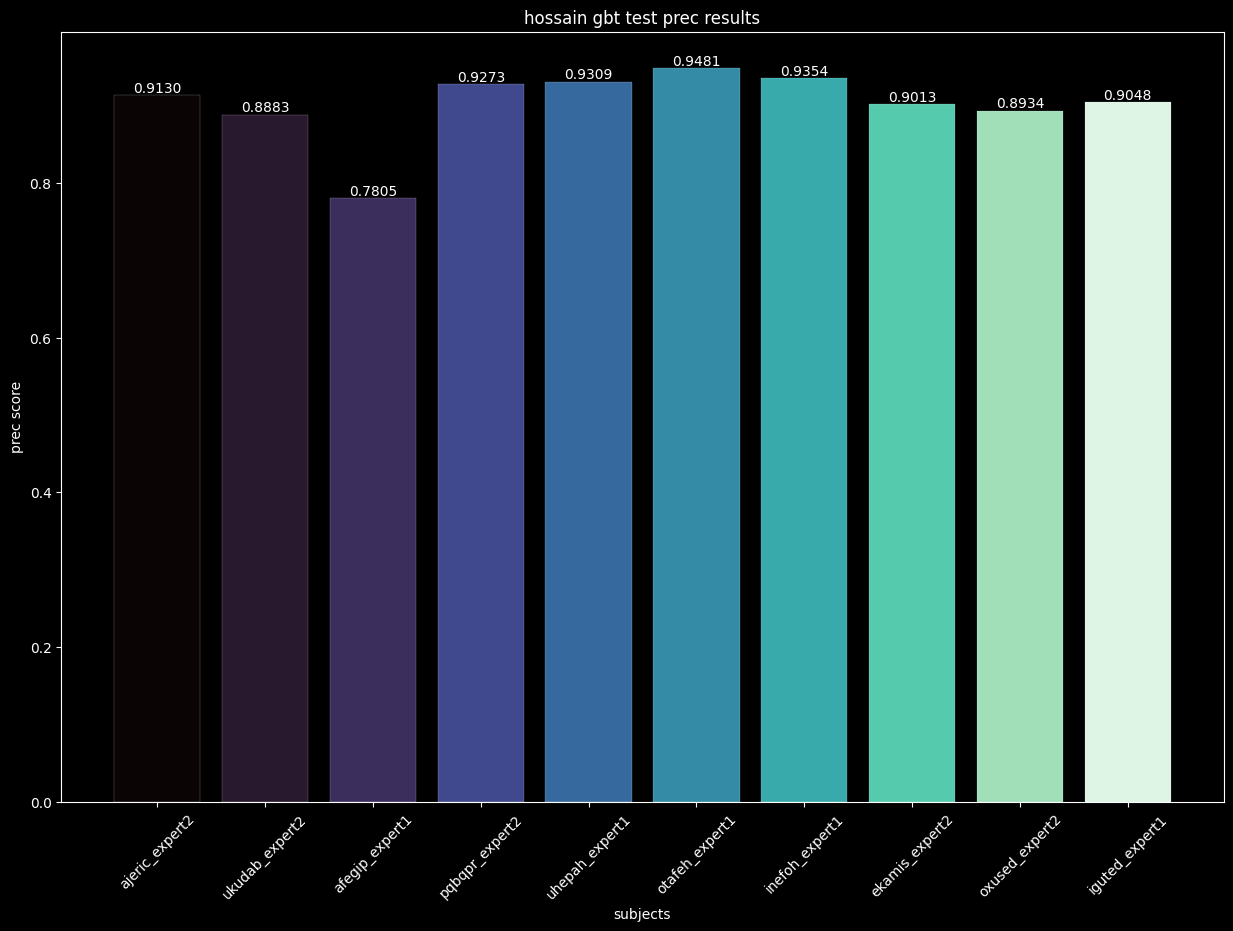

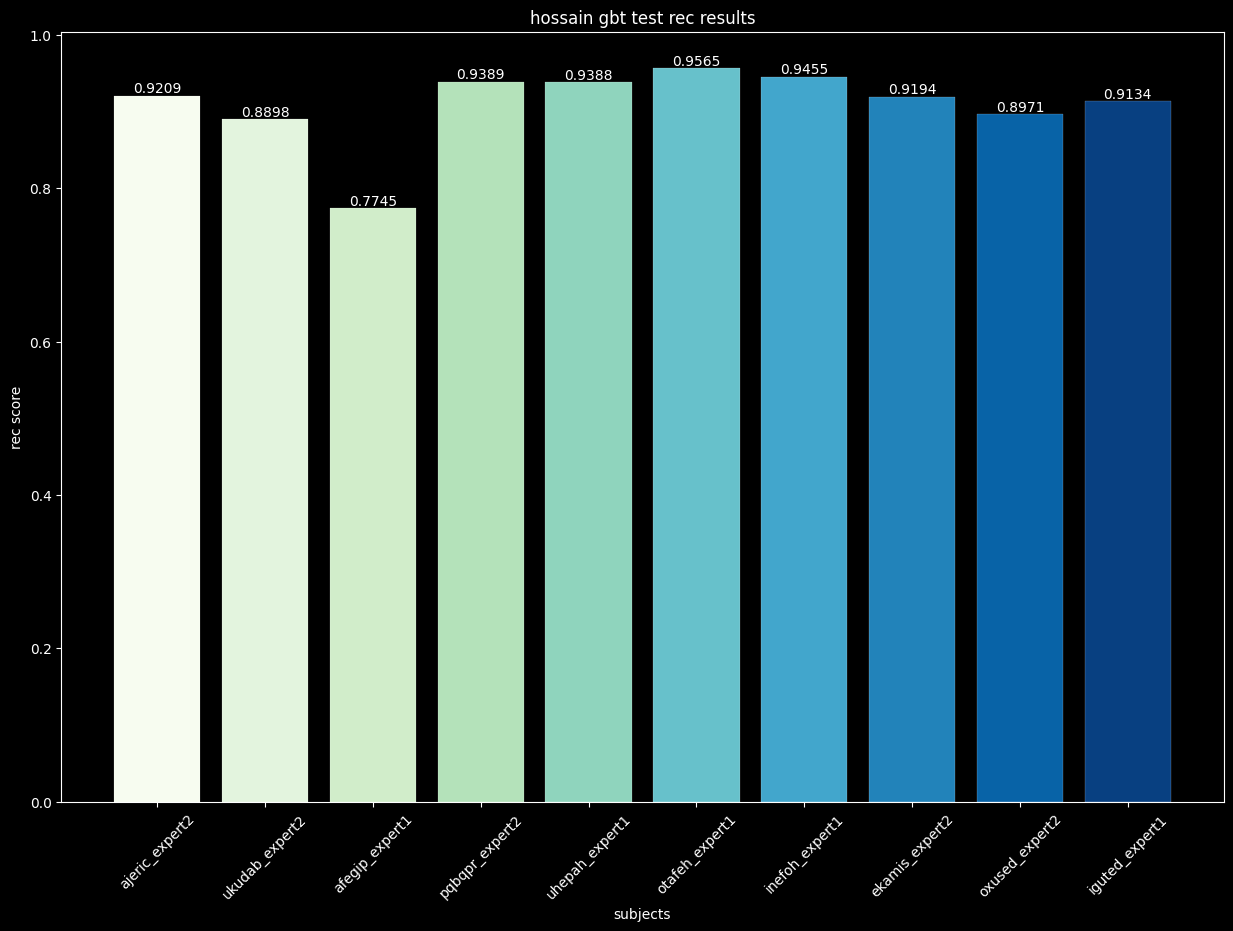

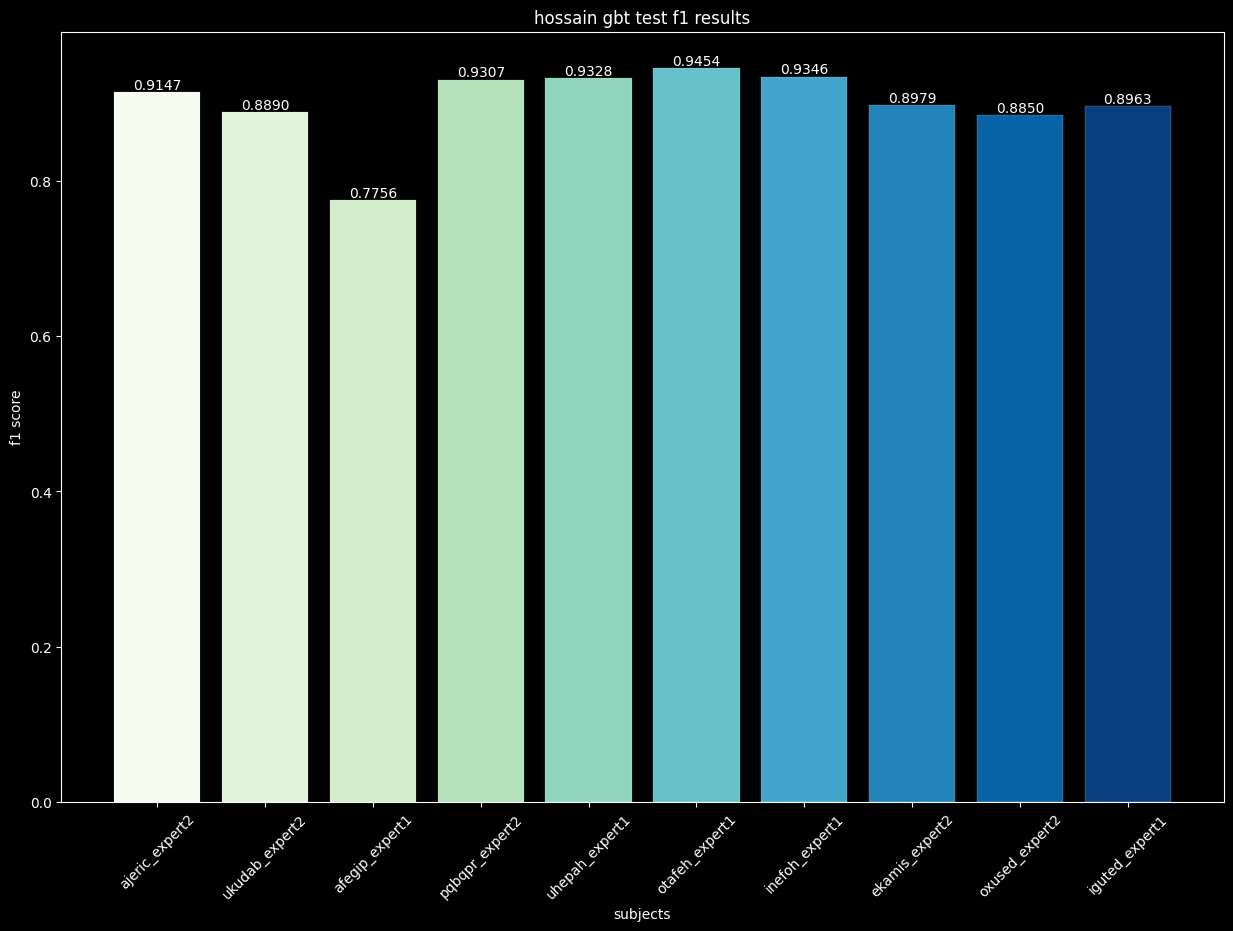

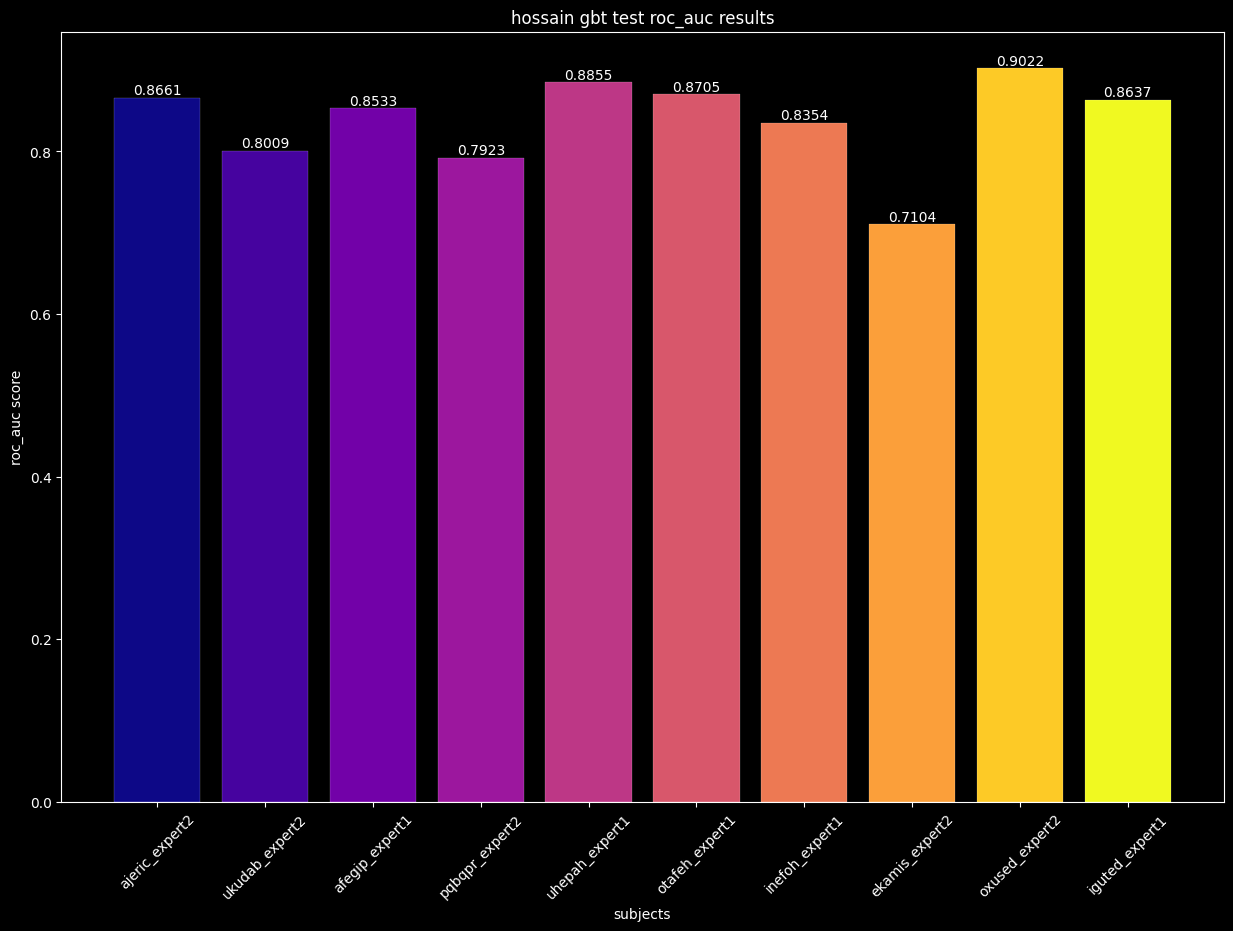

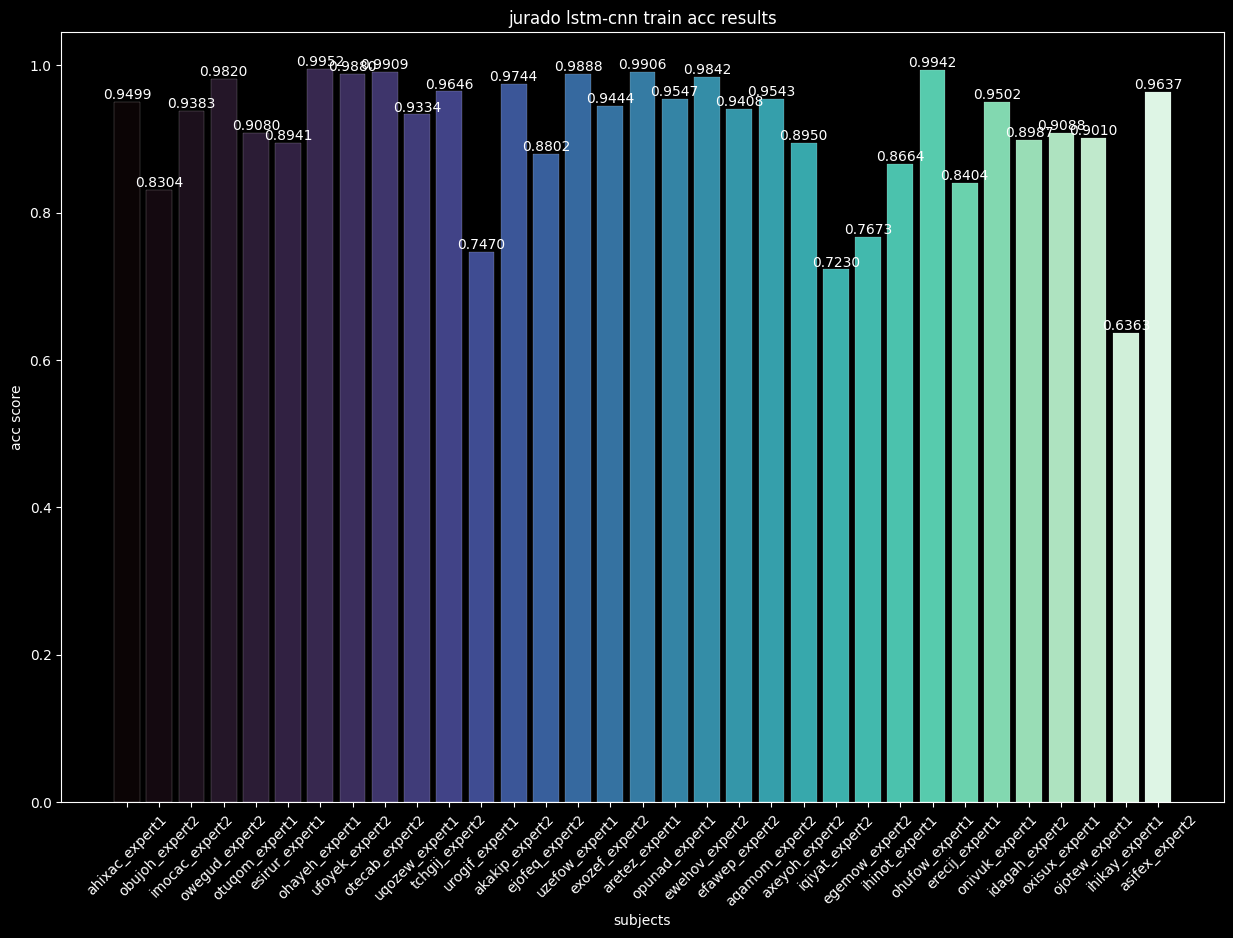

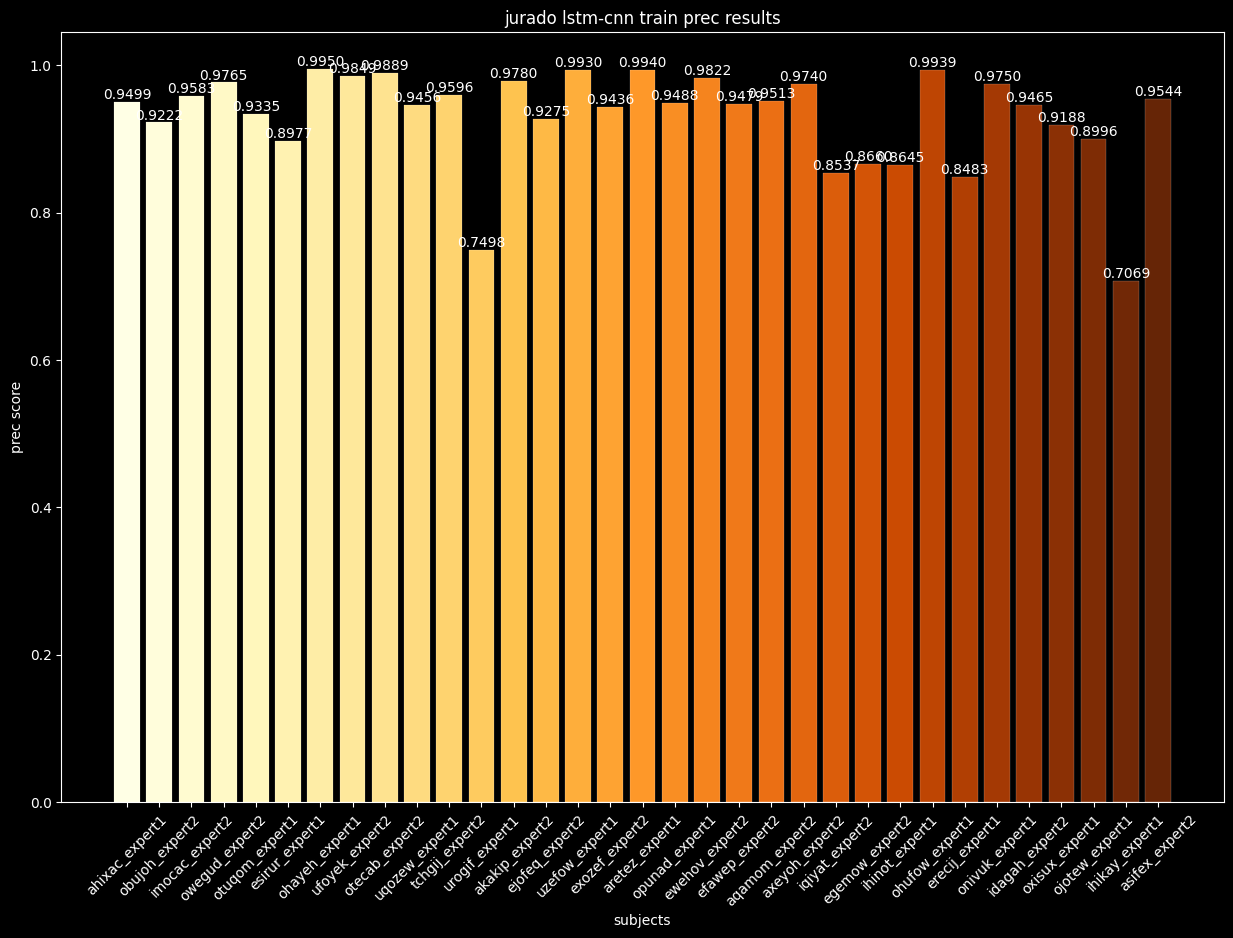

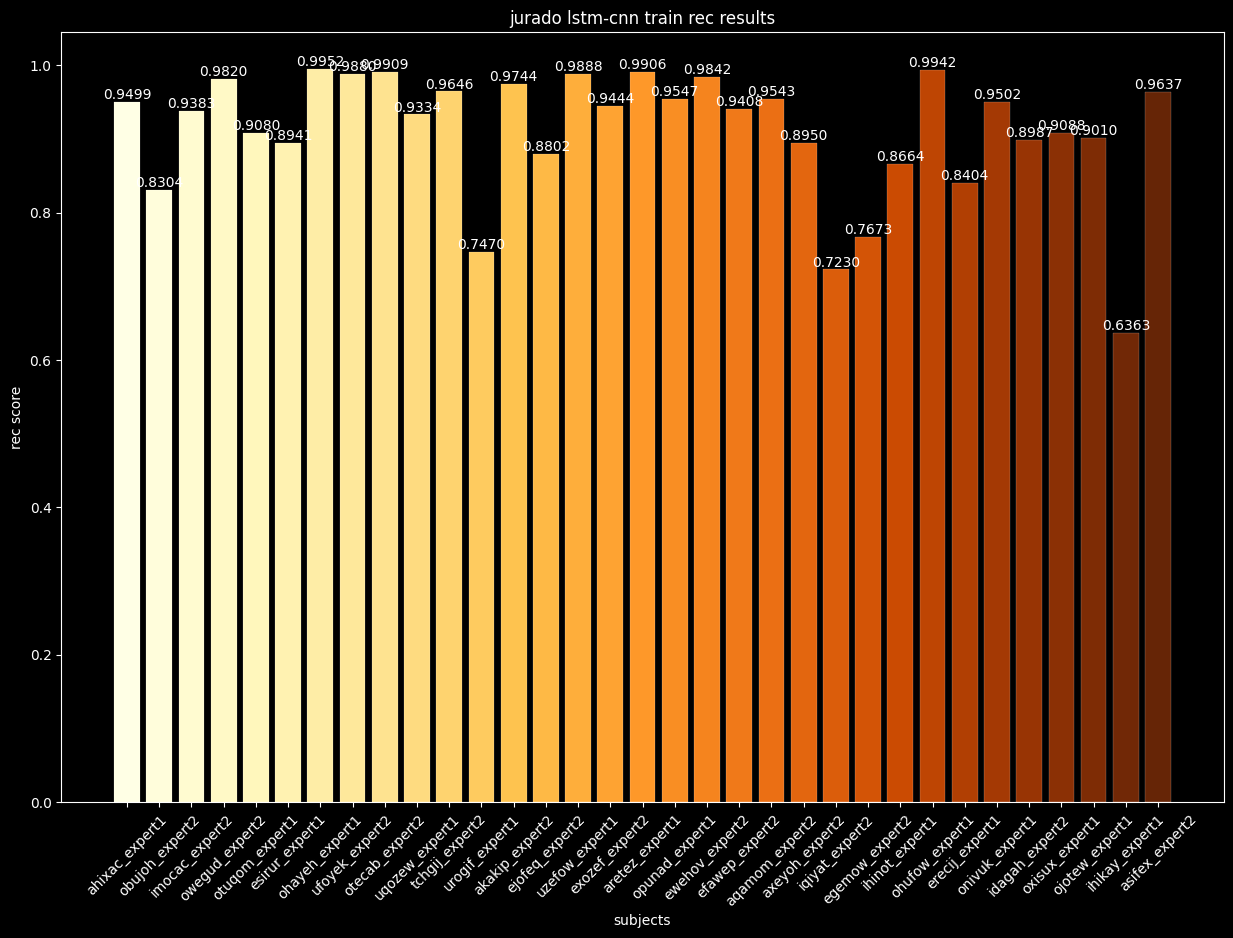

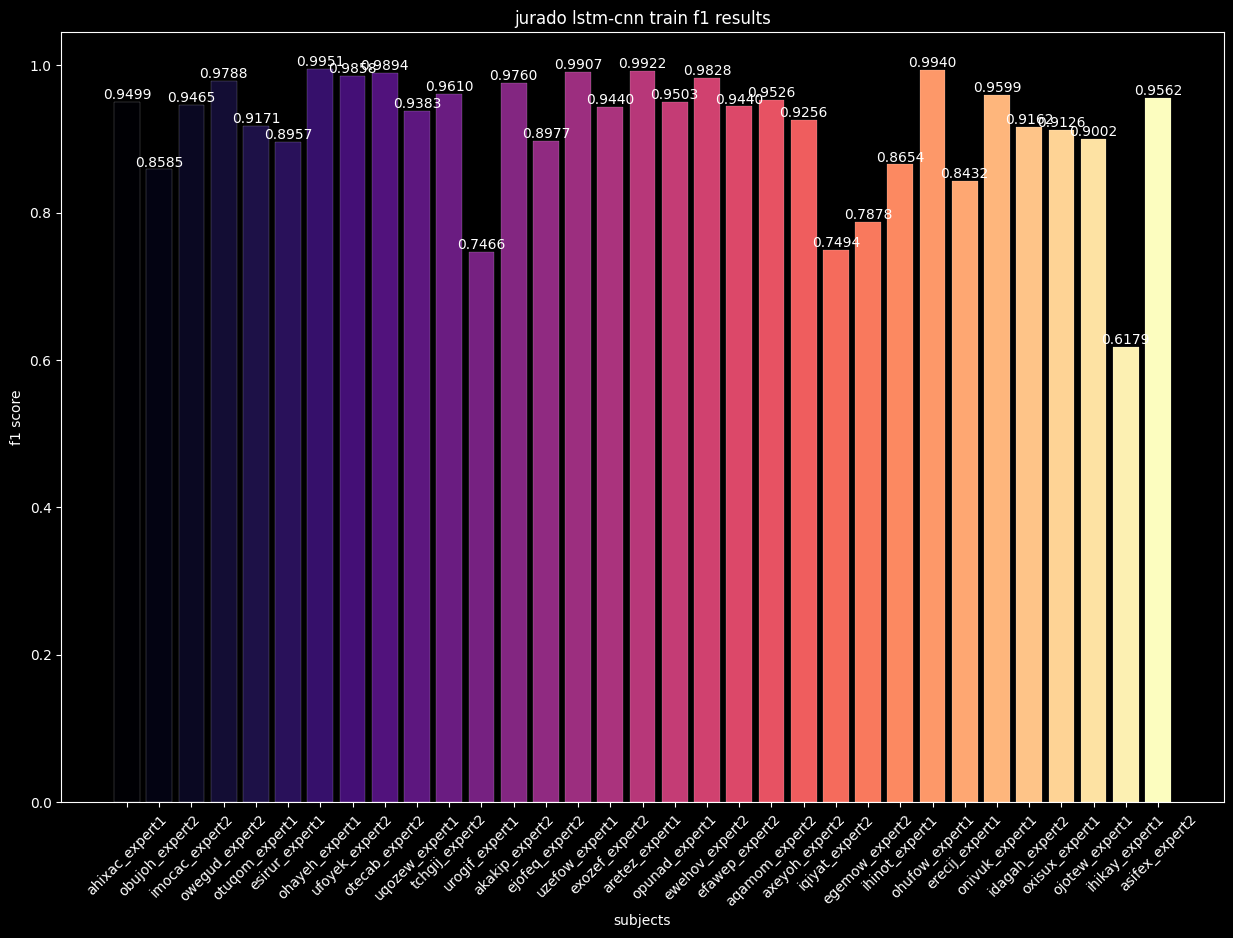

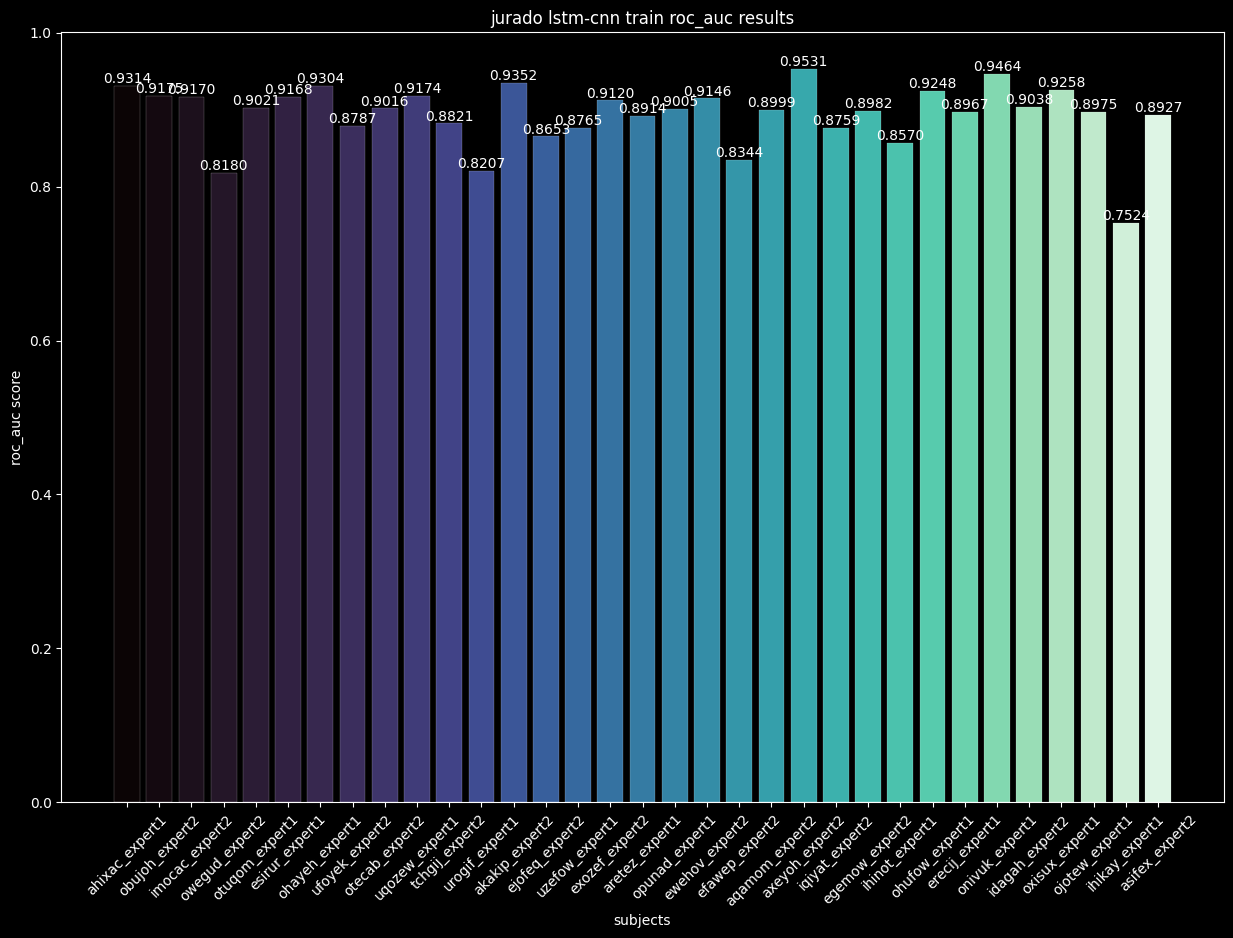

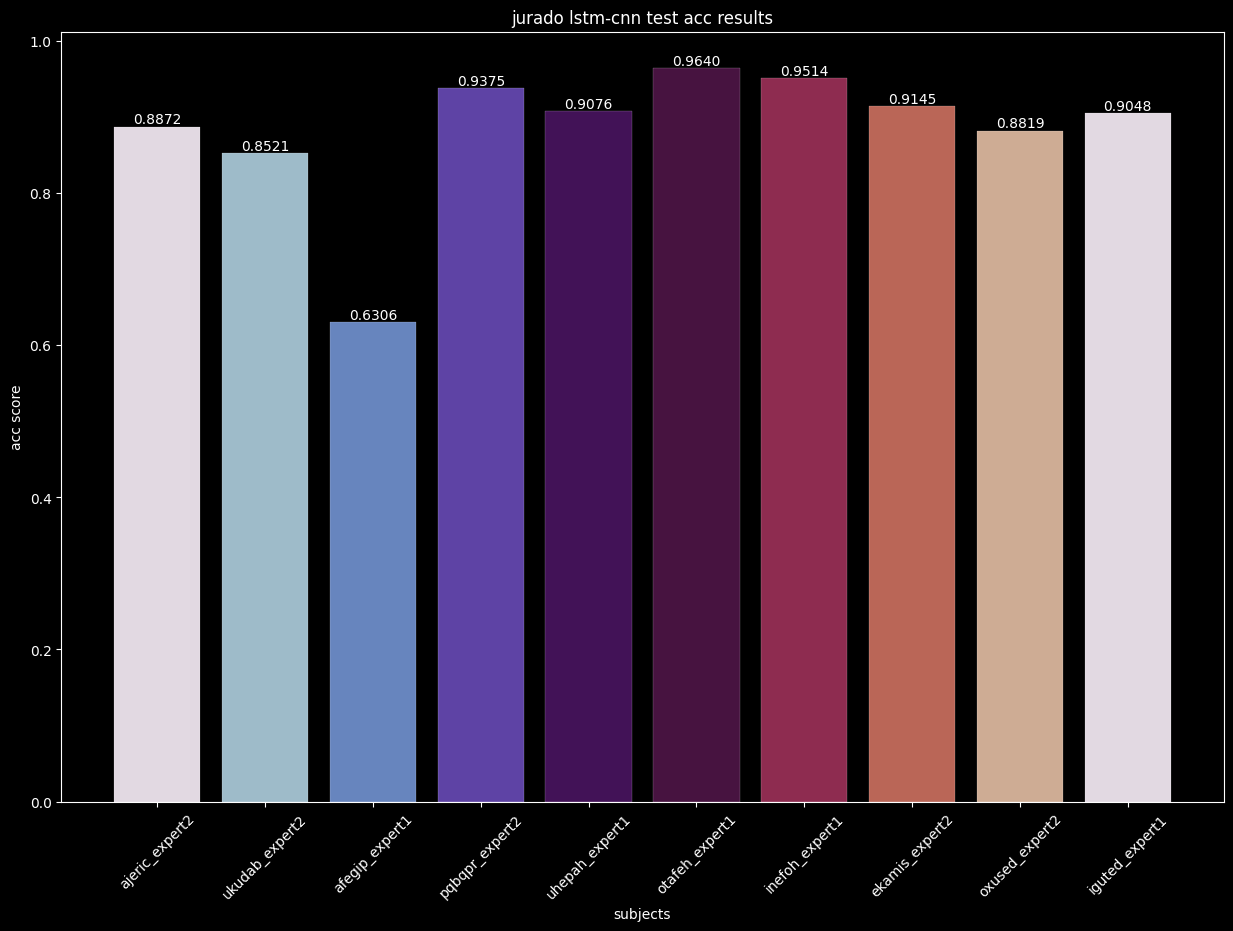

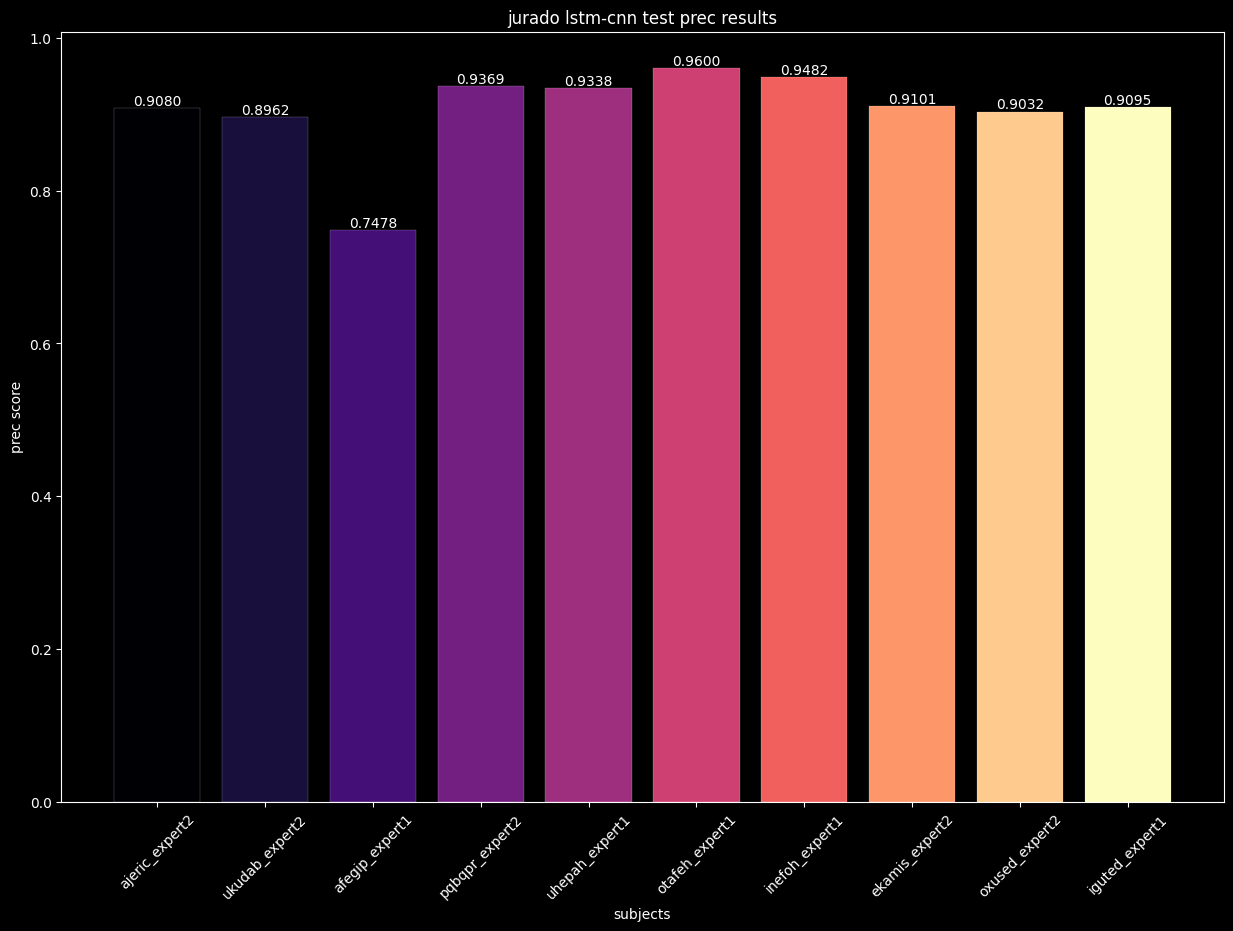

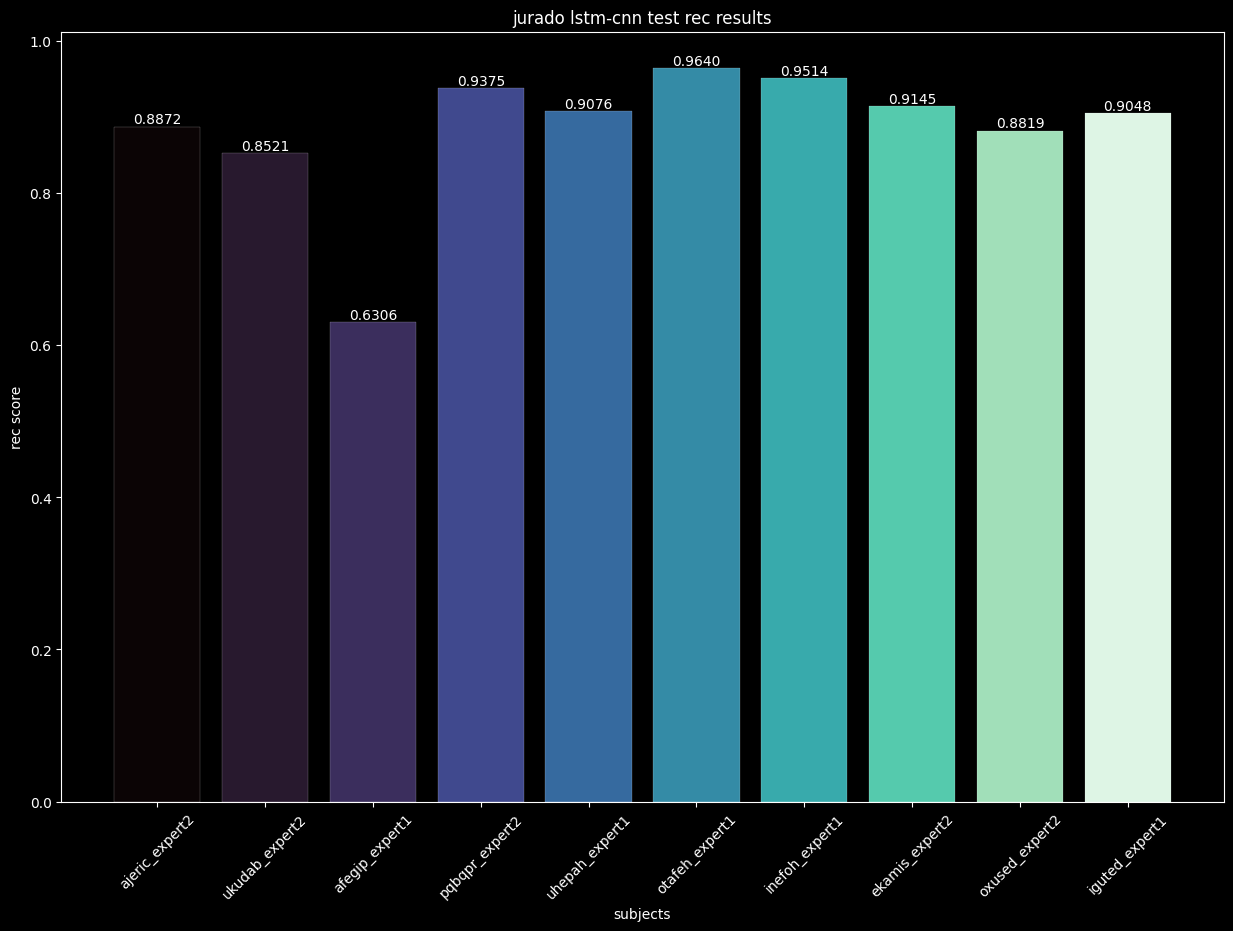

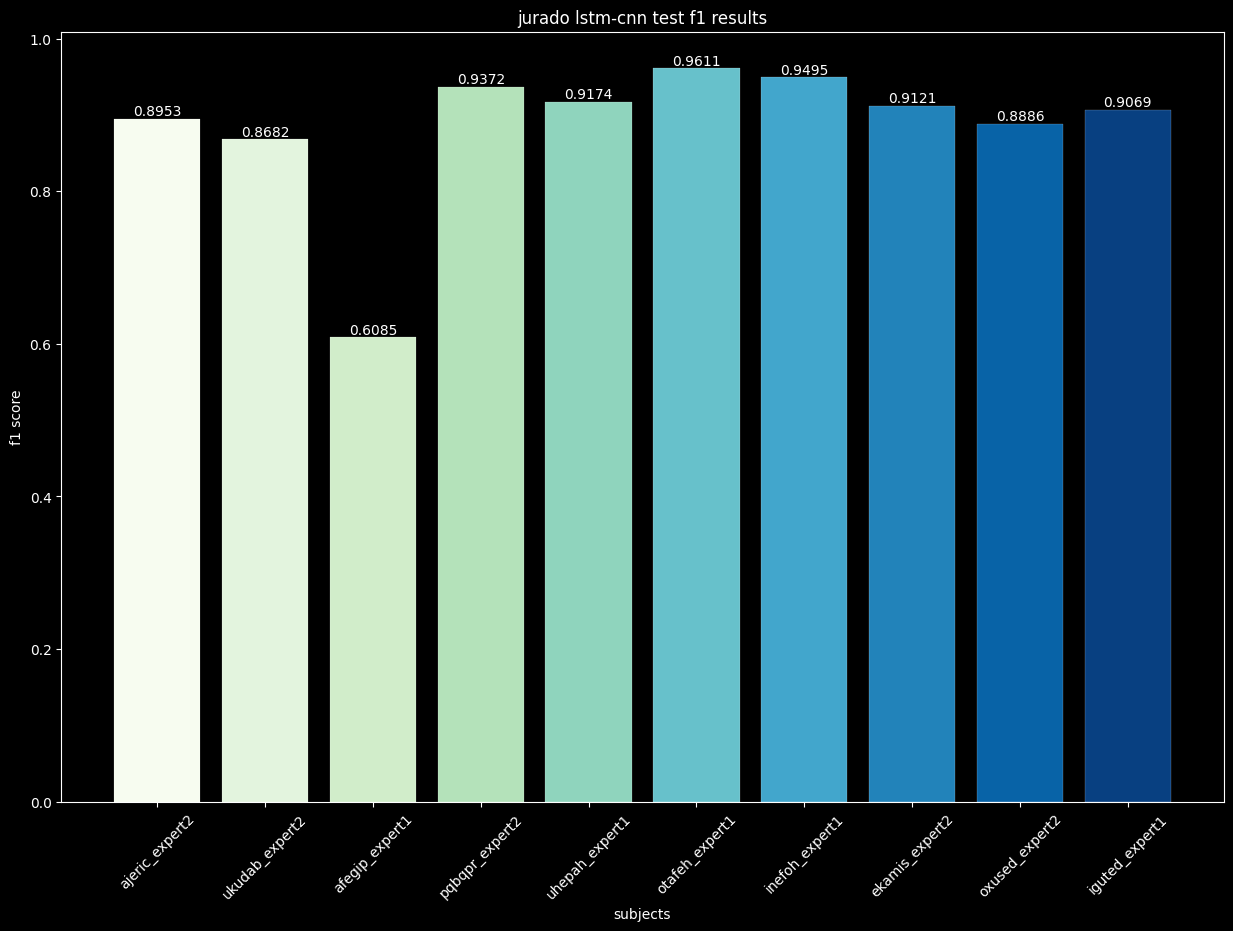

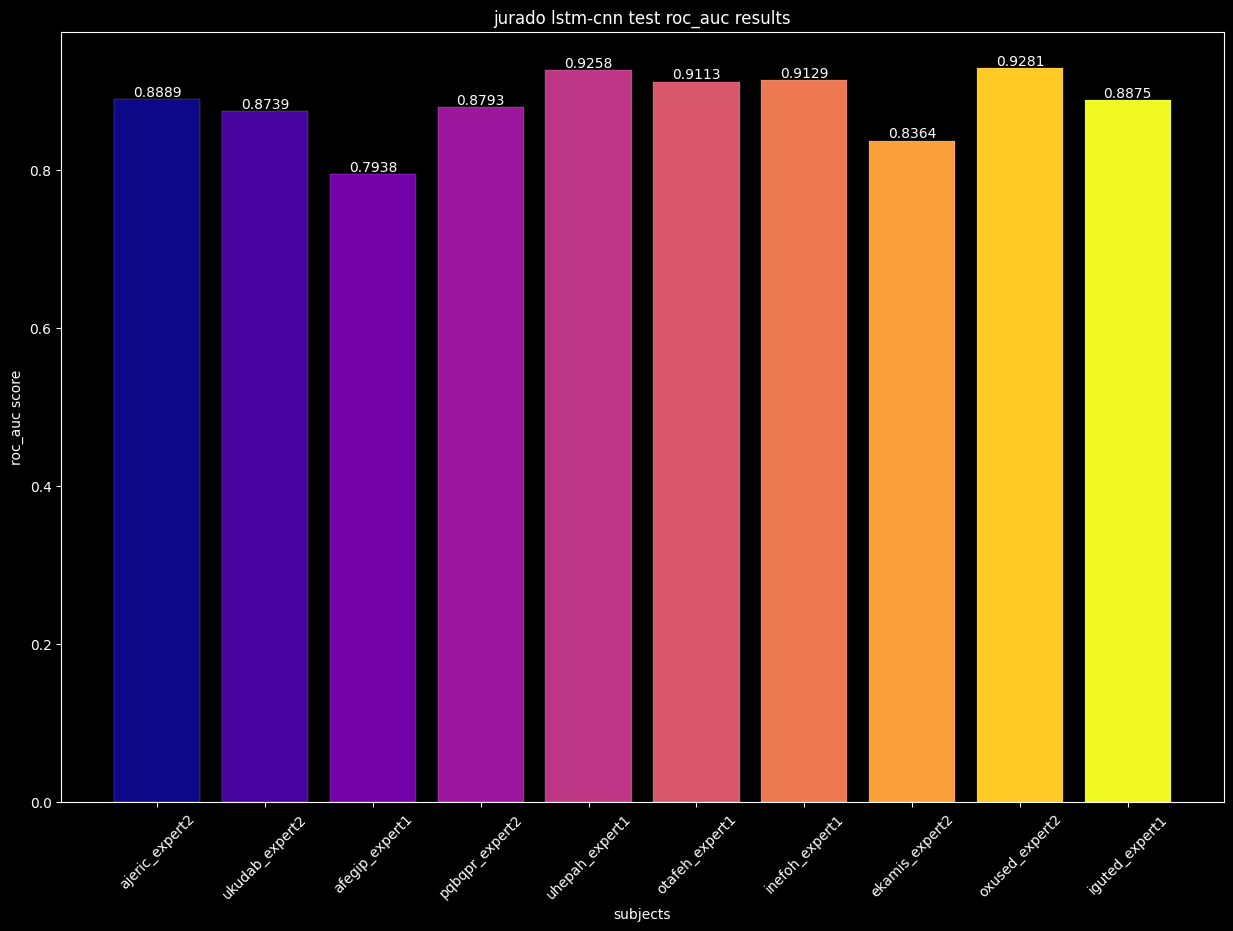

In [10]:
for model_name in model_names:
    # extract selector config and estimator name from model name
    selector_config, estimator_name = model_name.split('-', 1)

    for data_split in data_splits:
        for metric in metrics:
            data = [(subject_name, result[f'{data_split}_{metric}']) for (subject_name, result) in models[f'{selector_config}-{estimator_name}'][f'{data_split}_results']]
            sample_idx = np.random.choice(len(colormaps), size=1)[0]
            colormap = colormaps[sample_idx]
            view_subject_results(data, 
                selector_config=selector_config, 
                estimator_name=estimator_name,
                data_split=data_split,
                metric=metric,
                colormap=colormap,
                style='dark'
            )


## from here we create a graph now that takes the mean value of each metric for each model
![sample results chart.png](../../sample%20averaged%20results%20chart.png)

## So in this case the `x_ticks` would be the `model_names` themselves and the `y_ticks` would be the mean accuracy of each model listed

In [11]:
# model_names = ['cueva_second_phase-svm', 'taylor-lr', 'taylor-rf', 'taylor-svm', 'hossain-lr', 'hossain-gbt', 'hossain-svm', 'jurado-lstm-cnn']
model_names = ['cueva_second_phase-svm', 'taylor-lr', 'taylor-rf', 'taylor-svm', 'hossain-lr', 'hossain-gbt', 'jurado-lstm-cnn']
data_splits = ["train", "test"]
metrics = ["acc", "prec", "rec", "f1", "roc_auc"]
colormaps = ['mako', 'GnBu', 'plasma', 'magma', 'twilight', 'YlOrBr']

In [12]:
def view_models_mean_results(data, data_split: str="train", metric: str="acc", colormap: str="plasma", save_img: bool=True, style: str='default'):
    """
    suitable for all discrete input

    plots either a horizontal bar graph to display frequency of words top 'limit' 
    words e.g. top 20 or a pie chart to display the percentages of the top 'limit' 
    words e.g. top 20, specified by the argument kind which can be either
    strings barh or pie

    main args:
        data - list of tuples representing the subject and the subjects respective score
        data_split - 
        metric - 
        colormap - 
        save_img - 
        style - 
    """

    # compose title based on selector_config, estimator_name, data_split, and metric args
    title = f'{data_split} {metric} results'

    # extract x and y values from data
    x_ticks, y_ticks = list(zip(*data))

    styles = {
        'dark': 'dark_background',
        'solarized': 'Solarized_Light2',
        '538': 'fivethirtyeight',
        'ggplot': 'ggplot',
    }

    plt.style.use(styles.get(style, 'default'))

    # define figure
    cmap = mpl.colormaps[colormap]
    fig = plt.figure(figsize=(15, 10))
    axis = fig.add_subplot()

    # plot bar graph
    bar = axis.bar(x_ticks, y_ticks, color=cmap(np.linspace(0, 1, len(data))), edgecolor='white', linewidth=0.125)
    axis.bar_label(bar, fmt='{:.4f}')
    axis.set_xlabel('models', )
    axis.set_ylabel(f'{metric} score', )
    axis.tick_params(axis='x', labelrotation=45.0)
    axis.set_title(title)
    if save_img:
        plt.savefig(f'./figures & images/{title}.png')
    plt.show()

data split: train
metric: acc


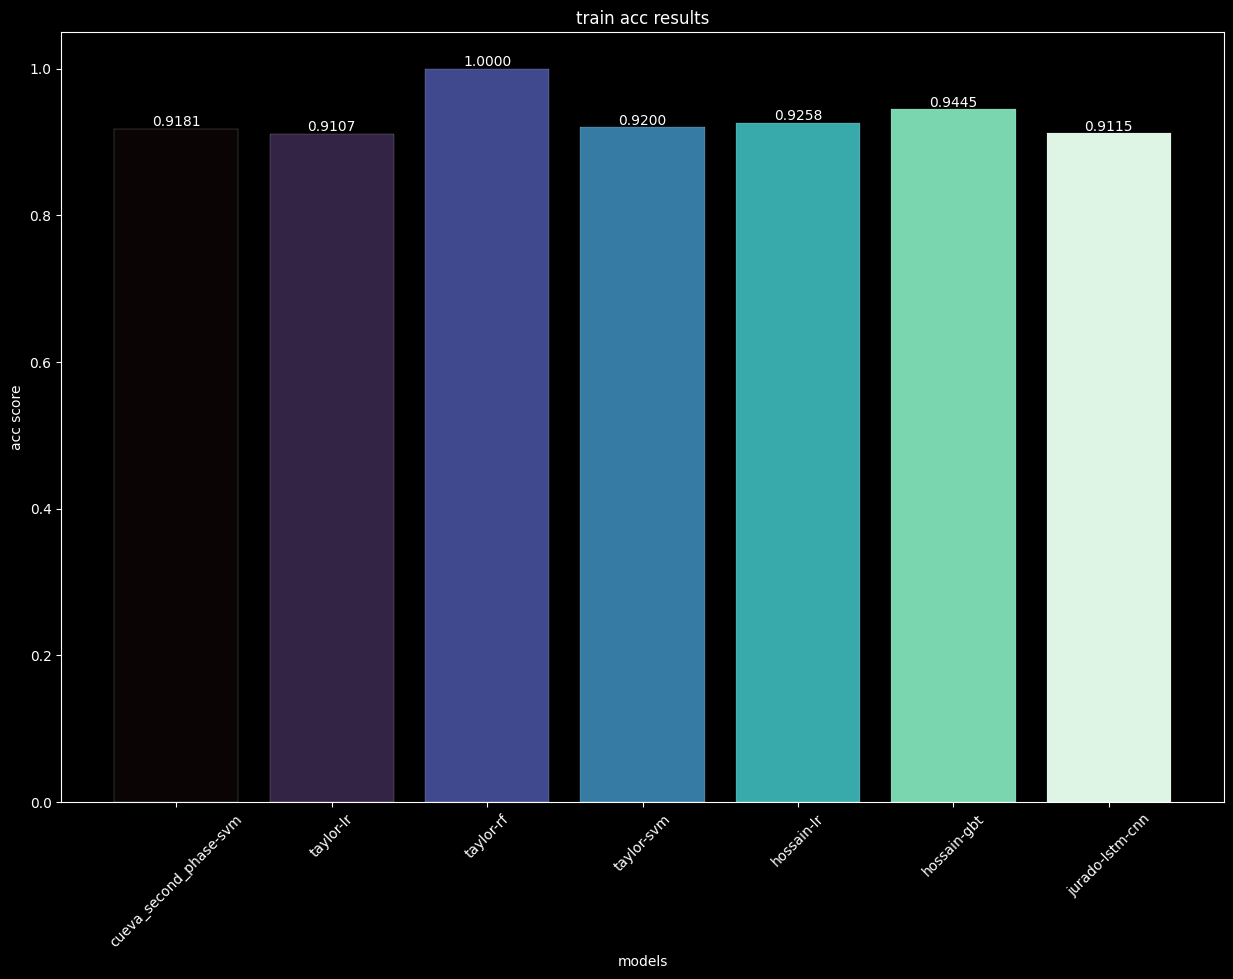

data split: train
metric: prec


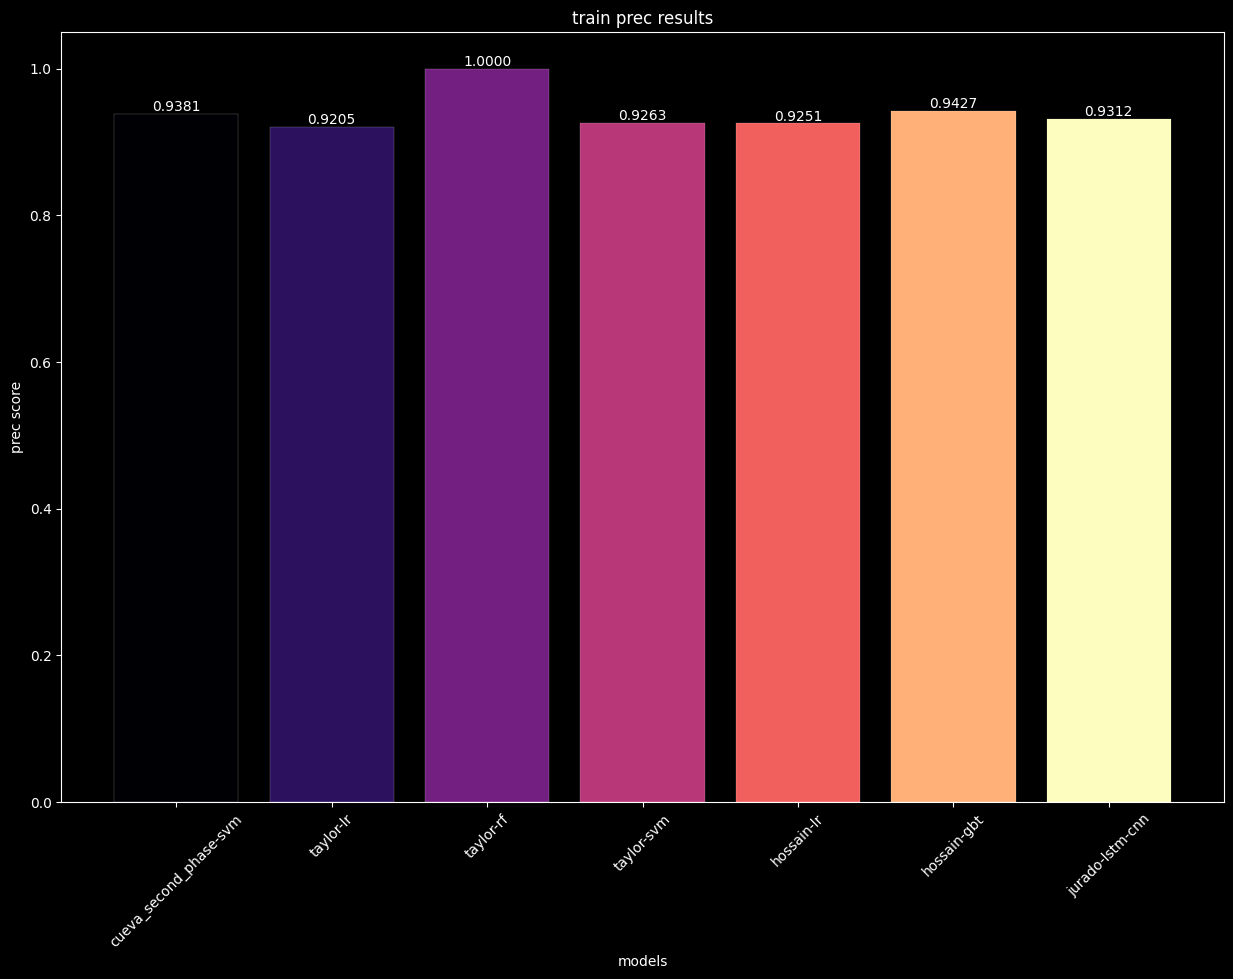

data split: train
metric: rec


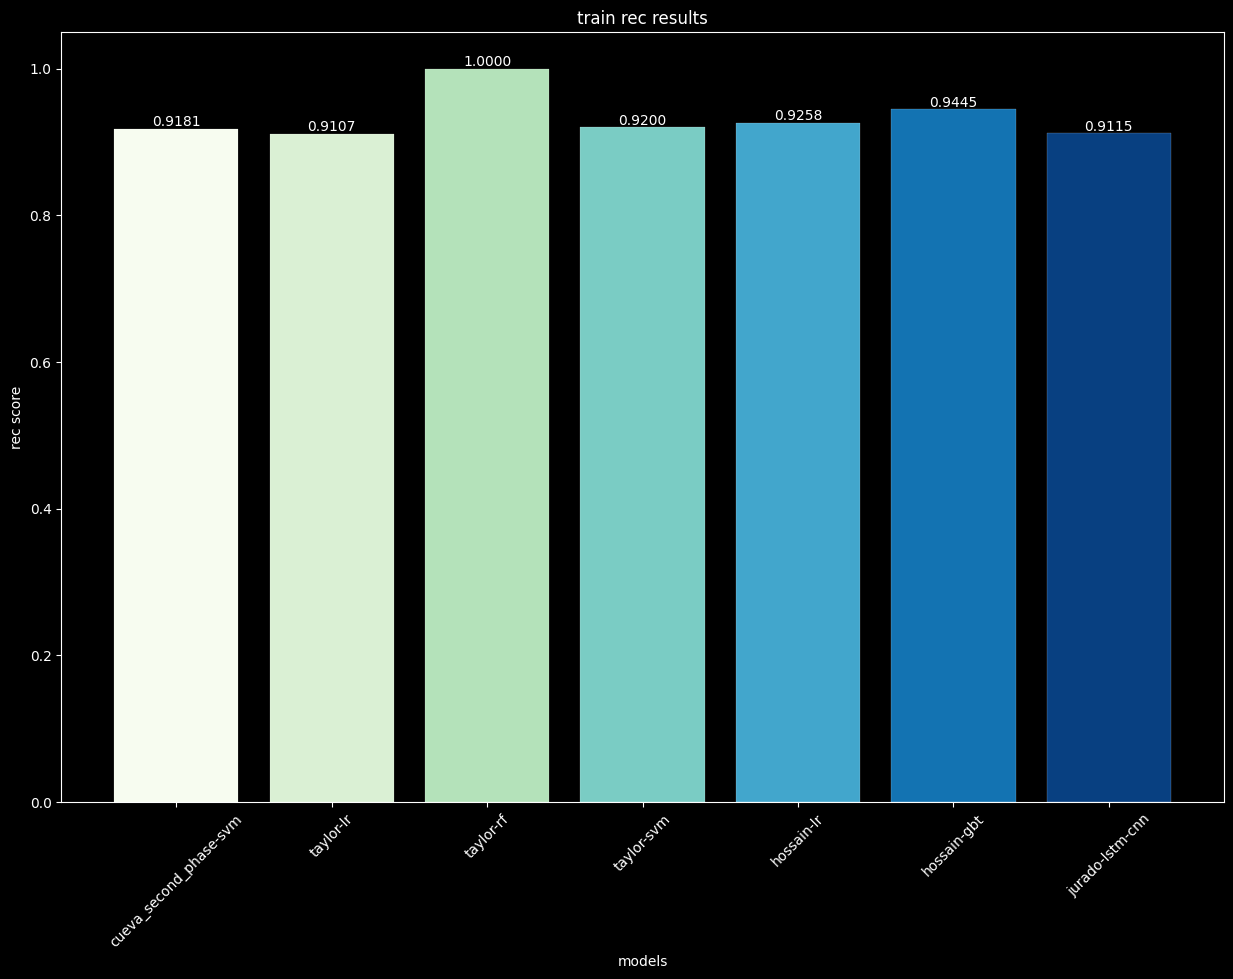

data split: train
metric: f1


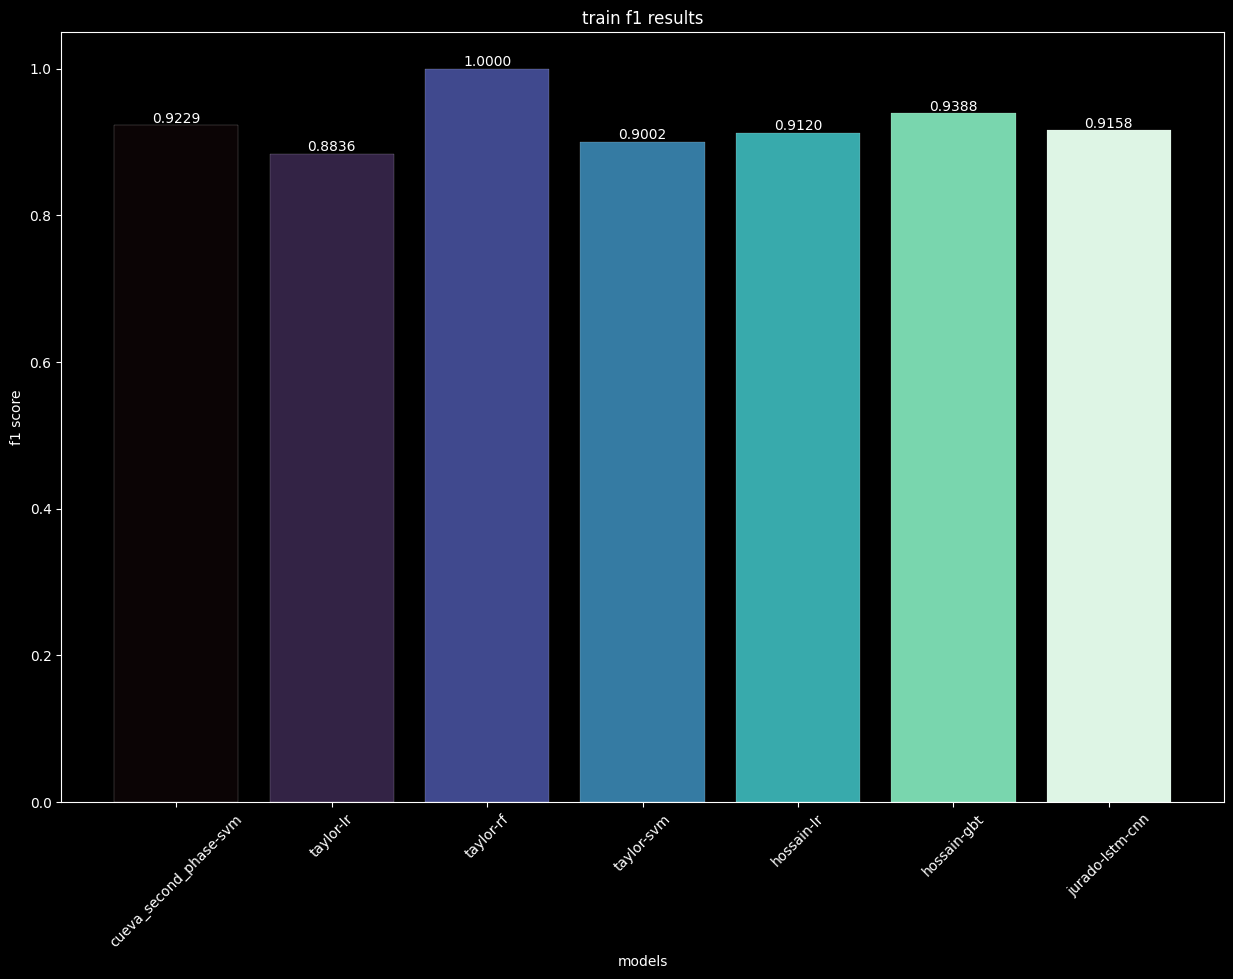

data split: train
metric: roc_auc


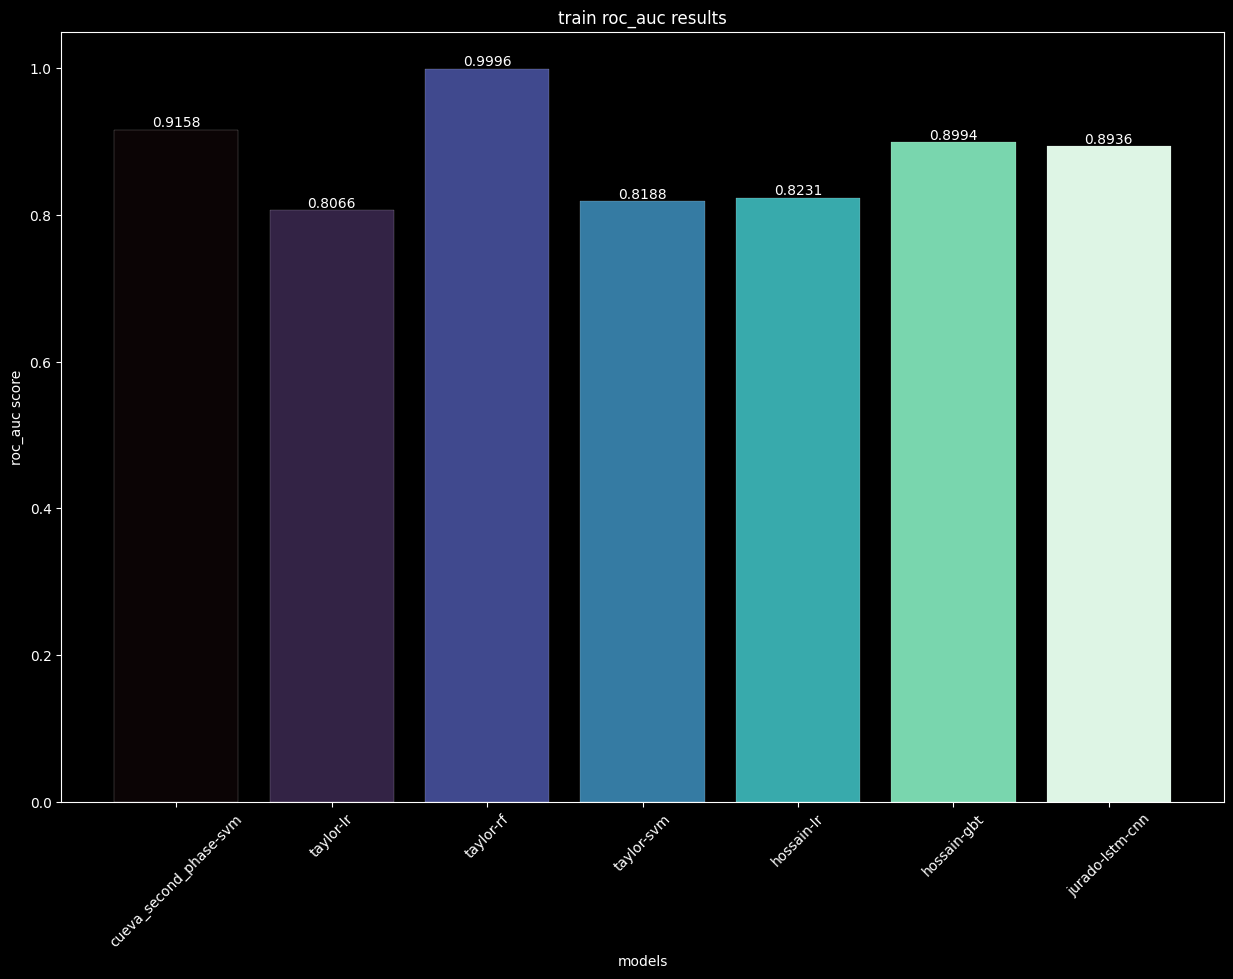

data split: test
metric: acc


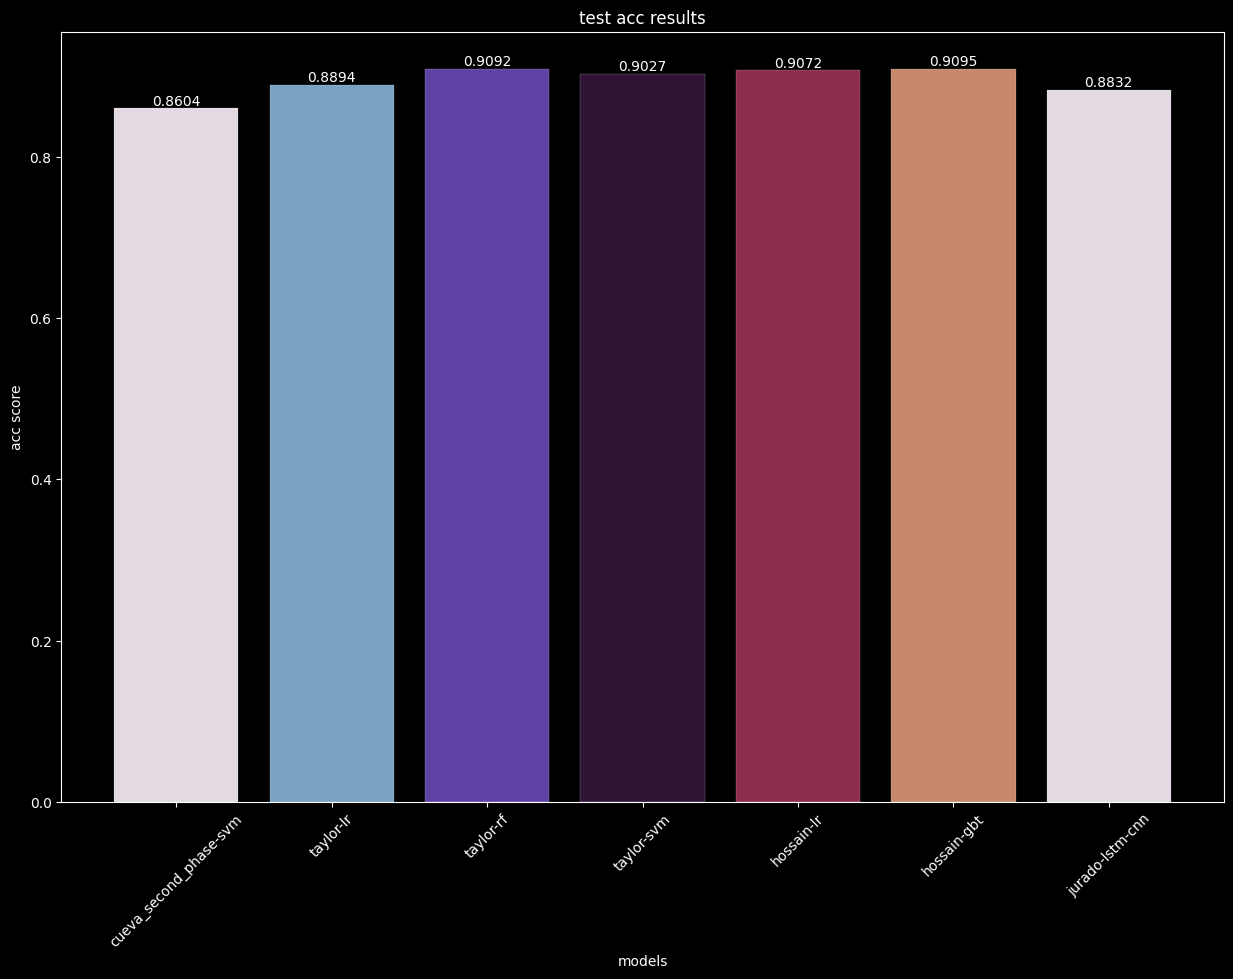

data split: test
metric: prec


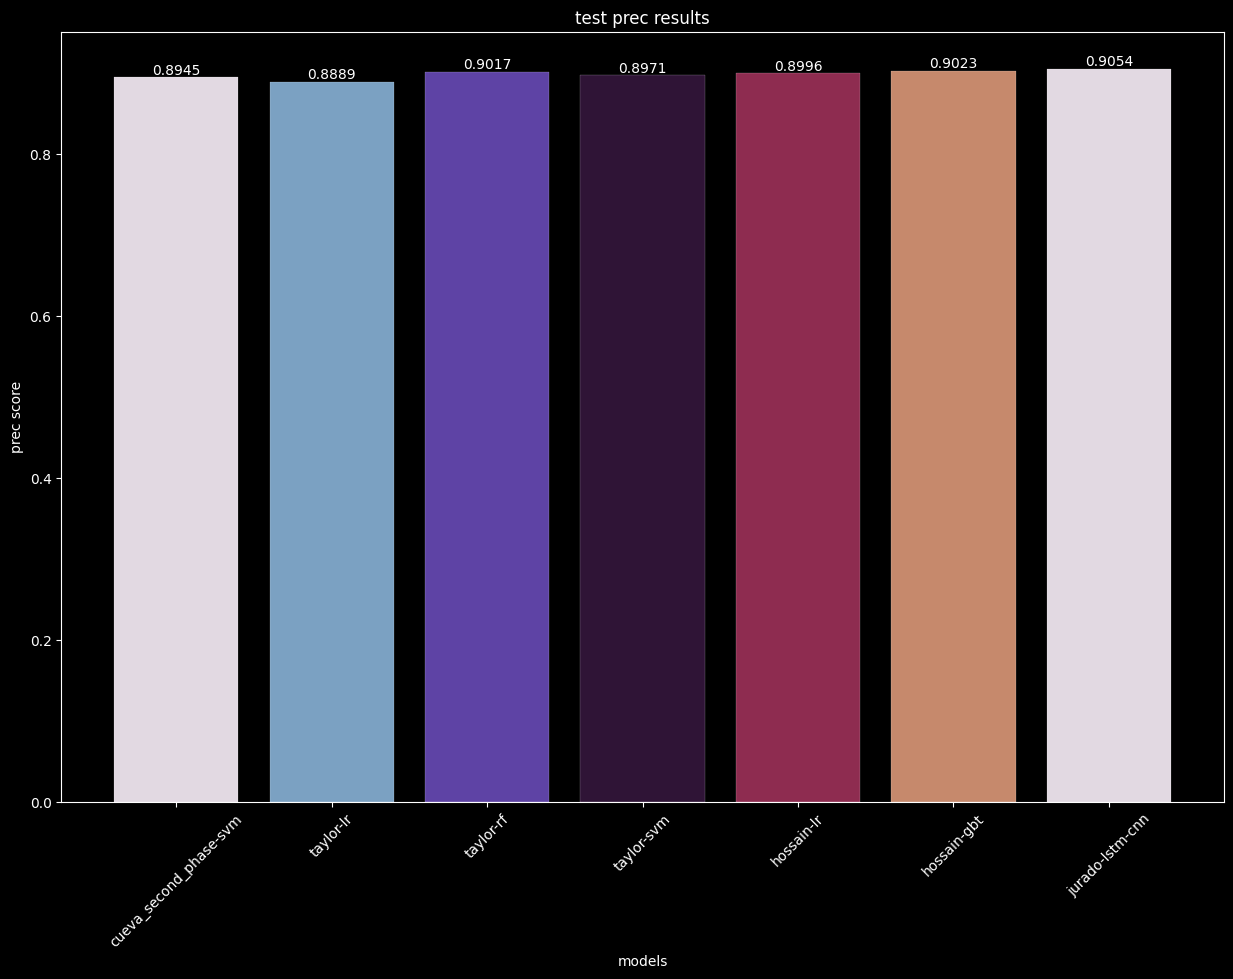

data split: test
metric: rec


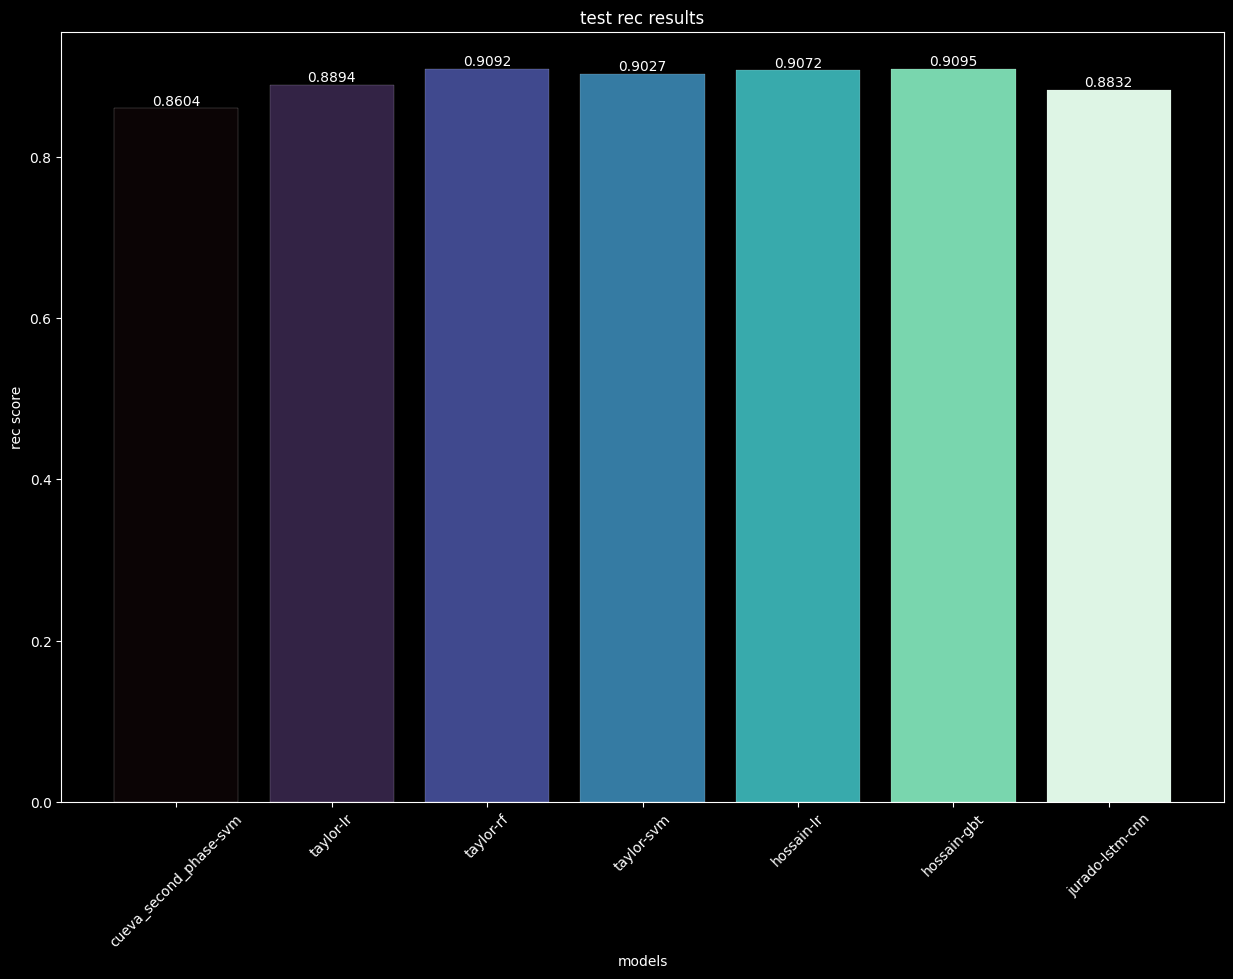

data split: test
metric: f1


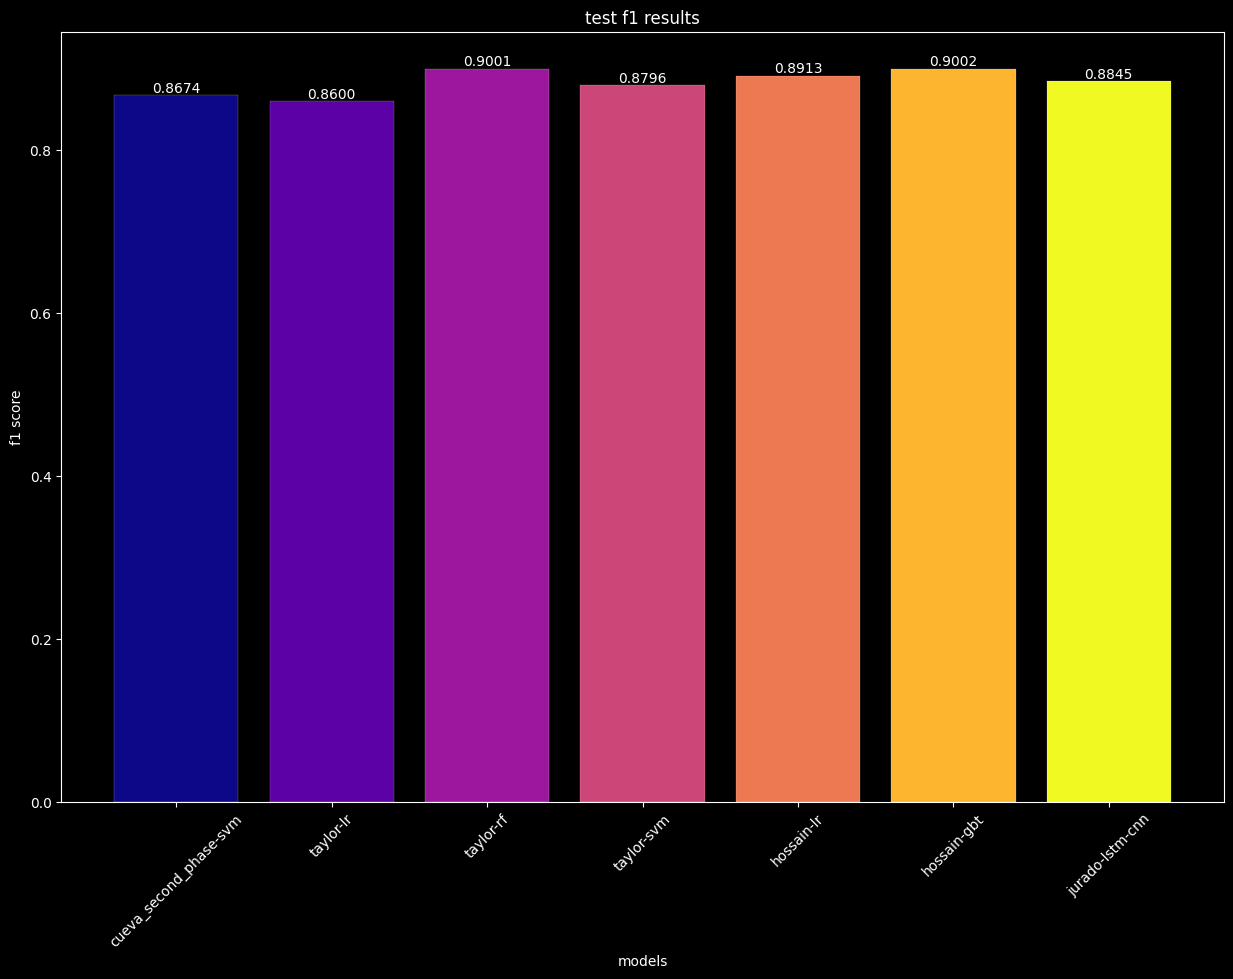

data split: test
metric: roc_auc


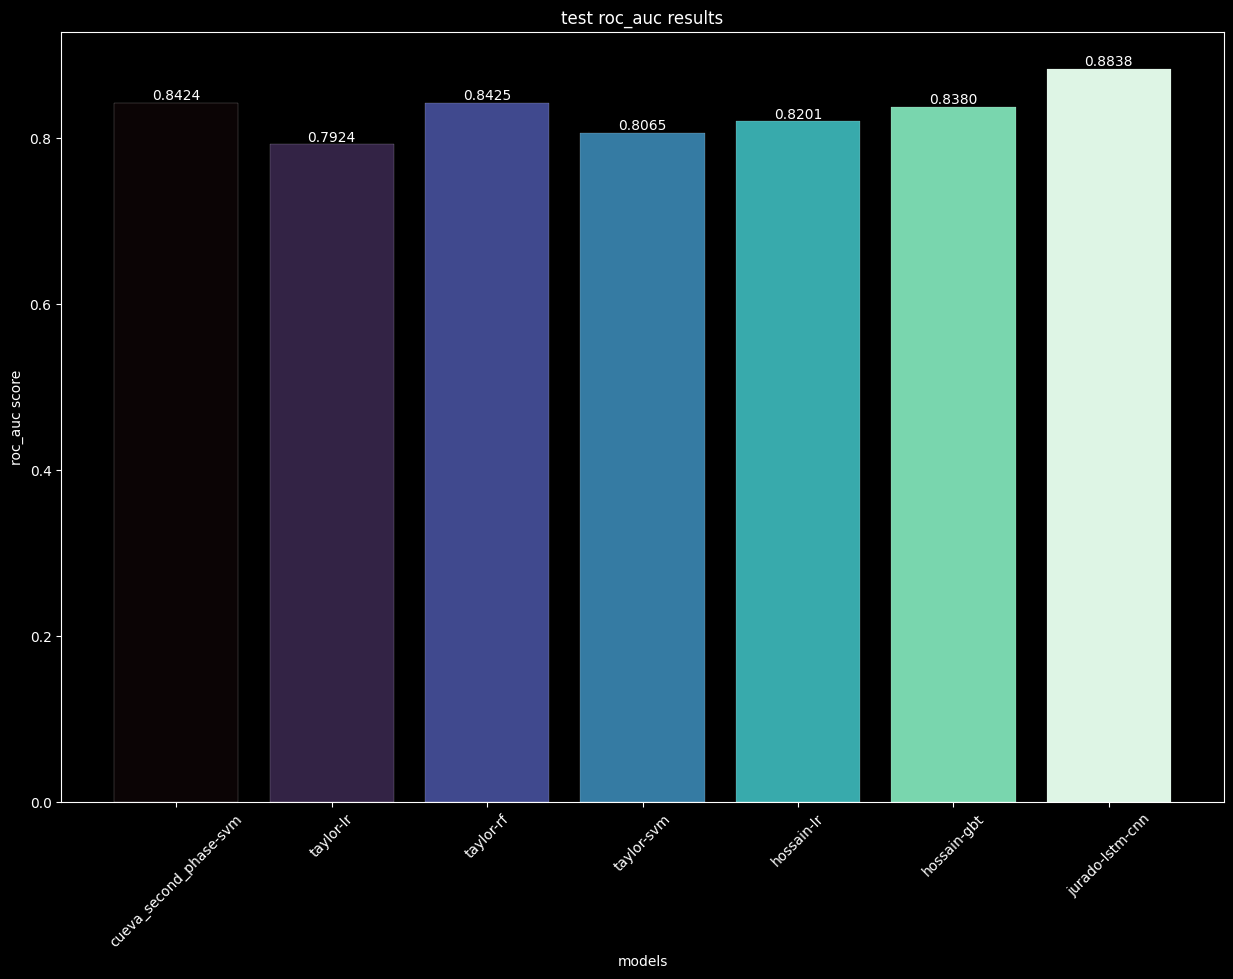

In [13]:
for data_split in data_splits:
    for metric in metrics:
        print(f'data split: {data_split}')
        print(f'metric: {metric}')
        ticks = []
        for model_name in model_names:
            # extract selector config and estimator name from model name
            selector_config, estimator_name = model_name.split('-', 1)
            
            # take the mean of a specific models metrics
            mean_result = np.mean([result[f'{data_split}_{metric}'] for (_, result) in models[model_name][f'{data_split}_results']])

            ticks.append((model_name, mean_result))
        # print(f'{ticks}\n')
        # x_ticks, y_ticks = list(zip(*ticks))
        # print(f'{x_ticks} {y_ticks}\n')

        sample_idx = np.random.choice(len(colormaps), size=1)[0]
        colormap = colormaps[sample_idx]
        view_models_mean_results(ticks, data_split=data_split, metric=metric, colormap=colormap, style='dark')

In [14]:
ticks

[('cueva_second_phase-svm', 0.8423865191148503),
 ('taylor-lr', 0.7924306556350101),
 ('taylor-rf', 0.8424905796545248),
 ('taylor-svm', 0.8065358547920815),
 ('hossain-lr', 0.8200675254690438),
 ('hossain-gbt', 0.8380327814900094),
 ('jurado-lstm-cnn', 0.8837927233239473)]

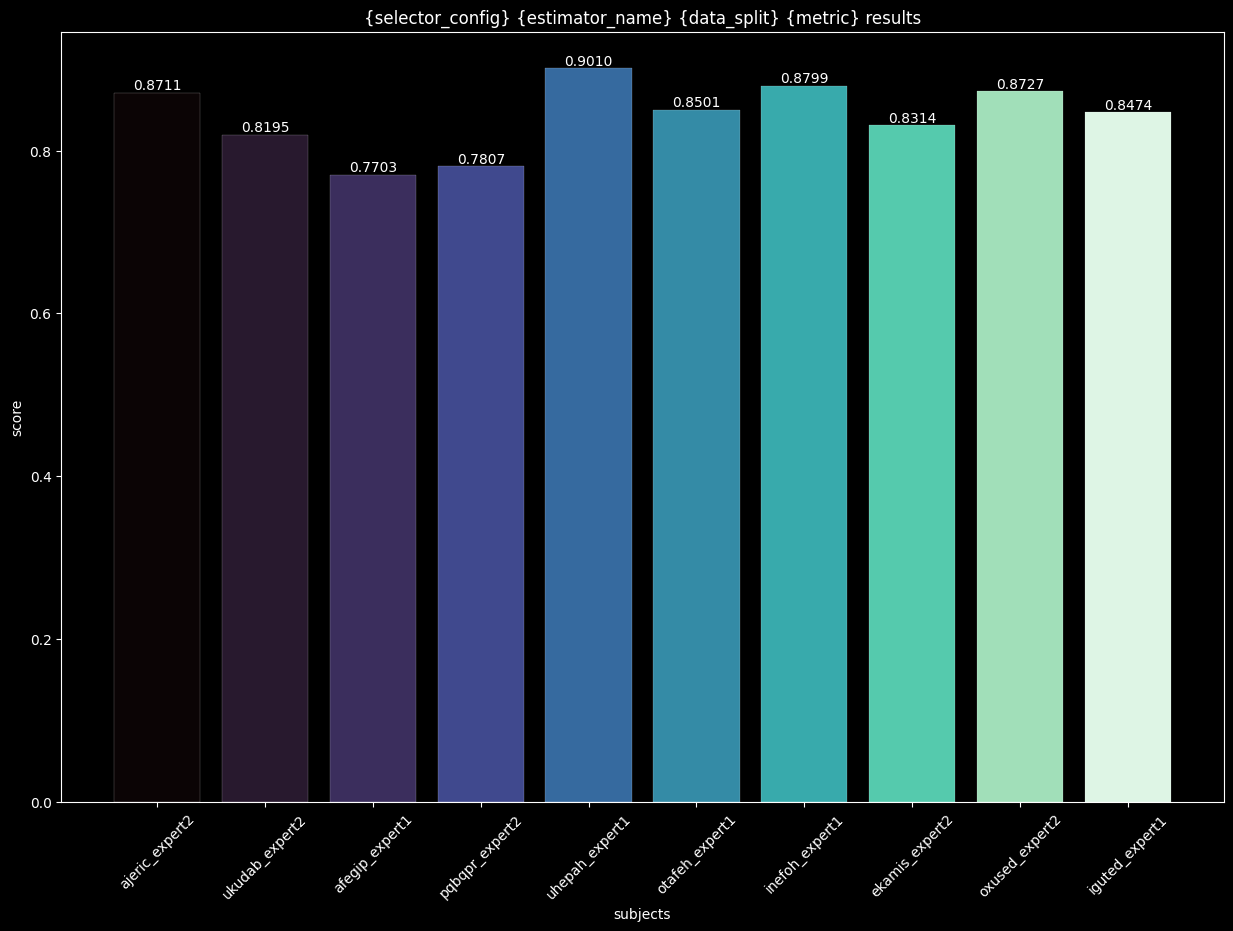

In [15]:
cmap = mpl.colormaps['mako']
fig = plt.figure(figsize=(15, 10))
axis = fig.add_subplot()

bar = axis.bar(x_ticks, y_ticks, color=cmap(np.linspace(0, 1, len(data))), edgecolor='white', linewidth=0.125)
axis.bar_label(bar, fmt='{:.4f}')
axis.set_xlabel('subjects', )
axis.set_ylabel('score', )
axis.tick_params(axis='x', labelrotation=45.0)
axis.set_title('{selector_config} {estimator_name} {data_split} {metric} results')
plt.show()